# Analysis of Global Compact COP reports

For this analysis we download from [here](https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active) all COP reports submitted up to 2018. We only take into account the reports submitted in English.

Please specify below the focus year of this analysis. It will be consider as the end point of historical analyses, as well as the year for annual analyses.

In [1]:
focus_year = "2018"

Please select the focus language using one of the following values:
- en (English, default option)
- de (German)
- es (Spanish)
- fr (French)
- pt (Portuguese)

In [2]:
focus_language = 'en'

In [3]:
language_ref = { 'en' : { 'name' : 'English', 'min_coocurrence' : 10},
                 'de' : { 'name' : 'German', 'min_coocurrence' : 2},
                 'es' : { 'name' : 'Spanish', 'min_coocurrence' : 2},
                 'fr' : { 'name' : 'French', 'min_coocurrence' : 2},
                 'pt' : { 'name' : 'Portuguese', 'min_coocurrence' : 2},
               }

## 1. Gathering information about COP reports available from the UN Global Compact website
The [UN Global Compact website](https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active) contains entries for each COP report, describing the sector of the company submitting the report, country and year, as well as the language in which the repoort was written in and a link to a PDF file with the full report.

**The results in this section give a general view of the available COPs, it's not yet restricted by the focus_year and focus_language.**

In [4]:
import requests
import re
from bs4 import BeautifulSoup

gc_url = "https://www.unglobalcompact.org/participation/report/cop/create-and-submit/active?page=1&per_page=10"
gc_base_url = "https://www.unglobalcompact.org"

gc_home = requests.get(gc_url)

soup = BeautifulSoup(gc_home.content, 'lxml')

header = soup.h2.string

total_num_cops = re.search(r'(?<=: )[0-9]+', header)[0]
print("Total number of COPs available: %s" % total_num_cops)

Total number of COPs available: 38895


---

In [5]:
import pandas as pd

reports_index_csv_filename = "../data/cops/reports_index.csv"

df_pdfs = pd.read_csv(reports_index_csv_filename, sep='\t', encoding='utf-8', index_col=0, dtype={'year': object})
pdfs = df_pdfs.to_dict(orient='index')

## 2. Selecting COP reports that match required criteria (up to focus_year, written in focus_language)

In [6]:
selected_sectors = {}
selected_countries = {}
selected_years = {}
selected_countries_years = {}

selected_pdfs = {}

for pdf in pdfs.keys():
    language = pdfs[pdf]["language"]
    year = pdfs[pdf]["year"]
    country = pdfs[pdf]["country"]
    sector = pdfs[pdf]["sector"]

    if language == language_ref[focus_language]['name'] and int(year) <= int(focus_year):
        selected_pdfs[pdf] = pdfs[pdf]
        
        selected_sectors[sector] = selected_sectors.get(sector,0) + 1
        selected_countries[country] = selected_countries.get(country,0) + 1
        selected_years[year] = selected_years.get(year,0) + 1
        if country in selected_countries_years.keys():
            selected_countries_years[country][year] = selected_countries_years[country].get(year,0) + 1
        else:
            selected_countries_years[country] = {year : 1}

## 4. Extracting text from the PDF file of each report

A folder should be specified as the location where text files will be saved at ('txts_folder' variable below).

This process may fail to extract the text from some PDF files.

If this process has been run before and some text files are already available in the specified folder, they won't be processed again.

In [7]:
filenameregex = re.compile(r'(?<=/)[^$/]+(?=$)')

In [8]:
txts_folder = "../data/cops/txts/"

## 5. Analysing the text of reports: searching for health and climate mentions

### Keywords

In [9]:
import json
import os
import re

keywords_file = os.path.join("..", "keywords", focus_language + ".json")

climate_dict = []
health_dict = []
compound_terms = []

def normalise_keywords(dictionary): #lowercases and handles compounds
    for i in range(0, len(dictionary)):
        keyword = dictionary[i].lower()
        compound = keyword.replace(' ','_')
        if compound != keyword:
            keyword = compound
            words = tuple(compound.split('_'))
            compound_terms.append(words)
        dictionary[i] = keyword
    return dictionary

def generate_hashtags(dictionary):
    hashtags_dict = []
    for keyword in dictionary:
        hashtags_dict.append("#" + keyword.replace('_',''))
    return hashtags_dict

with open(keywords_file) as f:
    data = json.load(f)

climate_dict = normalise_keywords(data['climate'])
health_dict = normalise_keywords(data['health'])

climate_hashtag_dict = generate_hashtags(climate_dict)
health_hashtag_dict = generate_hashtags(health_dict)

In [10]:
health_dict

['malaria',
 'diarrhoea',
 'infection',
 'disease',
 'sars',
 'measles',
 'pneumonia',
 'epidemic',
 'pandemic',
 'public_health',
 'healthcare',
 'epidemiology',
 'health_care',
 'health',
 'mortality',
 'morbidity',
 'nutrition',
 'illness',
 'infectious',
 'ncd',
 'non-communicable_disease',
 'noncommunicable_disease',
 'communicable_disease',
 'air_pollution',
 'nutrition',
 'malnutrition',
 'mental_disorder',
 'stunting']

In [11]:
climate_dict

['climate_change',
 'global_warming',
 'green_house',
 'temperature',
 'extreme_weather',
 'global_environmental_change',
 'climate_variability',
 'greenhouse',
 'low_carbon',
 'ghge',
 'renewable_energy',
 'carbon_emission',
 'co2_emission',
 'climate_pollutant']

In [12]:
who_regions = {}

who_regions["Africa"] = ["Algeria", "Angola", "Benin", "Botswana", "British Indian Ocean Territory", 
                         "Burkina Faso", "Burundi", "Cabo Verde", "Cameroon", "Central African Republic", 
                         "Chad", "Comoros", "Congo, Democratic Republic of the", "Cote d'Ivoire", 
                         "Democratic Republic of the Congo", "Congo, Republic of the", 
                         "Equatorial Guinea", "Eritrea", "Ethiopia", "French Southern Territories", "Gabon", 
                         "Gambia", "Ghana", "Guinea", "Guinea-Bissau", "Kenya", "Lesotho", "Liberia", 
                         "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mayotte", "Mozambique", 
                         "Namibia", "Niger", "Nigeria", "Rwanda", "Réunion", "Saint Helena", 
                         "Sao Tome And Principe", "Senegal", "Seychelles", "Sierra Leone", "South Africa", 
                         "South Sudan", "Swaziland", "Togo", "Uganda", "Tanzania, United Republic of", 
                         "Western Sahara", "Zambia", "Zimbabwe"]

who_regions["Eastern Mediterranean"] = ["Afghanistan", "Bahrain", "Djibouti", "Egypt", 
                                        "Iran, Islamic Republic of", "Iraq", "Jordan", "Kuwait", "Lebanon", 
                                        "Libya", "Morocco", "Oman", "Pakistan", "Qatar", "Saudi Arabia", 
                                        "Somalia", "Palestine, State of", "Sudan", "Syrian Arab Republic", 
                                        "Tunisia", "United Arab Emirates", "Yemen"]

who_regions["Europe"] = ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", 
                         "Bosnia-Herzegovina", "Bulgaria", "Croatia", "Cyprus", "Czechia", "Denmark", 
                         "Estonia", "Faroe Islands", "Finland", "France", "Georgia", "Germany", "Gibraltar", 
                         "Greece", "Guernsey", "Holy See", "Hungary", "Iceland", "Ireland", "Isle of Man", 
                         "Israel", "Italy", "Jersey", "Kazakhstan", "Kyrgyzstan", "Latvia", "Liechtenstein", 
                         "Lithuania", "Luxembourg", "Malta", "Monaco", "Montenegro", "Netherlands", "North Macedonia", "Norway", 
                         "Poland", "Portugal", "Moldova, Republic of", "Romania", "Russian Federation", 
                         "San Marino", "Sark", "Serbia", "Slovakia", "Slovenia", "Spain", 
                         "Svalbard and Jan Mayen Islands", "Sweden", "Switzerland", "Tajikistan", 
                         "Macedonia, The former Yugoslav Republic of", "Turkey", "Turkmenistan", "Ukraine", 
                         "United Kingdom", "Uzbekistan", 
                         "Åland Islands"]

who_regions["Latin America and the Caribbean"] = ["Anguilla", "Antigua and Barbuda", "Argentina", "Aruba", 
                                                  "Bahamas", "Barbados", "Belize", "Bolivia", "Bonaire", 
                                                  "Bouvet Island", "Brazil", "British Virgin Islands", 
                                                  "Cayman Islands", "Chile", "Colombia", "Costa Rica", "Cuba", 
                                                  "Curaçao", "Dominica", "Dominican Republic", "Ecuador", 
                                                  "El Salvador", "Falkland Islands (Malvinas)", "French Guiana", 
                                                  "Grenada", "Guadeloupe", "Guatemala", "Guyana", "Haiti", 
                                                  "Honduras", "Jamaica", "Martinique", "Mexico", "Montserrat", 
                                                  "Nicaragua", "Panama", "Paraguay", "Peru", "Puerto Rico", 
                                                  "Saint Barthթlemy", "Saint Kitts and Nevis", "Saint Lucia", 
                                                  "Saint Martin", "Saint Vincent and the Grenadines", 
                                                  "Sint Maarten", "South Georgia and the South Sandwich Islands", 
                                                  "Suriname", "Trinidad And Tobago", "Turks and Caicos Islands", 
                                                  "Virgin Islands", "Uruguay", "Venezuela"]

who_regions["North America"] = ["Bermuda", "Canada", "Greenland", "Saint Pierre and Miquelon", 
                                "United States of America"]

who_regions["South-East Asia"] = ["Bangladesh", "Bhutan", "Democratic People's Republic of Korea", "India", 
                                  "Indonesia", "Maldives", "Myanmar", "Nepal", "Sri Lanka", "Thailand", 
                                  "Timor-Leste"]

who_regions["Western Pacific"] = ["American Samoa", "Australia", "Brunei", "Cambodia", "China", 
                                  "Hong Kong", "Macao", "Taiwan", "Christmas Island", "Cocos (Keeling) Islands", 
                                  "Cook Islands", "Fiji", "French Polynesia", "Guam", 
                                  "Heard Island and McDonald Islands", "Japan", "Kiribati", 
                                  "Laos", "Malaysia", "Marshall Islands", "Micronesia", "Mongolia", "Nauru", 
                                  "New Caledonia", "New Zealand", "Niue", "Norfolk Island", 
                                  "Northern Mariana Islands", "Palau", "Papua New Guinea", "Philippines", 
                                  "Pitcairn", "Korea, Republic of", "Samoa", "Singapore", "Solomon Islands", 
                                  "Tokelau", "Tonga", "Tuvalu", "Minor Outlying Islands", "Vanuatu", 
                                  "Viet Nam", "Wallis and Futuna Islands"]

In [ ]:
def get_who_region(country):
    for region in who_regions:
        if country in who_regions[region]:
            return region
    if "..." in country:
        abrev_country_name = re.search(r'(?<=^)[^\.]+', country)[0]
        for region in who_regions:
            for c in who_regions[region]:
                if re.match(abrev_country_name, c):
                    return region
    print("Country not found among WHO regions: %s" % country)
    return False

selected_regions_years = {}
for region in who_regions.keys():
    selected_regions_years[region] = {}
for country in selected_countries_years.keys():
    region = get_who_region(country)
    if region:
        for year in selected_countries_years[country].keys():
            selected_regions_years[region][year] = selected_regions_years[region].get(year, 0) + selected_countries_years[country][year]

In [18]:
new_regions = {}
new_regions['sids'] = ["American Samoa", "Anguilla", "Antigua and Barbuda", "Bahamas", "Bahrain", "Barbados", "Belize", "Bermuda", "Cape Verde", "Comoros", "Cook Islands", "Cuba", "Dominica", "Fiji", "Grenada", "Guam", "Guinea-Bissau", "Guyana", "Haiti", "Jamaica", "Kiribati", "Maldives", "Marshall Islands", "Mauritius", "Micronesia", "Montserrat", "Nauru", "New Caledonia", "Niue", "Palau", "Papua New Guinea", "Puerto Rico", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and the Grenadines", "Samoa", "Sao Tome and Principe", "Seychelles", "Singapore", "Solomon Islands", "Suriname", "Timor-Leste", "Tonga", "Trinidad and Tobago", "Tuvalu", "Vanuatu"]
new_regions['tier1'] = ["United States of America", "China"]
new_regions['tier2'] = ["Poland", "Australia", "South Africa", "Brazil", "India", "France", "Germany", "Indonesia", "United Kingdom"]

other = []
def get_new_region(country):
    for region in new_regions:
        if country in new_regions[region]:
            return region
    if "..." in country:
        abrev_country_name = re.search(r'(?<=^)[^\.]+', country)[0]
        for region in new_regions:
            for c in new_regions[region]:
                if re.match(abrev_country_name, c):
                    return region
    print("Country not found among new regions: %s" % country)
    other.append(country)
    return False

selected_regions_years = {}
for region in new_regions.keys():
    selected_regions_years[region] = {}
    
for country in selected_countries_years.keys():
    region = get_new_region(country)
    if region:
        for year in selected_countries_years[country].keys():
            selected_regions_years[region][year] = selected_regions_years[region].get(year, 0) + selected_countries_years[country][year]

Country not found among new regions: Turkey
Country not found among new regions: Pakistan
Country not found among new regions: Belgium
Country not found among new regions: Israel
Country not found among new regions: Kuwait
Country not found among new regions: Luxembourg
Country not found among new regions: Spain
Country not found among new regions: Switzerland
Country not found among new regions: Thailand
Country not found among new regions: Denmark
Country not found among new regions: Mexico
Country not found among new regions: Netherlands
Country not found among new regions: Sweden
Country not found among new regions: Finland
Country not found among new regions: Philippines
Country not found among new regions: Norway
Country not found among new regions: Italy
Country not found among new regions: Lithuania
Country not found among new regions: Hungary
Country not found among new regions: Nigeria
Country not found among new regions: Korea, Repub...
Country not found among new regions: U

In [23]:
new_regions['other'] = other

In [66]:
from nltk.tokenize import MWETokenizer

def get_context(index, wordlist):
    lowest_index = max(0, index-25)
    highest_index = min(index+1+25, len(wordlist))
    return wordlist[lowest_index:index] + wordlist[index+1:highest_index]

tokenizer = MWETokenizer(compound_terms)
regex = re.compile(r'^.{1,3}$') # words with 3 or less chars

types_count = {}
tokens_count = 0

per_sector = {}
average_per_sector = {}
proportion_per_sector = {}
per_country = {}
per_country_focusyear = {}
average_per_country_focusyear = {}
proportion_per_country_focusyear = {}
per_year = {}
average_per_year = {}
proportion_per_year = {}
per_region = {}
per_region_year_intersection = {}
average_per_region_year_intersection = {}
proportion_per_region_year_intersection = {}
histogram_number_of_mentions = {}
histogram_tokens_count = []
hces_per_year = {}
hces_average_per_year = {}
hces_proportion_per_year = {}

global_count_health_keywords = {}
global_health_contexts = []
global_count_climate_keywords = {}
global_climate_contexts = []
global_intersection_contexts = []

cooccurrence_matrix = {}

for termset in ["health", "climate", "intersection"]:
    per_sector[termset] = {}
    average_per_sector[termset] = {}
    proportion_per_sector[termset] = {}
    per_country[termset] = {}
    per_country_focusyear[termset] = {}
    average_per_country_focusyear[termset] = {}
    proportion_per_country_focusyear[termset] = {}
    per_year[termset] = {}
    average_per_year[termset] = {}
    proportion_per_year[termset] = {}
    per_region[termset] = {}
    histogram_number_of_mentions[termset] = {}
    hces_per_year[termset] = {}
    hces_average_per_year[termset] = {}
    hces_proportion_per_year[termset] = {}
    
for region in new_regions.keys():
    per_region_year_intersection[region] = {}
    average_per_region_year_intersection[region] = {}
    proportion_per_region_year_intersection[region] = {}

for pdf in selected_pdfs.keys():
    filenametxt = txts_folder + filenameregex.search(pdf)[0] + ".txt"
    print("Loading %s" % (filenametxt))

    try:
        txtFileObj = open(filenametxt, 'r')
    except:
        print("Could not open {}".format(filenametxt))
        continue

    wordlist = re.split(r'[\W0-9]+', txtFileObj.read().lower())
    tokens_count += len(wordlist)
    histogram_tokens_count.append(len(wordlist))
    
    for word in wordlist:
        types_count[word] = types_count.get(word, 0) + 1
    
    compounds_wordlist = tokenizer.tokenize(wordlist)
    filtered_compounds_wordlist = [w for w in compounds_wordlist if (len(w) > 3)]

    health_contexts = []
    climate_contexts = []
    health_words = []
    
    for i in range(0,len(filtered_compounds_wordlist)):
        word = filtered_compounds_wordlist[i]
        if word in health_dict:
            context = get_context(i, filtered_compounds_wordlist)
            health_contexts.append(context)
            health_words.append(word)            
            global_count_health_keywords[word] = global_count_health_keywords.get(word, 0) + 1
            global_health_contexts.extend(context)
            
        if word in climate_dict:
            context = get_context(i, filtered_compounds_wordlist)
            climate_contexts.append(context)
            global_count_climate_keywords[word] = global_count_climate_keywords.get(word, 0) + 1
            global_climate_contexts.extend(context)

    total_health_mentions = len(health_contexts)
    
    total_climate_mentions = len(climate_contexts)
        
    total_intersection_mentions = 0
    for i in range(0, len(health_contexts)):
        mention = health_contexts[i]
        hword = health_words[i]
        if hword not in cooccurrence_matrix.keys():
            cooccurrence_matrix[hword] = {}        
        for cword in climate_dict:
            if cword in mention:
                total_intersection_mentions += 1
                global_intersection_contexts.extend(mention)
                cooccurrence_matrix[hword][cword] = cooccurrence_matrix[hword].get(cword, 0) + 1                
        
    language = selected_pdfs[pdf]["language"]
    year = selected_pdfs[pdf]["year"]
    country = selected_pdfs[pdf]["country"]
    sector = selected_pdfs[pdf]["sector"]
    region = get_new_region(country)
    
    histogram_number_of_mentions["health"][total_health_mentions] = histogram_number_of_mentions["health"].get(total_health_mentions, 0) + 1
    histogram_number_of_mentions["climate"][total_climate_mentions] = histogram_number_of_mentions["climate"].get(total_climate_mentions, 0) + 1
    histogram_number_of_mentions["intersection"][total_intersection_mentions] = histogram_number_of_mentions["intersection"].get(total_intersection_mentions, 0) + 1
    
    per_sector["health"][sector] = per_sector["health"].get(sector,0) + total_health_mentions
    per_sector["climate"][sector] = per_sector["climate"].get(sector,0) + total_climate_mentions
    per_sector["intersection"][sector] = per_sector["intersection"].get(sector,0) + total_intersection_mentions
    
    per_country["health"][country] = per_country["health"].get(country,0) + total_health_mentions
    per_country["climate"][country] = per_country["climate"].get(country,0) + total_climate_mentions
    per_country["intersection"][country] = per_country["intersection"].get(country,0) + total_intersection_mentions

    if year == focus_year:
        per_country_focusyear["health"][country] = per_country_focusyear["health"].get(country,0) + total_health_mentions
        per_country_focusyear["climate"][country] = per_country_focusyear["climate"].get(country,0) + total_climate_mentions
        per_country_focusyear["intersection"][country] = per_country_focusyear["intersection"].get(country,0) + total_intersection_mentions

    if region != False:
        per_region["health"][region] = per_region["health"].get(region,0) + total_health_mentions
        per_region["climate"][region] = per_region["climate"].get(region,0) + total_climate_mentions
        per_region["intersection"][region] = per_region["intersection"].get(region,0) + total_intersection_mentions
        per_region_year_intersection[region][year] = per_region_year_intersection[region].get(year,0) + total_intersection_mentions

    per_year["health"][year] = per_year["health"].get(year,0) + total_health_mentions
    per_year["climate"][year] = per_year["climate"].get(year,0) + total_climate_mentions
    per_year["intersection"][year] = per_year["intersection"].get(year,0) + total_intersection_mentions

    if total_health_mentions > 0:
        proportion_per_year["health"][year] = proportion_per_year["health"].get(year,0) + 1
        proportion_per_sector["health"][sector] = proportion_per_sector["health"].get(sector,0) + 1
        if year == focus_year:
            proportion_per_country_focusyear["health"][country] = proportion_per_country_focusyear["health"].get(country,0) + 1

    if total_climate_mentions > 0:
        proportion_per_year["climate"][year] = proportion_per_year["climate"].get(year,0) + 1
        proportion_per_sector["climate"][sector] = proportion_per_sector["climate"].get(sector,0) + 1
        if year == focus_year:
            proportion_per_country_focusyear["climate"][country] = proportion_per_country_focusyear["climate"].get(country,0) + 1
    
    if total_intersection_mentions > 0:
        proportion_per_year["intersection"][year] = proportion_per_year["intersection"].get(year,0) + 1        
        proportion_per_sector["intersection"][sector] = proportion_per_sector["intersection"].get(sector,0) + 1        
        if year == focus_year:
            proportion_per_country_focusyear["intersection"][country] = proportion_per_country_focusyear["intersection"].get(country,0) + 1
        proportion_per_region_year_intersection[region][year] = proportion_per_region_year_intersection[region].get(year,0) + 1

for year in selected_years.keys():
    average_per_year["health"][year] = per_year["health"][year]/selected_years[year]
    average_per_year["climate"][year] = per_year["climate"][year]/selected_years[year]
    average_per_year["intersection"][year] = per_year["intersection"][year]/selected_years[year]

    proportion_per_year["health"][year] = proportion_per_year["health"].get(year,0)/selected_years[year] * 100
    proportion_per_year["climate"][year] = proportion_per_year["climate"].get(year,0)/selected_years[year] * 100
    proportion_per_year["intersection"][year] = proportion_per_year["intersection"].get(year,0)/selected_years[year] * 100
    
for country in selected_countries_years.keys():
    if focus_year in selected_countries_years[country].keys():
        average_per_country_focusyear["health"][country] = per_country_focusyear["health"].get(country, 0)/selected_countries_years[country][focus_year]
        average_per_country_focusyear["climate"][country] = per_country_focusyear["climate"].get(country, 0)/selected_countries_years[country][focus_year]
        average_per_country_focusyear["intersection"][country] = per_country_focusyear["intersection"].get(country, 0)/selected_countries_years[country][focus_year]

        proportion_per_country_focusyear["health"][country] = proportion_per_country_focusyear["health"].get(country,0)/selected_countries_years[country][focus_year] * 100
        proportion_per_country_focusyear["climate"][country] = proportion_per_country_focusyear["climate"].get(country,0)/selected_countries_years[country][focus_year] * 100
        proportion_per_country_focusyear["intersection"][country] = proportion_per_country_focusyear["intersection"].get(country,0)/selected_countries_years[country][focus_year] * 100

for region in selected_regions_years.keys():
    for year in selected_regions_years[region].keys():
        average_per_region_year_intersection[region][year] = per_region_year_intersection[region].get(year,0)/selected_regions_years[region][year]
        proportion_per_region_year_intersection[region][year] = proportion_per_region_year_intersection[region].get(year,0)/selected_regions_years[region][year] * 100        
        
for sector in selected_sectors.keys():
    average_per_sector["health"][sector] = per_sector["health"][sector]/selected_sectors[sector]
    average_per_sector["climate"][sector] = per_sector["climate"][sector]/selected_sectors[sector]
    average_per_sector["intersection"][sector] = per_sector["intersection"][sector]/selected_sectors[sector]

    proportion_per_sector["health"][sector] = proportion_per_sector["health"].get(sector,0)/selected_sectors[sector] * 100
    proportion_per_sector["climate"][sector] = proportion_per_sector["climate"].get(sector,0)/selected_sectors[sector] * 100
    proportion_per_sector["intersection"][sector] = proportion_per_sector["intersection"].get(sector,0)/selected_sectors[sector] * 100
    
for sector in selected_sectors.keys():
    if sector=="Health Care Equipment & Ser...":
        hces_per_year["health"][year] = per_year["health"].get(year,0) + total_health_mentions
        hces_per_year["climate"][year] = per_year["climate"].get(year,0) + total_climate_mentions
        hces_per_year["intersection"][year] = per_year["intersection"].get(year,0) + total_intersection_mentions
        
        hces_average_per_year["health"][year] = per_year["health"][year]/selected_years[year]
        hces_average_per_year["climate"][year] = per_year["climate"][year]/selected_years[year]
        hces_average_per_year["intersection"][year] = per_year["intersection"][year]/selected_years[year]

        hces_proportion_per_year["health"][year] = proportion_per_year["health"].get(year,0)/selected_years[year] * 100
        hces_proportion_per_year["climate"][year] = proportion_per_year["climate"].get(year,0)/selected_years[year] * 100
        hces_proportion_per_year["intersection"][year] = proportion_per_year["intersection"].get(year,0)/selected_years[year] * 100
    

Loading ../data/cops/txts/BUTECH-_COMMUNICATION_ON_PROGRESS-2011.pdf?1303481463.txt
Loading ../data/cops/txts/UNGC_COP_2011.pdf?1303705875.txt
Loading ../data/cops/txts/ubeon_-_GLOBAL_COMPACT_COP_2011.pdf?1303799951.txt
Loading ../data/cops/txts/TEVA_UNGC_Second_CommunicationonProgress_April201__final.pdf?1303803422.txt
Loading ../data/cops/txts/CEO_s_Letter_to_UNGC.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Anti-Corruption.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Environment.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Human_Rights.pdf?1303804488.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Labour.pdf?1303804488.txt
Loading ../data/cops/txts/Agility_Code_of_Ethics.pdf?1303804488.txt
Loading ../data/cops/txts/Agility_Competition_Compliance_Policy.pdf?1303804488.txt
Loading ../data/cops/txts/Ness_Techologies_UNGC_COP_2011_final.pdf?1303806381.txt
Loading ../data/cops/txts/AR_2010CARGOLUX.pdf?1303808746.txt
Loading ..

Loading ../data/cops/txts/kead_.pdf?1305681743.txt
Loading ../data/cops/txts/ArcelorMittal_CR_Report_2010.pdf?1305709496.txt
Loading ../data/cops/txts/UN-Global-Compact.pdf?1305718034.txt
Loading ../data/cops/txts/ATEA_AR_2010_ENG_WEB.pdf?1305720609.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2011.pdf?1305772581.txt
Loading ../data/cops/txts/MN_MARCH_2011_EPS_M10_Hovercraft_Layouts-1.pdf?1305772581.txt
Loading ../data/cops/txts/CSR.Engelsk_udgave.UK.pdf?1305790306.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP_2010_completed_on_09_May_2011.pdf?1305797302.txt
Loading ../data/cops/txts/UNGC0910w.pdf?1305802408.txt
Loading ../data/cops/txts/Communication_of_Progress_2011.pdf?1305806103.txt
Loading ../data/cops/txts/Wienerberger_NB2010_englisch_gesamt.pdf?1305806103.txt
Loading ../data/cops/txts/KPN_CSRreport_ENG_2010.pdf?1305807005.txt
Loading ../data/cops/txts/KPN_CSR_GRI_ENG_2010.pdf?1305807005.txt
Loading ../data/cops/txts/Ernst_and_Young_Ukraine_Corporate_Responsibility_R

Loading ../data/cops/txts/Orkla2010.pdf?1308081723.txt
Loading ../data/cops/txts/BACKUS_RDS2009.pdf?1308091458.txt
Loading ../data/cops/txts/TARKETT_global_compact_final_2010.pdf?1308131298.txt
Loading ../data/cops/txts/Volvo_Corporate_report_ENG_2010_locked.pdf?1308140751.txt
Loading ../data/cops/txts/Volvo_Cars_2010_GRI_report_LOCKED.pdf?1308140751.txt
Loading ../data/cops/txts/lafarge_sustainability_report_2010.pdf?1308149826.txt
Loading ../data/cops/txts/CoP_2010-11_R_my_Cointreau.pdf?1308151565.txt
Loading ../data/cops/txts/SR2010_Eng.pdf?1308172090.txt
Loading ../data/cops/txts/Global_Compact_COP2011_English_.pdf?1308193721.txt
Loading ../data/cops/txts/ELARD_COP-10_principles_June_2011.pdf?1308225730.txt
Loading ../data/cops/txts/LGE_2010SR_english.pdf?1308273473.txt
Loading ../data/cops/txts/Bene_Nachhaltigkeitsbericht_EN.pdf?1308290340.txt
Loading ../data/cops/txts/KORAIL_COP.pdf?1308296693.txt
Loading ../data/cops/txts/BDO_s_Report_on_Corporate_Social_Responsibility_2011.pdf?

Loading ../data/cops/txts/COP2011.pdf?1310134678.txt
Loading ../data/cops/txts/SD_REPORT_2010_-_Final.pdf?1310138141.txt
Loading ../data/cops/txts/rdd_uk2010.pdf?1310142366.txt
Loading ../data/cops/txts/Technicolor_UNGC_2010_COP.pdf?1310232388.txt
Loading ../data/cops/txts/COP-2011.pdf?1310363833.txt
Loading ../data/cops/txts/UNGC_BT_COP_2011.pdf?1310374331.txt
Loading ../data/cops/txts/LH-sustainability-report-2011.pdf?1310382166.txt
Loading ../data/cops/txts/2010_Promega_CR_Report.pdf?1310407749.txt
Loading ../data/cops/txts/2010_KEPCO_E_C_Sustainability_Report.pdf?1310452003.txt
Loading ../data/cops/txts/CSR-2010-EN.pdf?1310474031.txt
Loading ../data/cops/txts/Report_Sustainability_Sabesp_2010.pdf?1310476064.txt
Loading ../data/cops/txts/COP_2011-MJL_Co.pdf?1310503045.txt
Loading ../data/cops/txts/COP_2011-MJLIM.pdf?1310503173.txt
Loading ../data/cops/txts/ASBCT_annualreport09forweb.pdf?1310529804.txt
Loading ../data/cops/txts/www.nokia.com-corporate-responsibility-reporting-united-

Loading ../data/cops/txts/SKG_2010_Sustainability_Report_-_FINAL.pdf?1312812757.txt
Loading ../data/cops/txts/2010_CSR_B-373.pdf?1312819126.txt
Loading ../data/cops/txts/COP_2010-11_letter0001.pdf?1312850979.txt
Loading ../data/cops/txts/cop-2.pdf?1312863222.txt
Loading ../data/cops/txts/UNGC_COP_2011_09.08.11.pdf?1312897483.txt
Loading ../data/cops/txts/vkg_SAA2010_eng_v2.pdf?1312952405.txt
Loading ../data/cops/txts/Communication_on_Progress_-_WaterHealth_India_-_2011_Version_2_.pdf?1312956935.txt
Loading ../data/cops/txts/Outotec_Sustainability_Report_2010.pdf?1312976167.txt
Loading ../data/cops/txts/Ryerson_s_Global_Compact_COP_-_11-17-09.pdf?1312985621.txt
Loading ../data/cops/txts/Rodovalho_Advogados_Comunication_on_Progress_on_Global_Compact_2010-2011.pdf?1313011964.txt
Loading ../data/cops/txts/2010_CSR_FOURLIS_Group_Report.pdf?1313047341.txt
Loading ../data/cops/txts/COP_2011_Fiducial_Office_Solutions.pdf?1313081947.txt
Loading ../data/cops/txts/Comunicaci_n_de_Progreso_Grupo_S

Loading ../data/cops/txts/Express_Group_Sustainability_Report_2010-2011-Final.pdf?1315022522.txt
Loading ../data/cops/txts/COP.pdf?1315164439.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2011_Sept.pdf?1315188363.txt
Loading ../data/cops/txts/CAP_Ungc_Communication_Progress_Report.pdf?1315213433.txt
Loading ../data/cops/txts/tal_cr_final_2010.pdf?1315218716.txt
Loading ../data/cops/txts/tal_cr_final_2009.pdf?1315218716.txt
Loading ../data/cops/txts/Submission_Letter_EN_August_2011.pdf?1315240130.txt
Loading ../data/cops/txts/Enecore_-_United_Nations_Global_Compact_COP_-_2011.pdf?1315301035.txt
Loading ../data/cops/txts/LindabSustainabilityReport2010.pdf?1315309933.txt
Loading ../data/cops/txts/Otto_Group_CR-Report_2011_EN.pdf?1315311156.txt
Loading ../data/cops/txts/Communication_in_Progress_Global_Compact_2011.pdf?1315311634.txt
Loading ../data/cops/txts/2010_Sustainability_Report.pdf?1315324698.txt
Loading ../data/cops/txts/CSR_Grindeks_2010.pdf?1315371927.txt
Loading ../data/c

Loading ../data/cops/txts/2011_COP_CONTECSA_UNGC.pdf?1317465006.txt
Loading ../data/cops/txts/Salsabil_COP_2_.pdf?1317544438.txt
Loading ../data/cops/txts/2011_Communication_on_Progress.pdf?1317627718.txt
Loading ../data/cops/txts/2011_COP.pdf?1317641868.txt
Loading ../data/cops/txts/Global_compact_COP_2011_projet_communication.pdf?1317658407.txt
Loading ../data/cops/txts/2010_GS_Caltex_Sustainability_Report.pdf?1317696741.txt
Loading ../data/cops/txts/2011_Lotte_Shopping_Sustainability_Report_20110930.pdf?1317703908.txt
Loading ../data/cops/txts/COPs_11_latest.pdf?1317704730.txt
Loading ../data/cops/txts/COP_-_11.pdf?1317704730.txt
Loading ../data/cops/txts/CSR_details.pdf?1317704730.txt
Loading ../data/cops/txts/Sostenibilidad_COP_2010_ING.pdf?1317734309.txt
Loading ../data/cops/txts/RPK_MEXICO_GLOBAL_COMPACT_COP_2011.pdf?1317738862.txt
Loading ../data/cops/txts/2011_UNGC_Communication_of_Progress_Report.pdf?1317797920.txt
Loading ../data/cops/txts/Sesa_Goa_Sustainability_Report_2011

Loading ../data/cops/txts/Informe_BRUGAL_2011.pdf?1320357695.txt
Loading ../data/cops/txts/2011_KR_Sustainability_Report.pdf?1320366397.txt
Loading ../data/cops/txts/COP_2011_Bossard.pdf?1320415663.txt
Loading ../data/cops/txts/Our_UN_Global_Compact_index.pdf?1320434451.txt
Loading ../data/cops/txts/Global_Compact_COP_2011_small.pdf?1320520663.txt
Loading ../data/cops/txts/ER2011E.pdf?1320632943.txt
Loading ../data/cops/txts/UNGC_Communication_on_Progress_FY_2010-2011.pdf?1320654107.txt
Loading ../data/cops/txts/UNGC_Communication_on_Progress_FY_2010-2011.pdf?1320662527.txt
Loading ../data/cops/txts/Sonae_Sustainability_Report_2010.pdf?1320706262.txt
Loading ../data/cops/txts/Cyberville_COP_2011.pdf?1320735124.txt
Loading ../data/cops/txts/CHRcsrreport1011_1_.pdf?1320738952.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_South_Africa_-_SA_COP.pdf?1320745192.txt
Loading ../data/cops/txts/Sustainability_Report_FY11.pdf?1320745990.txt
Loading ../data/cops/txts/ARCartonsustaina

Loading ../data/cops/txts/Alto_UNGC_COP_Dec_2011_FINAL.pdf?1323145536.txt
Loading ../data/cops/txts/Mirae_Asset_Securities_Sustainability_report_2011_Eng_3_.pdf?1323159651.txt
Loading ../data/cops/txts/Axfood_2010_ENG_Hallbarhet_k3.pdf?1323159979.txt
Loading ../data/cops/txts/H_llbarhetsprogram_202011_extern_20_eng.pdf?1323159979.txt
Loading ../data/cops/txts/nachhaltigkeitsbericht-2010_en_01.pdf?1323164606.txt
Loading ../data/cops/txts/000040.pdf?1323165174.txt
Loading ../data/cops/txts/Letter_of_support_by_Ahmed.pdf?1323200197.txt
Loading ../data/cops/txts/GPC_COP_10_Principles_December_2011.pdf?1323218408.txt
Loading ../data/cops/txts/Executive_Statement_of_Continued_Support_for_the_Global_Compact_.pdf?1323218408.txt
Loading ../data/cops/txts/Deloitte_2011_Corporate_Responsibility_Report.pdf?1323220162.txt
Loading ../data/cops/txts/T247WGWS.pdf?1323268314.txt
Loading ../data/cops/txts/DYM_RECOMMITMENT_LETTER_AND_COP.pdf?1323278259.txt
Loading ../data/cops/txts/Pacific_Hydro_Sustaina

Loading ../data/cops/txts/CASIO_SUSTAINABILITY_REPORT_2011pdf.pdf?1326698501.txt
Loading ../data/cops/txts/CPO_IMC_2012.pdf?1326705795.txt
Loading ../data/cops/txts/GapInc0910SR_1_.pdf?1326737278.txt
Loading ../data/cops/txts/Memoria_Anual_2010.pdf?1326762484.txt
Loading ../data/cops/txts/2012_GCM_COP.pdf?1326813185.txt
Loading ../data/cops/txts/UN_Global_Compact_communication_on_progress_2011.pdf?1326829709.txt
Loading ../data/cops/txts/COP_Year_2011.pdf?1326878830.txt
Loading ../data/cops/txts/Statement-UN_GLOBAL_COMPACT-18January2012_.pdf?1326882144.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_ANNUAL_COMMUNICATION_ON_PROGRESS_2009.pdf?1326886967.txt
Loading ../data/cops/txts/2010-2011_COMMUNICATION_ON_PROGRESS.pdf?1326899834.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP.pdf?1326903423.txt
Loading ../data/cops/txts/2010_Progress_Report_Ornazabal.pdf?1326903614.txt
Loading ../data/cops/txts/16.01.12.pdf?1326944110.txt
Loading ../data/cops/txts/PVR_Limited-_Annual_Communication_o

Loading ../data/cops/txts/2011GRIIndicatorsReport.pdf?1329427244.txt
Loading ../data/cops/txts/Informe_Sostenibilidad_Invesa_S.A._2010.pdf?1329457372.txt
Loading ../data/cops/txts/UN_Global_Compact_JMM.pdf?1329498856.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2012.pdf?1329498856.txt
Loading ../data/cops/txts/COP_2012_BCD_Travel.pdf?1329597380.txt
Loading ../data/cops/txts/Global_Compact_COP_Report_2010-2011.pdf?1329638119.txt
Loading ../data/cops/txts/We_support_the_UN_Global_Compact.pdf_co_unicqtion_on_progress.PDF?1329723340.txt
Loading ../data/cops/txts/Informe_Sust_GCM_ingles1.pdf?1329773686.txt
Loading ../data/cops/txts/FLSmidth_COP_Report_2011_UNGC.pdf?1329825371.txt
Loading ../data/cops/txts/2169_DSV_UK_CSR_final_100dpi.pdf?1329835386.txt
Loading ../data/cops/txts/Annual_Report_2010-11.pdf?1329836375.txt
Loading ../data/cops/txts/Landell_Consulting_-_Communication_on_Progress_-_2011-12_-_Final.pdf?1329903549.txt
Loading ../data/cops/txts/2012_-_Communication_on_Progress

Loading ../data/cops/txts/Business_Principles_ENGLISH_1_.pdf?1331728305.txt
Loading ../data/cops/txts/Misconduct_Reporting_Procedure_ENGLISH_1_.pdf?1331728305.txt
Loading ../data/cops/txts/Annual_Report_Infineon_Technologies_2011.pdf?1331731866.txt
Loading ../data/cops/txts/120313_Syngenta_CR_Performance_full.pdf?1331736365.txt
Loading ../data/cops/txts/120313_Syngenta_AssuredCRperformance2011.pdf?1331736365.txt
Loading ../data/cops/txts/FINAL_Syngenta_AnnualReview2011.pdf?1331736365.txt
Loading ../data/cops/txts/12_GLOBAL_CSR_CoP_2011.pdf?1331736784.txt
Loading ../data/cops/txts/metso_annual_report_2011_english.pdf?1331738095.txt
Loading ../data/cops/txts/Report_UN_GC.pdf?1331752082.txt
Loading ../data/cops/txts/tesa_SE_Communication_on_Progress_2011.pdf?1331800328.txt
Loading ../data/cops/txts/COP2011.pdf?1331800338.txt
Loading ../data/cops/txts/COP_2012.pdf?1331806586.txt
Loading ../data/cops/txts/Global_Compact_COP_2012.pdf?1331813720.txt
Loading ../data/cops/txts/Schibsted_COP_201

Loading ../data/cops/txts/PCL_COP_2011.pdf?1333526591.txt
Loading ../data/cops/txts/CR_Report_2011_FINAL.pdf?1333531821.txt
Loading ../data/cops/txts/GMC_Global_Compact_English_2011.docx.pdf?1333539552.txt
Loading ../data/cops/txts/EN_Jaarverslag_Compleet.pdf?1333543624.txt
Loading ../data/cops/txts/Marshalls_UNGC_COP_Report_2011_04_04_2012.pdf?1333549305.txt
Loading ../data/cops/txts/GeneralMillsGlobalResponsibility2012.pdf?1333575283.txt
Loading ../data/cops/txts/Manuskript_Nachhaltigkeitsbericht_2011_der_BANK_IM_BISTUM_ESSEN.pdf?1333626197.txt
Loading ../data/cops/txts/Deloitte_Serbia_GC_report_2011.pdf?1333632639.txt
Loading ../data/cops/txts/Wolters_Kluwer_COP_CEO_Statement.pdf?1333653484.txt
Loading ../data/cops/txts/global_compact2011_ing.pdf?1333694240.txt
Loading ../data/cops/txts/UNGC_CoP_March_2012.pdf?1333706954.txt
Loading ../data/cops/txts/COP.pdf?1334027729.txt
Loading ../data/cops/txts/Danoffice_COP2012_CSR2012_March2012.pdf?1334038497.txt
Loading ../data/cops/txts/SKF-

Loading ../data/cops/txts/Registration_document_2011.pdf?1335890798.txt
Loading ../data/cops/txts/BELRON_Communication_on_Progress_May_2012.pdf?1335904460.txt
Loading ../data/cops/txts/ABI_CSR11_Global.pdf?1335910528.txt
Loading ../data/cops/txts/Dalekovod_d.d._Social_responsibility_report_for_2012.pdf?1335941932.txt
Loading ../data/cops/txts/IOCL_GCN_COP_and_Sust_Report_2010-11.pdf?1335942920.txt
Loading ../data/cops/txts/SBAB_Bank_Sustainability_Report_2011.pdf?1335948073.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1335949296.txt
Loading ../data/cops/txts/UNGCtilCOP2012.pdf?1335951468.txt
Loading ../data/cops/txts/20120502_COP_2011_EN.pdf?1335954724.txt
Loading ../data/cops/txts/CoP_2011-12_BalmerLawrie.pdf?1335966834.txt
Loading ../data/cops/txts/COP_Thal_Engineering.pdf?1336018080.txt
Loading ../data/cops/txts/IDLC_Finance_Limited_Annual_Sustainability_Report_2011.pdf?1336028030.txt
Loading ../data/cops/txts/Kongsberg_Gruppen_ASA_-_COP_2012.pdf?1336043850.txt
L

Loading ../data/cops/txts/MurabahaCapitalCOP.pdf?1337613524.txt
Loading ../data/cops/txts/COP_-_Beraca_2012_2011-_ingles.pdf?1337621887.txt
Loading ../data/cops/txts/Codigo_de_Etica_Pronet.pdf?1337627925.txt
Loading ../data/cops/txts/Sustainability_Report_2011.pdf?1337656635.txt
Loading ../data/cops/txts/GAIL__COP__2011.pdf?1337680817.txt
Loading ../data/cops/txts/Fibria_2011_Sustainability_Report.pdf?1337715034.txt
Loading ../data/cops/txts/UNGC_CoP_May_2012_FSS_Engineering_.pdf?1337739721.txt
Loading ../data/cops/txts/2011SR-_.pdf?1337753922.txt
Loading ../data/cops/txts/RAE_2012_COP.pdf?1337777749.txt
Loading ../data/cops/txts/CCO_COP_2012.pdf?1337778079.txt
Loading ../data/cops/txts/Sustainability_Report_2011.pdf?1337782440.txt
Loading ../data/cops/txts/COP_report_23_-_05_-_2012.pdf?1337783161.txt
Loading ../data/cops/txts/2011_SR.pdf?1337784968.txt
Loading ../data/cops/txts/COP_Global_Compact.pdf?1337786396.txt
Loading ../data/cops/txts/APTMetrics_UN_Global_Compact_COP.pdf?1337787

Loading ../data/cops/txts/CoP_Global_Compact_2011-12_R_my_Cointreau_A.pdf?1339590695.txt
Loading ../data/cops/txts/ECF-DVPT-DURABLE-DEL-WEB-2.pdf?1339595952.txt
Loading ../data/cops/txts/Capgemini-RA2011-DDR_EN.pdf?1339654046.txt
Loading ../data/cops/txts/Orkla_Sustainability_Report_2011.pdf?1339671213.txt
Loading ../data/cops/txts/SE_CSR_2011_English.pdf?1339675504.txt
Loading ../data/cops/txts/BT_UNGC_COP_2012.pdf?1339681851.txt
Loading ../data/cops/txts/2012_Better_Future_report.pdf?1339681851.txt
Loading ../data/cops/txts/Danimex_COP_2012.pdf?1339683556.txt
Loading ../data/cops/txts/CoP_2012_Vivendi_VA.pdf?1339687100.txt
Loading ../data/cops/txts/AIA_CR_REPORT_2011.pdf?1339749512.txt
Loading ../data/cops/txts/COP_2012_-_Bel_Group_-_English.pdf?1339768667.txt
Loading ../data/cops/txts/The_commitments_of_Bel_for_sustainable_development.pdf?1339768667.txt
Loading ../data/cops/txts/Sustainable_Purchasing_Charter_BEL_may-2010.pdf?1339768667.txt
Loading ../data/cops/txts/ANNUAL_REPORT_20

Loading ../data/cops/txts/2012_UNGC_CoP_Gabriel_Resources.pdf?1341296691.txt
Loading ../data/cops/txts/UNGC_RoP_FINAL_June_2012.pdf?1341297565.txt
Loading ../data/cops/txts/1583_Smurfit_Sustainable_Development_2011_-_Final.pdf?1341305533.txt
Loading ../data/cops/txts/COP_2012.pdf?1341311683.txt
Loading ../data/cops/txts/181_43R_e.pdf?1341315877.txt
Loading ../data/cops/txts/Unibail-Rodamco_2011_Sustainable_Development_Report.pdf?1341321755.txt
Loading ../data/cops/txts/UN_Global_Compact_Excecutive_Statement_-_CEO_engagement.pdf?1341321755.txt
Loading ../data/cops/txts/OAK_COP_2012.pdf?1341324597.txt
Loading ../data/cops/txts/120402_Air_Greenland_Annual_Report_2011.pdf?1341325344.txt
Loading ../data/cops/txts/HUAWEI_Annual_Report_2011_EN.pdf?1341366412.txt
Loading ../data/cops/txts/HUAWEI_CSR_Report_2011_EN.pdf?1341366413.txt
Loading ../data/cops/txts/Piraeus_Bank_corporate_responsibility_report_2011.pdf?1341383347.txt
Loading ../data/cops/txts/Global_Compact_Initiative_March_2012_updat

Loading ../data/cops/txts/OP-Pohjola_Responsibility2011.pdf?1343107324.txt
Loading ../data/cops/txts/2011_CSR_Vilniaus_vandenys.pdf?1343135194.txt
Loading ../data/cops/txts/Parsons_Brinckerhoff_-_Sustainability_Report_2011_Low_Res_.pdf?1343170578.txt
Loading ../data/cops/txts/Communication_on_Progress_-_2012.pdf?1343184356.txt
Loading ../data/cops/txts/COP_SWA_2012_GCN.pdf?1343190607.txt
Loading ../data/cops/txts/2011_SUSTAINABLE_DEVELOPMENT_AND_ACTIVITY_REPORT.pdf?1343199283.txt
Loading ../data/cops/txts/LE_Social_Responsibility_Report_2011.pdf?1343200332.txt
Loading ../data/cops/txts/Burberry_CEO_Letter.pdf?1343218047.txt
Loading ../data/cops/txts/Burberry_COP.pdf?1343218047.txt
Loading ../data/cops/txts/Burberry_COP_Anti-Corruption_Statement.pdf?1343218047.txt
Loading ../data/cops/txts/Votorantim_GlobalCompactReport_25jul12_eng.pdf?1343240143.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_for_Miyamoto_International.pdf?1343247183.txt
Loading ../data/cops/txts/_NG_L_ZCE_LERLEME_

Loading ../data/cops/txts/MCI_Sustainability_Report_2011_creatingvalue.pdf?1345111118.txt
Loading ../data/cops/txts/MCI_sustainability_report_2011_AdditionalDisclosures.ashx.pdf?1345111118.txt
Loading ../data/cops/txts/TEVA_UNGC_Third_Communication_on_Progress_August_2011_Final.pdf?1345130402.txt
Loading ../data/cops/txts/UN_Global_Compact_2011-12.pdf?1345194038.txt
Loading ../data/cops/txts/2012_kt_Sustainability_Report.pdf?1345195346.txt
Loading ../data/cops/txts/ClasOhlson_CSR_Report_2011_2012.pdf?1345206184.txt
Loading ../data/cops/txts/CSR_Report_Datamatics_2012.pdf?1345213721.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_-_Elite_Rent-a-Car.pdf?1345221043.txt
Loading ../data/cops/txts/RELAT_RIO_SUSTENTABILIDADE_2011_INGL_S_final.pdf?1345237408.txt
Loading ../data/cops/txts/kt_2012_Sustainability_Report_final_.pdf?1345428653.txt
Loading ../data/cops/txts/TVA_COP2012.pdf?1345443062.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_-_Enecore_-_Second_COP.pdf?1345454

Loading ../data/cops/txts/UN_statement001.pdf?1347277614.txt
Loading ../data/cops/txts/QHS_Policy_EN.pdf?1347277614.txt
Loading ../data/cops/txts/kdo_gi_2011_eng.pdf?1347278358.txt
Loading ../data/cops/txts/2012_Gemalto_CoP_to_Global_Compact_Sep2012.pdf?1347279015.txt
Loading ../data/cops/txts/UN_Global_Compact_Communication_on_Progress_2011_FINAL_DRAFT.pdf?1347283721.txt
Loading ../data/cops/txts/IINFORME_COP_2012.pdf?1347285089.txt
Loading ../data/cops/txts/COP-2012_MH_update_final.pdf?1347286266.txt
Loading ../data/cops/txts/Nexans_CSR.pdf?1347291310.txt
Loading ../data/cops/txts/Communication_on_Progress_2011.pdf?1347311407.txt
Loading ../data/cops/txts/MOL_CSR_2012_E2.pdf?1347326776.txt
Loading ../data/cops/txts/communication_on_progress.pdf?1347344922.txt
Loading ../data/cops/txts/COP.pdf?1347350775.txt
Loading ../data/cops/txts/2011_CSR_Interactive_PDF_Report.pdf?1347350775.txt
Loading ../data/cops/txts/Coca-Cola_Ukraine_2010-2011_CSR_Report.pdf?1347353165.txt
Loading ../data/co

Loading ../data/cops/txts/CGR_-_Letter_of_continued_support.pdf?1349274583.txt
Loading ../data/cops/txts/COP12_West_Air_Europe_AB.pdf?1349278567.txt
Loading ../data/cops/txts/Anti-corruption_Policy_WAE.pdf?1349278567.txt
Loading ../data/cops/txts/2011_GS_Caltex_Sustainability_Report.pdf?1349325112.txt
Loading ../data/cops/txts/Communication_on_Progress_ThyssenKrupp_AG_2012.pdf?1349338752.txt
Loading ../data/cops/txts/2012_Communication_on_Progress.pdf?1349340713.txt
Loading ../data/cops/txts/TFP_UNGC_COP_-_2011.pdf?1349343724.txt
Loading ../data/cops/txts/TFP_AR2011_-_CSR.pdf?1349343724.txt
Loading ../data/cops/txts/COP_2012_VA_groupeCasino.pdf?1349347156.txt
Loading ../data/cops/txts/Annual_report_english_.pdf?1349347156.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_NGS.pdf?1349350543.txt
Loading ../data/cops/txts/Net_Balance_Communication_on_Progress_5102012.pdf?1349418296.txt
Loading ../data/cops/txts/CSRreport2012_MizuhoFinancialGroup_eng.pdf?1349423703.txt
Loading ../data/cops/t

Loading ../data/cops/txts/Pomeroy_Cares.pdf?1351185624.txt
Loading ../data/cops/txts/COP_-_U_N_GLOBAL_COMPACT_TPL_2012.pdf?1351229601.txt
Loading ../data/cops/txts/Communication_On_Progress_2012.pdf?1351253189.txt
Loading ../data/cops/txts/COP_2012_VA_SOLYSTIC.pdf?1351257814.txt
Loading ../data/cops/txts/Enbridge_2012_CSR_Report__FINAL_-_October_17_2010.pdf?1351285598.txt
Loading ../data/cops/txts/LSCo_Global_Compact_COP_2012.pdf?1351293254.txt
Loading ../data/cops/txts/2011english.pdf?1351485544.txt
Loading ../data/cops/txts/_____.pdf?1351511799.txt
Loading ../data/cops/txts/CSR_Garrigues_2011.pdf?1351517814.txt
Loading ../data/cops/txts/Inmet_2011_CR_Report.pdf?1351520835.txt
Loading ../data/cops/txts/China_Mobile_2011_Sustainability_Report.pdf?1351563324.txt
Loading ../data/cops/txts/Sustainability_Report_2012.pdf?1351574784.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1351598793.txt
Loading ../data/cops/txts/MTN_2012_Communication_on_Progress.pdf?1351688767.txt


Loading ../data/cops/txts/DM9DDB_Sustainability_Report.pdf?1353588828.txt
Loading ../data/cops/txts/Korozo_Sustainability_Report_2011-2012.pdf?1353591227.txt
Loading ../data/cops/txts/AR_Obolon_CSR_Web22.pdf?1353652603.txt
Loading ../data/cops/txts/Annual_Report_2011-2012_low_res.pdf?1353662246.txt
Loading ../data/cops/txts/Microsoft_Word_-_COP_2012.pdf?1353664436.txt
Loading ../data/cops/txts/Wessex_Water_Global_Compact_COP_2012.pdf?1353666584.txt
Loading ../data/cops/txts/2630_Indicators_web_booklet_2012_web_final_.pdf?1353666584.txt
Loading ../data/cops/txts/Annual_review_2012.pdf?1353666584.txt
Loading ../data/cops/txts/Alvimedica2012_COP.pdf?1353838697.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_Report_2012.pdf?1353905774.txt
Loading ../data/cops/txts/COP_sav_prod_2012.pdf?1353942748.txt
Loading ../data/cops/txts/Comverse_COP_FINAL-26-NOV-2012.pdf?1353965714.txt
Loading ../data/cops/txts/dic_csr_annual2012.pdf?1353982962.txt
Loading ../data/cops/txts/Sustainability_Report_

Loading ../data/cops/txts/UN_COP_2012.pdf?1355754758.txt
Loading ../data/cops/txts/Katvig_COP_Report_2012_V1.pdf?1355832962.txt
Loading ../data/cops/txts/REPORTE_DE_SUSTENTABILIDAD_INGLES.pdf?1355839623.txt
Loading ../data/cops/txts/2012-12_ASR_Nederland_UN_Global_Compact_COP_2012.pdf?1355846545.txt
Loading ../data/cops/txts/2012_Communication_on_Progress.pdf?1355847730.txt
Loading ../data/cops/txts/UNGC_Report_2012.pdf?1355850055.txt
Loading ../data/cops/txts/UN_Communication_on_Progress_2012.pdf?1355850097.txt
Loading ../data/cops/txts/2012_Annual_Report.pdf?1355883313.txt
Loading ../data/cops/txts/2012_en_all_1_.pdf?1355905888.txt
Loading ../data/cops/txts/UNGC_-_Dietsmann_Communication_on_Progress_2012.pdf?1355928571.txt
Loading ../data/cops/txts/TIDA_ACTIVITIES_2011-2012_ENGLISH_doc.pdf?1355940323.txt
Loading ../data/cops/txts/COP_2012_ELKA.pdf?1355948994.txt
Loading ../data/cops/txts/2012_SFC_CSR_Report.pdf?1355968309.txt
Loading ../data/cops/txts/sustainable_2012_e.pdf?135597254

Loading ../data/cops/txts/DTTL_2012GlobalReport_UNGlobalCompactIndex.pdf?1358543453.txt
Loading ../data/cops/txts/DTTL_2012GlobalReport_GRIIndex.pdf?1358543453.txt
Loading ../data/cops/txts/Human_Rights_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/Anti-Corruption_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/Environment_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/Labour_COPS.pdf?1358544587.txt
Loading ../data/cops/txts/DAW_UNGC_CoP_en_20130117.pdf?1358753469.txt
Loading ../data/cops/txts/complast_industries_cop_2012.pdf?1358775084.txt
Loading ../data/cops/txts/Edita_Vastra_Aros_COP_2012_UN_Global_Compact.pdf?1358775314.txt
Loading ../data/cops/txts/indra-informe-anual-eng_2011.pdf?1358789764.txt
Loading ../data/cops/txts/MCHC_KAITEKI_Report2012.pdf?1358843083.txt
Loading ../data/cops/txts/TNS_RMS_Communication_on_Progress_2012.pdf?1358867243.txt
Loading ../data/cops/txts/Serka_COP_2011_ENG.pdf?1358879303.txt
Loading ../data/cops/txts/DuPont_Sustainability_Report_12_11161

Loading ../data/cops/txts/UN_Global_Compact_reporting_for_2012.pdf?1360768409.txt
Loading ../data/cops/txts/Communication_on_Progress_Jan_2013.pdf?1360769817.txt
Loading ../data/cops/txts/Social_Responsibility_Report_2011.pdf?1360772387.txt
Loading ../data/cops/txts/On_our_shoulders_2012.pdf?1360773668.txt
Loading ../data/cops/txts/COP2012.pdf?1360827118.txt
Loading ../data/cops/txts/Epyllion_Group_Communication_On_Progress_Report_2013.pdf?1360842714.txt
Loading ../data/cops/txts/ATP_COP_2012_UK.pdf?1360858405.txt
Loading ../data/cops/txts/VEB_so_11E_web.pdf?1360858976.txt
Loading ../data/cops/txts/Metalite-COP2012-UNGC.pdf?1360871579.txt
Loading ../data/cops/txts/IBK_2012___.pdf?1360902193.txt
Loading ../data/cops/txts/COP_2013.pdf?1360913654.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2013.pdf?1361146697.txt
Loading ../data/cops/txts/Code_of_Conduct.pdf?1361170256.txt
Loading ../data/cops/txts/CSR_Report.pdf?1361172296.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2013.

Loading ../data/cops/txts/tnt-express-annual-report-2012.pdf?1362744493.txt
Loading ../data/cops/txts/John_F.pdf?1362751947.txt
Loading ../data/cops/txts/Statement_of_continued_support_and_COP.pdf?1362754886.txt
Loading ../data/cops/txts/Kjaer_Group_Communication_on_Progress_2012_fiscal_year.pdf?1362755311.txt
Loading ../data/cops/txts/2012_UN_Global_Compact_COP_-_Bersay_Communications_Group.pdf?1362755571.txt
Loading ../data/cops/txts/Kjaer_Group_Communication_on_Progress_2012_fiscal_year.pdf?1362755611.txt
Loading ../data/cops/txts/Kjaer_Group_Communication_on_Progress_2012_fiscal_year.pdf?1362755826.txt
Loading ../data/cops/txts/Kjaer_Group_Communication_on_Progress_2012_fiscal_year.pdf?1362756067.txt
Loading ../data/cops/txts/Kjaer_Group_Communication_on_Progress_2012_fiscal_year.pdf?1362756199.txt
Loading ../data/cops/txts/SF_COP_2012_NR.pdf?1362761023.txt
Loading ../data/cops/txts/2013_Communication_on_Progress.pdf?1362785130.txt
Loading ../data/cops/txts/MAS_Holdings_COP_2012.pd

Loading ../data/cops/txts/KPN_CSR_2012_ENG.pdf?1364462537.txt
Loading ../data/cops/txts/KPN_CSR_2012_ENG_GRI.pdf?1364462537.txt
Loading ../data/cops/txts/KPN_CSR_2012_ENG_Appendices.pdf?1364462537.txt
Loading ../data/cops/txts/Echo_COP_to_UNGC_2012-13_FINAL.pdf?1364463148.txt
Loading ../data/cops/txts/KSB_GB12_en_28_03_13.pdf?1364467959.txt
Loading ../data/cops/txts/SUSTAINABILITY_REPORT_SVEASKOG_2012.pdf?1364473268.txt
Loading ../data/cops/txts/2012-sustainability-at2013mar10.pdf?1364477253.txt
Loading ../data/cops/txts/2013-03-28_Social_Resp_EN.pdf?1364478140.txt
Loading ../data/cops/txts/Piepenbrock_Facility_Letter_of_conformity_29_11_2012.pdf?1364479487.txt
Loading ../data/cops/txts/DeutscheBahn_2012_Communication_on_Progress.pdf?1364479793.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1364488898.txt
Loading ../data/cops/txts/K.4.165_Kinross_CommOnProgress_27Mar2013.pdf?1364493932.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1364496774.txt
Loa

Loading ../data/cops/txts/Social_responsibility_report_for_2013.pdf?1366022812.txt
Loading ../data/cops/txts/2012_COP_UNGC_Lonza_Group.pdf?1366026704.txt
Loading ../data/cops/txts/G4S_CSR_Report_2012_-_15.04.13.pdf?1366032265.txt
Loading ../data/cops/txts/Bella_Center_Communication_on_Progress_2013.pdf?1366051114.txt
Loading ../data/cops/txts/COP_Eldominvest.pdf?1366076284.txt
Loading ../data/cops/txts/2012_gcar.pdf?1366080009.txt
Loading ../data/cops/txts/BTH_SR_2012.pdf?1366082970.txt
Loading ../data/cops/txts/Sustainability_Report_Kempen_2012-f.pdf?1366104599.txt
Loading ../data/cops/txts/Transcom_annual_cop_2012.pdf?1366108353.txt
Loading ../data/cops/txts/DEKA_GB_2012_GRI_Tabelle_EN_0904.pdf?1366114882.txt
Loading ../data/cops/txts/DekaBank_AR_2012_Sustainability_report.pdf?1366114882.txt
Loading ../data/cops/txts/UN_Global_Compact_application_12APR2013_EF.pdf?1366115637.txt
Loading ../data/cops/txts/COP_Nammo_annual_report__2013.pdf?1366115637.txt
Loading ../data/cops/txts/Wartsi

Loading ../data/cops/txts/AGA_Sustainability_Report_2012_Final.pdf?1367652257.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_4.5.13_.pdf?1367669155.txt
Loading ../data/cops/txts/GlobalCompact_01_05_13.pdf?1367814293.txt
Loading ../data/cops/txts/COP_2013_.pdf?1367815160.txt
Loading ../data/cops/txts/QAFCO_Sustainability_Report_2012.pdf?1367816646.txt
Loading ../data/cops/txts/2013_COP_Tvilum.pdf?1367822445.txt
Loading ../data/cops/txts/GC_COP_2013_Progress_and_Value.pdf?1367824198.txt
Loading ../data/cops/txts/Georg_Jensen_COP_2012.pdf?1367827069.txt
Loading ../data/cops/txts/KR_CSRrapportUK_final.pdf?1367828431.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_2013.pdf?1367832116.txt
Loading ../data/cops/txts/COP.pdf?1367839297.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report_.Part_I.pdf?1367840595.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report._Part_II_.pdf?1367840595.txt
Loading ../data/cops/txts/GMC_s_2012_COP_Report._Part_III_.pdf?1367840595.txt
Loading ../data/

Loading ../data/cops/txts/DTTL_2012GlobalReport.pdf?1368715495.txt
Loading ../data/cops/txts/DTTL_2012GlobalReport_UNGlobalCompactIndex.pdf?1368715495.txt
Loading ../data/cops/txts/DTTL_2012GlobalReport_GRIIndex.pdf?1368715495.txt
Loading ../data/cops/txts/20130509_GVI_COP_UN_Global_Compact.pdf?1368719662.txt
Loading ../data/cops/txts/Rapport_LMS_COP_2012.pdf?1368720173.txt
Loading ../data/cops/txts/BrasilPrev_RA_2012_ING_vf.pdf?1368735084.txt
Loading ../data/cops/txts/2012_Annual_Review_Sustainability_Report.pdf?1368780997.txt
Loading ../data/cops/txts/Progress_report_2013.pdf?1368786156.txt
Loading ../data/cops/txts/CEO_President_confirmation.pdf?1368788553.txt
Loading ../data/cops/txts/Report_on_corporate_social_responsibility_2012__AB_LESTO_COPY.pdf?1368796615.txt
Loading ../data/cops/txts/Swedbank_-_Communication_on_Progress_2013.pdf?1368796957.txt
Loading ../data/cops/txts/COP_Global_Compact_Deloitte_Bulgaria_2012_2013_.pdf?1368801935.txt
Loading ../data/cops/txts/Iten_Industries

Loading ../data/cops/txts/2012_registration_document_0.pdf?1370008475.txt
Loading ../data/cops/txts/2013_Communication_on_Progress.pdf?1370008574.txt
Loading ../data/cops/txts/k_resel_2012-_ingilizce.pdf?1370012829.txt
Loading ../data/cops/txts/ICA-RS12-DET-eng.pdf?1370013924.txt
Loading ../data/cops/txts/CoP_Dominguez_Sanchez.pdf?1370014754.txt
Loading ../data/cops/txts/Summary_Report_EN.pdf?1370016988.txt
Loading ../data/cops/txts/MESA_COP_2012.pdf?1370118693.txt
Loading ../data/cops/txts/MESA_COP_2012.pdf?1370118693.txt
Loading ../data/cops/txts/2012_Registration_Document_ESSILOR.pdf?1370128493.txt
Loading ../data/cops/txts/2012-2013_Highlights.pdf?1370128493.txt
Loading ../data/cops/txts/COP_-_Grupo_MRAI_Gpo_SEICI.pdf?1370231754.txt
Loading ../data/cops/txts/Global_Compact_Reporting_of_Victoria_Group.pdf?1370258992.txt
Loading ../data/cops/txts/2013_Communication_on_Progress_Gradalogistic.pdf?1370259905.txt
Loading ../data/cops/txts/COP.pdf?1370271132.txt
Loading ../data/cops/txts/

Loading ../data/cops/txts/Nehmeh_UNGC_COP_2013.pdf?1371369491.txt
Loading ../data/cops/txts/COP-2012-_SeeYou_Company.pdf?1371383248.txt
Loading ../data/cops/txts/COP-2012-_SeeYou_Company.pdf?1371383248.txt
Loading ../data/cops/txts/LH.pdf?1371448525.txt
Loading ../data/cops/txts/Bericht_Nachhaltigkeit_en.pdf?1371470340.txt
Loading ../data/cops/txts/GPIC.COP.June.2013.pdf?1371474318.txt
Loading ../data/cops/txts/Letter_of_commitment_from_President.pdf?1371474318.txt
Loading ../data/cops/txts/GPIC_Eng_Annual_Report_2012.pdf?1371474318.txt
Loading ../data/cops/txts/KHALEEJIA_MAY_FINAL_ENGLISH_20_21.pdf?1371474318.txt
Loading ../data/cops/txts/CSR_COP_Report_2012.pdf?1371475304.txt
Loading ../data/cops/txts/2012_Promega_Responsibility_Report.pdf?1371486231.txt
Loading ../data/cops/txts/RED_EN_svyturio_soc_ataskaita_2013.pdf?1371548317.txt
Loading ../data/cops/txts/OP-Pohjola_Group_Corporate_Social_Responsibility_Report_2012.pdf?1371561323.txt
Loading ../data/cops/txts/MOLSON_COORS_-_COP201

Loading ../data/cops/txts/CWT_RB-report2012-JulyCOP.pdf?1372780072.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2013.pdf?1372795491.txt
Loading ../data/cops/txts/COP-2013.pdf?1372816648.txt
Loading ../data/cops/txts/UNGC_COP_GBU_RMGC_2013_Final.pdf?1372823223.txt
Loading ../data/cops/txts/huawei_2012_annual_report.pdf?1372826438.txt
Loading ../data/cops/txts/Huawei_Sustainability_Report_2012_.pdf?1372826438.txt
Loading ../data/cops/txts/2013_Communication_on_Progress.pdf?1372830658.txt
Loading ../data/cops/txts/Annual_Report_Draft_2013.pdf?1372837054.txt
Loading ../data/cops/txts/UNGC_COP_GBU_RMGC_2013_Final.pdf?1372839761.txt
Loading ../data/cops/txts/SD_Report_2012-2013.pdf?1372840490.txt
Loading ../data/cops/txts/UNGC_Communication_on_Progress_2013_Roland_Berger.pdf?1372842113.txt
Loading ../data/cops/txts/Cop2013.pdf?1372853244.txt
Loading ../data/cops/txts/Sustainability_Report_Motor_Oil_2012_FINAL_GLISH.pdf?1372856788.txt
Loading ../data/cops/txts/kro_csr2012_e_web.pdf?137

Loading ../data/cops/txts/Importaco_2012_Annual_Report_INTERACTIVO.pdf?1374476194.txt
Loading ../data/cops/txts/KYOBO%20Sustainability%20report%202012_Eng_Full.pdf?1374484826.txt
Loading ../data/cops/txts/Saur_indicateurs%20sociaux%20environnementaux_2012.pdf?1374508456.txt
Loading ../data/cops/txts/REPORTE%20DESARROLLO%20SUSTENTABLE%20COLLAHUASI%202012%20INGLES%20%2801%20JULIO%29.pdf?1374511581.txt
Loading ../data/cops/txts/UN%20Global%20Compact_COP%20for%20Miyamoto%20International_7.22.pdf?1374533236.txt
Loading ../data/cops/txts/UNGC-COP2013_D2.pdf?1374560132.txt
Loading ../data/cops/txts/COP%20Report%202012%20-%20Eswaran%20Brothers%20Exports%20%28pVT%29%20Ltd.pdf?1374561160.txt
Loading ../data/cops/txts/CoP%202012%202013.pdf?1374581167.txt
Loading ../data/cops/txts/rapport%20DD%202012%20-%20EN1%20BD%20pour%20le%20web.pdf?1374650359.txt
Loading ../data/cops/txts/ZF_NB2012_en_130722.pdf?1374654375.txt
Loading ../data/cops/txts/COP%20Coca-Cola%20Mesrubat%20Pazarlama%20Danismanlik%20-%

Loading ../data/cops/txts/COP_2013.pdf?1376320688.txt
Loading ../data/cops/txts/Sterlite%20SD%20report.pdf?1376376998.txt
Loading ../data/cops/txts/UN%20Global%20Compact_Communication%20on%20Progress_VG%202012.pdf?1376387743.txt
Loading ../data/cops/txts/Shipyard%20Famagusta%20Ltd_LAST%20COP%202013.pdf?1376395136.txt
Loading ../data/cops/txts/United%20Nations%20Global%20Compact%20-%20Findel%20Education%20-%20COP%20-%2013th%20August%202013.pdf?1376406227.txt
Loading ../data/cops/txts/2013%20COP%20FINAL.pdf?1376408836.txt
Loading ../data/cops/txts/2013%20COP%20Minimum%20Requirements%20Swedish%20Net.pdf?1376427725.txt
Loading ../data/cops/txts/Palsgaard%20CSR%20report%202012.pdf?1376429937.txt
Loading ../data/cops/txts/2012_AMOREPACIFIC_SR_English.pdf?1376458428.txt
Loading ../data/cops/txts/Global_Compact_Lotus_Holdings_Nepal_COP_August_2012-13.pdf?1376466481.txt
Loading ../data/cops/txts/Postbank_Sustainability_Report_2012.pdf?1376476838.txt
Loading ../data/cops/txts/AASG'S%20COP%202013

Loading ../data/cops/txts/Environmental%20report%202013.pdf?1378190213.txt
Loading ../data/cops/txts/Outline%20COP%202013%20-%20FINAL.pdf?1378194160.txt
Loading ../data/cops/txts/COP%202013%20signed%20page.pdf?1378194160.txt
Loading ../data/cops/txts/UNGC%20COP%202013.pdf?1378201001.txt
Loading ../data/cops/txts/Commercial%20Insurance%20COP.pdf?1378221188.txt
Loading ../data/cops/txts/twentyfifty%20COP%2029%20August%202013.pdf?1378241345.txt
Loading ../data/cops/txts/CIB_SustainabilityReport2012_ENG.pdf?1378281834.txt
Loading ../data/cops/txts/CoP%20UNGC%202013.pdf?1378290351.txt
Loading ../data/cops/txts/COP_TheCSRAgency_2012_2013.pdf?1378298036.txt
Loading ../data/cops/txts/Mr.%20Al-Mady%20letter%20to%20Mr.%20Ban%20Ki-moon.pdf?1378301641.txt
Loading ../data/cops/txts/Pick%20n%20Pay%20COP%202013.pdf?1378307628.txt
Loading ../data/cops/txts/Reporte%20de%20sustentabilidad%202012.pdf?1378321894.txt
Loading ../data/cops/txts/Communication%20on%20Progress_final_2013.pdf?1378322001.txt
Load

Loading ../data/cops/txts/COP-chess-education%202013.pdf?1380075082.txt
Loading ../data/cops/txts/globalcompactreport2013.pdf?1380091849.txt
Loading ../data/cops/txts/COP%20Kailow%202013.pdf?1380098172.txt
Loading ../data/cops/txts/YR2013_Korean%20Air%20Sustainability%20Report.pdf?1380098395.txt
Loading ../data/cops/txts/Russ%20Consulting%20Sdn%20Bhd%20%28Communication%20on%20Progress%202013%29.pdf?1380103604.txt
Loading ../data/cops/txts/Nissha%20CSR2013.pdf?1380163770.txt
Loading ../data/cops/txts/Tata%20Motors%20Annual%20Sustainability%20Report%202012%20-%2013.pdf?1380178463.txt
Loading ../data/cops/txts/2012%20Communication%20on%20Progress_%20CEPB.pdf?1380180142.txt
Loading ../data/cops/txts/Aperam%20Sustainability%20Report%202013_rev.pdf?1380183158.txt
Loading ../data/cops/txts/Samf%C3%A9lagssk%C3%BDrsla%202013%20enska%202013-09-26.pdf?1380185326.txt
Loading ../data/cops/txts/201309250918.pdf%20Confirmation%20enaggement%20JMM.pdf?1380186787.txt
Loading ../data/cops/txts/kdo%20gi%2

Loading ../data/cops/txts/Amsterdam%20RAI%20Sustainability_Report_2012.pdf?1381825815.txt
Loading ../data/cops/txts/Global%20compact%20-%20Update%202013.pdf?1381826880.txt
Loading ../data/cops/txts/Signed%20Letter%20of%20Commitment%20eWork%202013.pdf?1381826880.txt
Loading ../data/cops/txts/TCG%20-%20UNGC%20COP%20-%202013.pdf?1381836215.txt
Loading ../data/cops/txts/131015%20COP%20GLOBAL%20COMPACT.pdf?1381850968.txt
Loading ../data/cops/txts/GLOBAL%20COMPACT%20COP%202013.pdf?1381860435.txt
Loading ../data/cops/txts/Rayess%20Group%20COP%202013.pdf?1381868750.txt
Loading ../data/cops/txts/COP%20XL%20Axiata%202013.pdf?1381918558.txt
Loading ../data/cops/txts/131016_GRI_Report_CoP_2012_FINAL.pdf?1381919114.txt
Loading ../data/cops/txts/COP2013RawMaterialsGroup.pdf?1381920419.txt
Loading ../data/cops/txts/global%20Compact%20CEO%202013.pdf?1381930558.txt
Loading ../data/cops/txts/TevaPharmaceuticals_CSR%20REPORT_UNGC_COP_2012_Oct2013_FINAL.pdf?1381941460.txt
Loading ../data/cops/txts/nkt_cab

Loading ../data/cops/txts/PERNOD%20RICARD%20ITALIA%20CoP%202013.pdf?1383585286.txt
Loading ../data/cops/txts/CosmoCoporateReport2013.pdf?1383611468.txt
Loading ../data/cops/txts/COP_2013_for%20submission.pdf?1383636669.txt
Loading ../data/cops/txts/Communication%20on%20Progress_with_CEO%20Statement_2013.pdf?1383638557.txt
Loading ../data/cops/txts/Small%20Stories%20of%20the%20Great%20Success%202012.pdf?1383658223.txt
Loading ../data/cops/txts/United%20Nations%20Communication%20on%20Progress.pdf?1383670409.txt
Loading ../data/cops/txts/SOP-RISK%20SPC%20CJSC.pdf?1383722304.txt
Loading ../data/cops/txts/UN%20COP.pdf?1383745554.txt
Loading ../data/cops/txts/ANA_AnnualReport_2013_Eng.pdf?1383790114.txt
Loading ../data/cops/txts/CSR%20Report%202013_ITOCHUl.pdf?1383797689.txt
Loading ../data/cops/txts/%ED%95%9C%EC%A0%84KPS_SR%28E%29_Copybook_130814_%EC%98%81%EB%AC%B8.pdf?1383811364.txt
Loading ../data/cops/txts/JULIE%20SANDLAU%20VIETNAM%20COP%202013.pdf?1383812626.txt
Loading ../data/cops/txt

Loading ../data/cops/txts/DOVERIE_cop_2013.pdf?1385126406.txt
Loading ../data/cops/txts/Statement%20of%20continued%20support%20IPSEN.pdf?1385129082.txt
Loading ../data/cops/txts/Lilly_CRreport_112213.FINAL.pdf?1385154392.txt
Loading ../data/cops/txts/United%20Nations%20Global%20Compact%20COP%202010%20to%202012.pdf?1385256152.txt
Loading ../data/cops/txts/r2013_en.pdf?1385338283.txt
Loading ../data/cops/txts/COP%202013%20Altavia%20-%20Pacte%20Mondial.pdf?1385371805.txt
Loading ../data/cops/txts/2012%20communication%20of%20Progress.pdf?1385384883.txt
Loading ../data/cops/txts/COP%20%20D%C3%A9veloppement%20Durable%20%2024_11_13.pdf?1385405947.txt
Loading ../data/cops/txts/Registration%20document_2012_EN.pdf?1385409372.txt
Loading ../data/cops/txts/Engagement%20with%20the%20Global%20Compact-2013%20COP.pdf?1385414380.txt
Loading ../data/cops/txts/89231_COP%202013_www-1.pdf?1385419235.txt
Loading ../data/cops/txts/%E4%B8%AD%E6%9D%90%E5%BB%BA%E8%AE%BE%E6%9C%89%E9%99%90%E5%85%AC%E5%8F%B82012%E

Loading ../data/cops/txts/EN_CSR_2012_Altran.pdf?1386760451.txt
Loading ../data/cops/txts/Communication_on_Progress_December_2013.pdf?1386762567.txt
Loading ../data/cops/txts/Hikma_COP_2102.pdf?1386764686.txt
Loading ../data/cops/txts/Sustainability_Report_2013_druckbar.pdf?1386768766.txt
Loading ../data/cops/txts/GC_COP_POLYECO_2012-3.pdf?1386775075.txt
Loading ../data/cops/txts/UnitedNationsGlobalImpact-FY2013.pdf?1386784111.txt
Loading ../data/cops/txts/2013GlobalImpact.pdf?1386784111.txt
Loading ../data/cops/txts/DTTL_2013GlobalReport_GRIIndex.pdf?1386784111.txt
Loading ../data/cops/txts/CR_Report_2012_-_TLM.pdf?1386785913.txt
Loading ../data/cops/txts/Gap_Inc._Social_and_Environmental_Responsibility_Report.pdf?1386791940.txt
Loading ../data/cops/txts/INFORME_DE_SOSTENIBILIDAD_21-11_FINAL.pdf?1386818313.txt
Loading ../data/cops/txts/ALTANA_AG_Sustainability_Report_2012.pdf?1386838469.txt
Loading ../data/cops/txts/NTUC_FairPrice_-_UNGC_COP.pdf?1386841674.txt
Loading ../data/cops/txt

Loading ../data/cops/txts/Diesel_and_Motor_Engineering_PLC_-_AR_2012-13.pdf?1389064042.txt
Loading ../data/cops/txts/COP_2013.pdf?1389076278.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1389080040.txt
Loading ../data/cops/txts/cop2012.pdf?1389082580.txt
Loading ../data/cops/txts/Siemens_AG_Sustainability_Report_2011.pdf?1389097988.txt
Loading ../data/cops/txts/siemens-sr2012.pdf?1389099355.txt
Loading ../data/cops/txts/COLLECTIVE_ACTIONS_FOR_CALENDAR_YEAR_2012.pdf?1389099355.txt
Loading ../data/cops/txts/FY2013_Lenovo_Sustainability_Report_UNGC_CoP.pdf?1389105450.txt
Loading ../data/cops/txts/Memoria_de_Sostenibilidad_2011.pdf?1389109568.txt
Loading ../data/cops/txts/GlobalCompact2013.pdf?1389111123.txt
Loading ../data/cops/txts/COP-CAT-2013.pdf?1389175147.txt
Loading ../data/cops/txts/Deloitte_Serbia_GC_report_2012.pdf?1389178489.txt
Loading ../data/cops/txts/CPO_IMC_2013.pdf?1389190361.txt
Loading ../data/cops/txts/Corporate_Sustainability_Report_2011_en.pdf?13892

Loading ../data/cops/txts/%E5%86%8A%E5%AD%90%E8%8B%B1%E8%AA%9E_2013e_all.pdf?1391410238.txt
Loading ../data/cops/txts/COMMUNICATION_ON_PROGRESS.pdf?1391418159.txt
Loading ../data/cops/txts/2013-COP_March_2013_.pdf?1391441239.txt
Loading ../data/cops/txts/1303-continued_CEO_support_2_pag.pdf?1391441239.txt
Loading ../data/cops/txts/randstad_annual_report_2012_1_.pdf?1391441239.txt
Loading ../data/cops/txts/Rapport_societal_2012.pdf?1391441239.txt
Loading ../data/cops/txts/COP_2013-14_.pdf?1391489088.txt
Loading ../data/cops/txts/Wiloto_Corp_2012_-_2013.pdf?1391504616.txt
Loading ../data/cops/txts/COP_of_Ranch_Market_2013.pdf?1391509278.txt
Loading ../data/cops/txts/On_going_Pocess_FarmMountain_2014.pdf?1391526351.txt
Loading ../data/cops/txts/Corporate_Social_Responsibility_report_Newrest_Group_2013.pdf?1391531086.txt
Loading ../data/cops/txts/05.02.2014_CSR_REPORT_2013_-_FEB_2014.pdf?1391595783.txt
Loading ../data/cops/txts/2014_Communication_on_Progress.pdf?1391602833.txt
Loading ../d

Loading ../data/cops/txts/William_Demant_Holding_UNGC_CoP_2013.pdf?1393434111.txt
Loading ../data/cops/txts/Final_report_25.02.pdf?1393467904.txt
Loading ../data/cops/txts/UNGC_COP_2012-13_LOLC.pdf?1393473396.txt
Loading ../data/cops/txts/LOLC_Annual_Report_2012-13.pdf?1393473396.txt
Loading ../data/cops/txts/Katmerciler_Letter_Global_Compact.pdf?1393484325.txt
Loading ../data/cops/txts/Carlsberg_CSR_2013_FINAL.pdf?1393488996.txt
Loading ../data/cops/txts/LFF_COP_2014.pdf?1393489985.txt
Loading ../data/cops/txts/BS_UNGC_COP_Feb2014.pdf?1393490729.txt
Loading ../data/cops/txts/Sumitomo_Corporation2013e.pdf?1393493308.txt
Loading ../data/cops/txts/Kapa_COP__2013-2014.pdf?1393494051.txt
Loading ../data/cops/txts/Communication_on_Progress-1.pdf?1393501396.txt
Loading ../data/cops/txts/Sustainability_Version.pdf?1393503653.txt
Loading ../data/cops/txts/COP2013.pdf?1393507066.txt
Loading ../data/cops/txts/MPD_Engenharia_Declaration_Continuous_Support_year2013_OK.pdf?1393507415.txt
Loading ..

Loading ../data/cops/txts/symrise-corporate-report-abridged.pdf?1394724273.txt
Loading ../data/cops/txts/SYM_GRI-Index-englisch.pdf?1394724273.txt
Loading ../data/cops/txts/20140313_B_GPRR-0149-2014_Presentacion_de_NOTA_Y_COP_EDELAR_2013.pdf?1394732034.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1394747684.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Communication_on_Progress_March_2014.pdf?1394763034.txt
Loading ../data/cops/txts/GRI_3_Report.pdf?1394789122.txt
Loading ../data/cops/txts/Generation_IM_COP_2014.pdf?1394791374.txt
Loading ../data/cops/txts/SFT2013_DRF_EN_V.F.pdf?1394792833.txt
Loading ../data/cops/txts/SCOTT_BADER_d.o.o._-_Global_Compact_Report_2013.pdf?1394804882.txt
Loading ../data/cops/txts/130815_Relat_2012_Ingles_vf.pdf?1394828733.txt
Loading ../data/cops/txts/Paper_Force_%28Oceania%29_Pty_Ltd_UNGC_COP.pdf?1395019528.txt
Loading ../data/cops/txts/ajinomoto_csr13e.pdf?1395044904.txt
Loading ../data/cops/txts/GRI_3_Report.pdf?1395050641.txt
Loadin

Loading ../data/cops/txts/mmm%28NEW020%29.pdf?1396354829.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_reviewed_copy_for_uploading.pdf?1396354829.txt
Loading ../data/cops/txts/UNGC_COP_2014.pdf?1396364495.txt
Loading ../data/cops/txts/PTTEP_ANNUAL_REPORT_2013.pdf?1396409638.txt
Loading ../data/cops/txts/Armacell's_COP_Report_2014.pdf?1396428117.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1396433221.txt
Loading ../data/cops/txts/UNGC_COP_2013_UK.pdf?1396444168.txt
Loading ../data/cops/txts/COP_report_2013.pdf?1396444305.txt
Loading ../data/cops/txts/Mazars_UNGC_COP_2013.pdf?1396446506.txt
Loading ../data/cops/txts/2013_Annual_report_FIN_ARCADIS.pdf?1396453042.txt
Loading ../data/cops/txts/ARCADIS-COP-2014-web.pdf?1396453042.txt
Loading ../data/cops/txts/COP_UNGC_%28Oriental_Press%29.pdf?1396512731.txt
Loading ../data/cops/txts/%E6%B0%91%E8%88%AA%E9%B9%8F%E8%BF%9C%E5%8F%AF%E6%8C%81%E7%BB%AD%E5%8F%91%E5%B1%95%E6%8A%A5%E5%91%8A_CAAC_2013_CN_EN.pdf?1396518072.txt
Loading

Loading ../data/cops/txts/2013_Reporte_Pacto_Global__Coop_Del_Sur_Ltda.pdf?1398108338.txt
Loading ../data/cops/txts/2013.pdf?1398113199.txt
Loading ../data/cops/txts/Sustainability_Report_2013_IDLC.pdf?1398145624.txt
Loading ../data/cops/txts/UNGC_COP_April_2014.pdf?1398149675.txt
Loading ../data/cops/txts/UNGC_COP_April_2014.pdf?1398150116.txt
Loading ../data/cops/txts/NCC_UNGC_COP_2013.pdf?1398153041.txt
Loading ../data/cops/txts/NCC_Code_of_conduct_eng.pdf?1398153041.txt
Loading ../data/cops/txts/NCC_AR13_eng.pdf?1398153041.txt
Loading ../data/cops/txts/COP_Report_SMART_-_Apr_2014_final.pdf?1398155089.txt
Loading ../data/cops/txts/Global_Compact_COP_22.04.14.pdf?1398158002.txt
Loading ../data/cops/txts/LDG_SustainabilityReport_2013.pdf?1398159502.txt
Loading ../data/cops/txts/Ahold_Responsbile_Retailing_report_2013.pdf?1398164039.txt
Loading ../data/cops/txts/Ahold_Annual_Report_2013.pdf?1398164039.txt
Loading ../data/cops/txts/DLA_Piper_Communication_on_Progress_2013.pdf?1398164515

Loading ../data/cops/txts/Kendrion_CSR_Report_2013.pdf?1399455365.txt
Loading ../data/cops/txts/2014_04_Groupe_Grimaud_commitment_to_the_United_Nation_Global_Compact_-_An.pdf?1399465619.txt
Loading ../data/cops/txts/cop_2014.pdf?1399468039.txt
Loading ../data/cops/txts/UNGC-13-14-SCOR-CommunicationOnProgress_Report.pdf?1399476626.txt
Loading ../data/cops/txts/mticop2014.pdf?1399479950.txt
Loading ../data/cops/txts/UN_Global_Compact_2014.pdf?1399484297.txt
Loading ../data/cops/txts/Sustainability_Report_2014.pdf?1399488660.txt
Loading ../data/cops/txts/SLPR0148_%C3%85B2013_inlaga_ENG.pdf?1399493159.txt
Loading ../data/cops/txts/Integrated_Annual_Report_2013.pdf?1399506978.txt
Loading ../data/cops/txts/Annual_Report_2013_web_version.pdf?1399531964.txt
Loading ../data/cops/txts/Merck_Corporate_Responsibility_Report_Update_2013.pdf?1399533941.txt
Loading ../data/cops/txts/nolato-sustainabilityrep-2013.pdf?1399536431.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1399547761.txt

Loading ../data/cops/txts/Datamatics_COP_for_2013-14.pdf?1400768646.txt
Loading ../data/cops/txts/CEMIG_Annual_Sustainability_Report_2013.pdf?1400770561.txt
Loading ../data/cops/txts/cop_eng_2014.pdf?1400830036.txt
Loading ../data/cops/txts/HL_2013_CoP.pdf?1400831056.txt
Loading ../data/cops/txts/Messe_Frankfurt_GmbH_COP_2013_2014_en.pdf?1400831415.txt
Loading ../data/cops/txts/140523_GRI_Index.pdf?1400857012.txt
Loading ../data/cops/txts/CA_SRBIJA_Communication_on_Progress_2013.pdf?1400915541.txt
Loading ../data/cops/txts/ANZ_Banking_Group_UNGC_May_2014_FINAL.pdf?1401064388.txt
Loading ../data/cops/txts/The_Global_Compact_COP_report_-_Standard_Chartered_Bank_Uganda_2013.pdf?1401090425.txt
Loading ../data/cops/txts/Standard_Chartered_Bank_recommitment_letter_2013.pdf?1401090425.txt
Loading ../data/cops/txts/Clariant_SustainabilityReport_2013.pdf?1401095189.txt
Loading ../data/cops/txts/UN_GC_Communication_20140518.pdf?1401095189.txt
Loading ../data/cops/txts/Communication_On_Progress_2

Loading ../data/cops/txts/Communication_on_Progress_2013_ENG.pdf?1402042947.txt
Loading ../data/cops/txts/Plastic_Omnium_2013_Sustainable_Development_Report.pdf?1402042950.txt
Loading ../data/cops/txts/Attestation_L.BURELLE_UNGC_commitment_05.06.2014.pdf?1402042950.txt
Loading ../data/cops/txts/TRAKINDO_COP_2013_FINAL.pdf?1402045079.txt
Loading ../data/cops/txts/UNIBAIL_RA2013_GB_CONSOLIDE.pdf?1402057757.txt
Loading ../data/cops/txts/CEO_executive_statement_UN_Global_Compact_2013.pdf?1402057757.txt
Loading ../data/cops/txts/COP_2013-2014.pdf?1402058240.txt
Loading ../data/cops/txts/VLA_UNGC_COP__5_2014.pdf?1402065729.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1402069157.txt
Loading ../data/cops/txts/Connecting_Sustainably2013.pdf?1402069261.txt
Loading ../data/cops/txts/Euro_Mec_Communication_on_Progress_2014_-_EN.pdf?1402070588.txt
Loading ../data/cops/txts/ALFA_2013_COP_English.pdf?1402072973.txt
Loading ../data/cops/txts/COP_2014_UNGC.pdf?1402105590.txt
Loading

Loading ../data/cops/txts/Impact_International_COP_2010.pdf?1296726755.txt
Loading ../data/cops/txts/UNISA_-_UNGC_2010_COP.pdf?1296735330.txt
Loading ../data/cops/txts/2011-Feb-04_COP_BMW_Group.pdf?1296829723.txt
Loading ../data/cops/txts/2010_Owens_Corning_UN_Global_Compact_COP_DRAFT_2-1-11.pdf?1296836101.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2010.pdf?1296840277.txt
Loading ../data/cops/txts/Service.pdf?1297054392.txt
Loading ../data/cops/txts/OM_SusReport_2009.pdf?1297069259.txt
Loading ../data/cops/txts/GRITable.pdf?1297069259.txt
Loading ../data/cops/txts/2011_Communication_on_Progress.pdf?1297070419.txt
Loading ../data/cops/txts/FLSmidth_COP_Report_2010_UN_Global_Compact_Final_version_7-FEB-2011.pdf?1297086981.txt
Loading ../data/cops/txts/Basic_COP_EN.pdf?1297103881.txt
Loading ../data/cops/txts/COP_2010_Final.pdf?1297123574.txt
Loading ../data/cops/txts/SEBEL_UNGC_ANNUAL_COP_2011.pdf?1297128446.txt
Loading ../data/cops/txts/UN_Global_Compact_reporting_for_2010_fina

Loading ../data/cops/txts/COP_Tata_Sponge_Iron_Limited_-_for_2010.pdf?1300335004.txt
Loading ../data/cops/txts/SCOTT_BADER_d.o.o._Global_Compact_Report_2011.pdf?1300347542.txt
Loading ../data/cops/txts/COP_SOUZA_CRUZ_2010.pdf?1300394958.txt
Loading ../data/cops/txts/Abridged_Communication_on_Progress_2010.pdf?1300427816.txt
Loading ../data/cops/txts/COP_Datascrip.ppt.pdf?1300439448.txt
Loading ../data/cops/txts/csg_csr09e.pdf?1300691900.txt
Loading ../data/cops/txts/COP_March_2011.pdf?1300714912.txt
Loading ../data/cops/txts/Skanska_Annual_Report_2010_sustainability_110314.pdf?1300717693.txt
Loading ../data/cops/txts/Skanska_Annual_Report_2010__Green_Refurbisment_110314.pdf?1300717693.txt
Loading ../data/cops/txts/Skanska_Annual_Report_2010___HR_Employees_110314.pdf?1300717693.txt
Loading ../data/cops/txts/COP_Medium_2011_22.03.pdf?1300780812.txt
Loading ../data/cops/txts/Stora_Enso_ENG_Sustainability_Report_2010.pdf?1300785555.txt
Loading ../data/cops/txts/Efico_Group_-_COP_2010.pdf?1

Loading ../data/cops/txts/SABMiller_2012_Sustainable_Development_Summary_Report.pdf?1517260042.txt
Loading ../data/cops/txts/GRI_G3.1_and_UNGC_table_2012.pdf?1517260042.txt
Loading ../data/cops/txts/Lettre_d_engagement_Groupe_Auchan.pdf?1478280880.txt
Loading ../data/cops/txts/Merck_Corporate_Responsibility_Report_2012_.pdf?1480716371.txt
Loading ../data/cops/txts/Merck_Communication_on_Progress2012.pdf?1480716371.txt
Loading ../data/cops/txts/SCA-Sustainability-Report-2012.pdf?1505331630.txt
Loading ../data/cops/txts/CASAG_OELG.pdf?1512411438.txt
Loading ../data/cops/txts/CASAG_CSR11_en_web.pdf?1512411438.txt
Loading ../data/cops/txts/SABMiller_2013_Sustainable_Development_Summary_Report.pdf?1517260041.txt
Loading ../data/cops/txts/GRI_UNGC_TABLE_2013.pdf?1517260041.txt
Loading ../data/cops/txts/Assystem_CSR_2011.pdf?1550165332.txt
Loading ../data/cops/txts/UNGC_COP_13-14.pdf?1406873960.txt
Loading ../data/cops/txts/Communication_On_Progress_report_year__2013.pdf?1406889009.txt
Loadin

Loading ../data/cops/txts/ECI-Telecom-Sustainability-Report-2013.pdf?1408640130.txt
Loading ../data/cops/txts/2013_AXTEL_ANNUAL_INTEGRATED_REPORT_FinalVersion_web.pdf?1408640941.txt
Loading ../data/cops/txts/Duratex_RA_13_en.pdf?1408648654.txt
Loading ../data/cops/txts/Adecco_CSR_Report_2013_2014_Web.pdf?1408649174.txt
Loading ../data/cops/txts/2013_Communication_on_Progress.pdf?1408655197.txt
Loading ../data/cops/txts/CSR_Report2014.pdf?1408688253.txt
Loading ../data/cops/txts/2._Memoria_RSC_Agromediterr%C3%A1nea_eng.pdf?1408703918.txt
Loading ../data/cops/txts/Musgrave_UNGC_COP_2014_FINAL.pdf?1408704843.txt
Loading ../data/cops/txts/COP_-_2013.pdf?1408798667.txt
Loading ../data/cops/txts/Aug-2014_Communication_on_Progress.pdf?1408939542.txt
Loading ../data/cops/txts/COMMUNICATION_ON_PROGRESS_2013.pdf?1408947954.txt
Loading ../data/cops/txts/FC_COP_2014.pdf?1408952470.txt
Loading ../data/cops/txts/COP_2013-2014.pdf?1408955900.txt
Loading ../data/cops/txts/UN_Global_Compact_CoP_Bilfing

Loading ../data/cops/txts/United_Nations_COP_-_Paul_Greening____Associates_signed.pdf?1410000464.txt
Loading ../data/cops/txts/Communication_on_Progress_UPDATED_on_31.08.14.pdf?1410065714.txt
Loading ../data/cops/txts/2013_AR_Bongrain_en.pdf?1410169009.txt
Loading ../data/cops/txts/Hrvatski_Telekom_Sustainability_report_2012_2013.pdf?1410182866.txt
Loading ../data/cops/txts/Communication_on_Progress_2014.pdf?1410200649.txt
Loading ../data/cops/txts/Kontrapunkt_COP_2014_09_08_v1_final.pdf?1410206151.txt
Loading ../data/cops/txts/CSG_2013_Corporate_Social_Responsibility_Report.pdf?1410230901.txt
Loading ../data/cops/txts/BBH_CoP_Global_Compact_2014.pdf?1410261252.txt
Loading ../data/cops/txts/Annual_Report_2013_BBH.pdf?1410261252.txt
Loading ../data/cops/txts/COP_-_TNT_2013.pdf?1410268259.txt
Loading ../data/cops/txts/Goldcorp_2013_sustainability.pdf?1410291865.txt
Loading ../data/cops/txts/RA_2013_english.pdf?1410294930.txt
Loading ../data/cops/txts/kaosustainability2014.pdf?1410326250.

Loading ../data/cops/txts/Sustainability-Report-2013.pdf?1411658119.txt
Loading ../data/cops/txts/diptico_-_en.pdf?1411658119.txt
Loading ../data/cops/txts/TeamPeople_COP_2014.pdf?1411662579.txt
Loading ../data/cops/txts/UNGC_2014_Communication_on_progress_JG_20140924.pdf?1411676203.txt
Loading ../data/cops/txts/2013_THE_SUSTAINABLE_DEVELOPMENT_REPORT.pdf?1411714126.txt
Loading ../data/cops/txts/ENGSword_Group_Global_Compact_2014V19-09.pdf?1411728200.txt
Loading ../data/cops/txts/2014_Communication_on_Progress.pdf?1411731592.txt
Loading ../data/cops/txts/Letter_of_Commitment-17-09-14.pdf?1411731592.txt
Loading ../data/cops/txts/bpost_UNGC_COP_2014_vf.pdf?1411735758.txt
Loading ../data/cops/txts/CARLSON_UN_GLOBAL_COMPACT_COP_2014.pdf?1411749900.txt
Loading ../data/cops/txts/Communication_on_Progress_9_30_14.pdf?1411761939.txt
Loading ../data/cops/txts/CIO_Group_CSR_Report_2013.pdf?1411982765.txt
Loading ../data/cops/txts/Our_Statement.pdf?1411994433.txt
Loading ../data/cops/txts/Annex_A

Loading ../data/cops/txts/TCG_-_UNGC_COP_-_2014.pdf?1413359274.txt
Loading ../data/cops/txts/AH_Sustainability_report_2013.pdf?1413360135.txt
Loading ../data/cops/txts/AnnualReport2013.pdf?1413367253.txt
Loading ../data/cops/txts/Patria_Ethical_Code_of_Conduct.pdf?1413367253.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_To_Whom_It_May_Concern_7_10_2014.pdf?1413367253.txt
Loading ../data/cops/txts/UN_Global_Compact_CEO_2014.pdf?1413370059.txt
Loading ../data/cops/txts/AAK_CSR_UK_E-book_fix-.pdf?1413372634.txt
Loading ../data/cops/txts/CSR1-GB_-_Le_Groupe_La_Poste_CSR_detailed_report_2013.pdf?1413390572.txt
Loading ../data/cops/txts/141015_COP_GLOBAL_COMPACT.pdf?1413410594.txt
Loading ../data/cops/txts/2014_HMC_SR_ENG.pdf?1413425199.txt
Loading ../data/cops/txts/EIZO_2014.pdf?1413433432.txt
Loading ../data/cops/txts/UNGC_COP_2014_v1.pdf?1413445933.txt
Loading ../data/cops/txts/COP_Global__Compact_2014.pdf?1413450850.txt
Loading ../data/cops/txts/NIBE_Sustainability_Report.p

Loading ../data/cops/txts/7._Aspen_SI_Social_and_Ethics_2014_LoRes.pdf?1414697160.txt
Loading ../data/cops/txts/Grupo_Argos_2013_Integrated_Report.pdf?1414704020.txt
Loading ../data/cops/txts/UNGC_COP_8_November_2014.pdf?1414708057.txt
Loading ../data/cops/txts/Sharp_Sustainability_Report_2014e.pdf?1414717414.txt
Loading ../data/cops/txts/csr2014e.pdf?1414734530.txt
Loading ../data/cops/txts/csr2014e_detailed_data.pdf?1414734530.txt
Loading ../data/cops/txts/COP_Dec_2013_-_Nov_2014.pdf?1414750163.txt
Loading ../data/cops/txts/Annual_Report_Ercros_2013.pdf?1414752593.txt
Loading ../data/cops/txts/COP_2014.pdf?1414753560.txt
Loading ../data/cops/txts/COP_2013_2014.pdf?1414758857.txt
Loading ../data/cops/txts/Communication_on_Progress_for_MTN_Nigeria_2014.pdf?1414772584.txt
Loading ../data/cops/txts/UN_COP_10.31.14.pdf?1414772691.txt
Loading ../data/cops/txts/United_Nations_Communication_on_Progress_October_2014.pdf?1414779114.txt
Loading ../data/cops/txts/Essar_Energy_Ltd._Sustainability

Loading ../data/cops/txts/COP.pdf?1416392622.txt
Loading ../data/cops/txts/COP-EN-ENGAGEO_2014.pdf?1416405164.txt
Loading ../data/cops/txts/Max_Energy_UNGC_COP_2014.pdf?1416421100.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_2014.pdf?1416426293.txt
Loading ../data/cops/txts/KGH_Report_CEO_2014.pdf?1416478439.txt
Loading ../data/cops/txts/KGH_COP_2014.pdf?1416478439.txt
Loading ../data/cops/txts/Code_of_Conduct.pdf?1416478439.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_2014.pdf?1416494554.txt
Loading ../data/cops/txts/FSIWorldwide_UNGC_CoP_Nov2014.pdf?1416497820.txt
Loading ../data/cops/txts/2015_COP.pdf?1416499334.txt
Loading ../data/cops/txts/VEB_SO_ENG-2014-11-20_final.pdf?1416552163.txt
Loading ../data/cops/txts/CIBGroup_SustainabilityReport2013.pdf?1416572708.txt
Loading ../data/cops/txts/Eli_Lilly_UNGC_COP_FINAL.pdf?1416592064.txt
Loading ../data/cops/txts/COP_De_la_Costa_2015.pdf?1416613591.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_COP_2013.pdf?1416

Loading ../data/cops/txts/Global_Compact_Yerbook_POLAND_2014.pdf?1418299936.txt
Loading ../data/cops/txts/Patri_-_Global_Compact_-_COP_2014.pdf?1418303846.txt
Loading ../data/cops/txts/Kaba_UNGC_CoP.pdf?1418310129.txt
Loading ../data/cops/txts/Kaba_UNGC_CEO_Statement.pdf?1418310129.txt
Loading ../data/cops/txts/Kaba_Group_Sustainability_Report_2013_2014.pdf?1418310129.txt
Loading ../data/cops/txts/GRI_Index_Kaba_FINAL.pdf?1418310129.txt
Loading ../data/cops/txts/SNP_Annual_report_2013_%282%29.pdf?1418313284.txt
Loading ../data/cops/txts/2013_CSR_MMCMexico_Report.pdf?1418344230.txt
Loading ../data/cops/txts/2013_CSR_MMCMexico_Report.pdf?1418344591.txt
Loading ../data/cops/txts/ITC-sustainability-report-2014.pdf?1418358319.txt
Loading ../data/cops/txts/ALTANA_AG_Sustainability_Report_2013.pdf?1418365289.txt
Loading ../data/cops/txts/COP_2014.pdf?1418381529.txt
Loading ../data/cops/txts/IHCL_Corporate_Sustainability_Report_2013-14.pdf?1418387534.txt
Loading ../data/cops/txts/Global_Compac

Loading ../data/cops/txts/Annual_COP_report_2013.pdf?1489699880.txt
Loading ../data/cops/txts/SCA_Sustainability_report_2013.pdf?1505331630.txt
Loading ../data/cops/txts/SABMiller_Sustainable_Development_Summary_Report_2014.pdf?1517260041.txt
Loading ../data/cops/txts/GRI_UNGC_TABLE_2014.pdf?1517260041.txt
Loading ../data/cops/txts/2012_CSR_report.pdf?1550165332.txt
Loading ../data/cops/txts/Letter_of_commitment_to_the_UN_Global_Compact.pdf?1550165332.txt
Loading ../data/cops/txts/UN_COP_2014.pdf?1403517773.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COP_2014.pdf?1403521182.txt
Loading ../data/cops/txts/bilan_RSE_2013.pdf?1403528520.txt
Loading ../data/cops/txts/Letter_to_the_Communication_on_Progress_2013.pdf?1403562549.txt
Loading ../data/cops/txts/Message_from_CEO.pdf?1403564258.txt
Loading ../data/cops/txts/SABMiller_Sustainable_Development_Summary_Report_2014.pdf?1403593602.txt
Loading ../data/cops/txts/GRI_UNGC_TABLE_2014.pdf?1403593602.txt
Loading ../data/cops/txts/Communica

Loading ../data/cops/txts/2013_Nammo_Annual_Report.pdf?1404822321.txt
Loading ../data/cops/txts/2013_Nammo_Annual_Performance.pdf?1404822321.txt
Loading ../data/cops/txts/COP_from_web_Nammo_2014.pdf?1404822321.txt
Loading ../data/cops/txts/Distell_UNGC_Recommitment_July2014.pdf?1404824682.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_COMMUNICATION_ON_PROGRESS%28COP%29_FOR_EPHRAIM_STRONGTOWER_LIMITED_2014.pdf?1404830621.txt
Loading ../data/cops/txts/Agroinca_2014_-_CoP_.pdf?1404834644.txt
Loading ../data/cops/txts/Communication_on_Progress_2013.pdf?1404836829.txt
Loading ../data/cops/txts/20140528_UNGC_version2.pdf?1404896172.txt
Loading ../data/cops/txts/Corporate_Responsibility_Report_2013.pdf?1404896525.txt
Loading ../data/cops/txts/COP_Titan_Industries_Ltd2014final.pdf?1404899333.txt
Loading ../data/cops/txts/PIC-SustainabilityReport2_v21_HR.pdf?1404915917.txt
Loading ../data/cops/txts/Declaration_commitment_GC_VF_7.07.2014.pdf?1404916556.txt
Loading ../data/cops/txts/bollore_repo

Loading ../data/cops/txts/Petronet_LNG_Limited_COP_2014.pdf?1406549331.txt
Loading ../data/cops/txts/IPC_UNGC_COP_2014_FIN.pdf?1406549646.txt
Loading ../data/cops/txts/Informe_de_progreso_EAS_2013.pdf?1406552122.txt
Loading ../data/cops/txts/CARTA_RENOVACI%C3%93N_EAS.pdf?1406552122.txt
Loading ../data/cops/txts/Informe_de_progreso_Segur_Fuego_2013.pdf?1406552325.txt
Loading ../data/cops/txts/CARTA_RENOVACI%C3%93N_SEGUR_FUEGO.pdf?1406552325.txt
Loading ../data/cops/txts/CoP_2013_Vivendi_VA_25.07.pdf?1406561281.txt
Loading ../data/cops/txts/Hess_2013_CSR.pdf?1406570888.txt
Loading ../data/cops/txts/COP_MTU_2014.pdf?1406616441.txt
Loading ../data/cops/txts/nachhaltigkeitsbericht_2012_englisch.pdf?1406616441.txt
Loading ../data/cops/txts/Transnet_SOC_Ltd_Sustainability_Report_2014.pdf?1406623100.txt
Loading ../data/cops/txts/140808__Transnet_SOC_Ltd_-_CEO_Statement_of_Support_for_the_UNGC.pdf?1406623100.txt
Loading ../data/cops/txts/E-UN-global-compact-2013-FINAL_clean.pdf?1406627916.txt
L

Loading ../data/cops/txts/2014_Gbo_Fastning_Systems_COP.pdf?1421665305.txt
Loading ../data/cops/txts/3rd_COP_-_UNGC_-_Tiger_Profiles_19-1-2015.pdf?1421676694.txt
Loading ../data/cops/txts/COP_Humanscale_2014.pdf?1421680930.txt
Loading ../data/cops/txts/csrdatabook2014_all.pdf?1421713509.txt
Loading ../data/cops/txts/report_2014.pdf?1421713509.txt
Loading ../data/cops/txts/Global_Compact_Report_Feb_2015.pdf?1421732981.txt
Loading ../data/cops/txts/UN_Global_Compact_2014___Domus_final.pdf?1421743317.txt
Loading ../data/cops/txts/ERYS_COP_2014_.pdf?1421746322.txt
Loading ../data/cops/txts/Code_of_Conduct.pdf?1421754835.txt
Loading ../data/cops/txts/Use_of_Company_computers.pdf?1421755078.txt
Loading ../data/cops/txts/Health___Safty_Policy.pdf?1421755078.txt
Loading ../data/cops/txts/Policy_Against_Discrimination___Discriminatory.pdf?1421755078.txt
Loading ../data/cops/txts/MUFG_CSR_Report.pdf?1421818914.txt
Loading ../data/cops/txts/Dantrafo_COP_report_2014.pdf?1421821740.txt
Loading ../d

Loading ../data/cops/txts/Global_COmpact_Report_2014_LWCU.pdf?1423540271.txt
Loading ../data/cops/txts/politica_de_PROMOCIONES_SERIGR%C3%81FICAS_SA_INGL.pdf?1423553618.txt
Loading ../data/cops/txts/UNGC_2015_COP.pdf?1423577575.txt
Loading ../data/cops/txts/Publicis_COP_2013-2014.pdf?1423585870.txt
Loading ../data/cops/txts/GENERAL_CorporateSocialResponsibility_2015-02-09_CB.pdf?1423588547.txt
Loading ../data/cops/txts/GC_2013_V.F.pdf?1423592048.txt
Loading ../data/cops/txts/COP_2015_-_Unimed_Santos.pdf?1423597724.txt
Loading ../data/cops/txts/Reltex_-_Communication_on_Progress_2015.pdf?1423652751.txt
Loading ../data/cops/txts/Impact_International_2014_COP_Report.pptx.pdf?1423660057.txt
Loading ../data/cops/txts/COP_EN_Feb_2015.pdf?1423661509.txt
Loading ../data/cops/txts/Arexim_COP_2014.pdf?1423666240.txt
Loading ../data/cops/txts/Report_2014.pdf?1423668135.txt
Loading ../data/cops/txts/Infineon_Technologies__Annual_Report_2014.pdf?1423732303.txt
Loading ../data/cops/txts/COP_150212.pd

Loading ../data/cops/txts/COP2014_BVBA32.pdf?1425050092.txt
Loading ../data/cops/txts/Lesmar_Ltd_UNGP_Commincation_on_Progress_%28COP%29_2015.pdf?1425053766.txt
Loading ../data/cops/txts/B_S_UNGC_COP_Feb2015.pdf?1425055671.txt
Loading ../data/cops/txts/B_S_B.V._Letter_of_Commitment_Feb2015.pdf?1425055671.txt
Loading ../data/cops/txts/2014_BS_International_BV_Annual_Report__LR.pdf?1425055671.txt
Loading ../data/cops/txts/LFF_COP_2015.pdf?1425059285.txt
Loading ../data/cops/txts/Cop._Engeblock.pdf?1425068121.txt
Loading ../data/cops/txts/Carlsberg_Group_COP_2014.pdf?1425072290.txt
Loading ../data/cops/txts/Communication_on_Progress_2012.pdf?1425107357.txt
Loading ../data/cops/txts/Letter_of_comittment.pdf?1425107357.txt
Loading ../data/cops/txts/Dietsmann_Communication_on_Progress_2014.pdf?1425240352.txt
Loading ../data/cops/txts/csr2014e.pdf?1425273425.txt
Loading ../data/cops/txts/1436_LOLC_AR_2013-14.pdf?1425275843.txt
Loading ../data/cops/txts/Communication_on_Progress_Consolidated_2

Loading ../data/cops/txts/TEMP-TEAM_Sverige_AB_-_COP2014-2015.pdf?1426516178.txt
Loading ../data/cops/txts/COP_2014_Samruk-Energy_JSC.pdf?1426574896.txt
Loading ../data/cops/txts/PANDORA_CSR_Report_2014.pdf?1426575740.txt
Loading ../data/cops/txts/COP-_United_Nations_Global_Compact.pdf?1426576216.txt
Loading ../data/cops/txts/COP-_United_Nations_Global_Compact.pdf?1426576333.txt
Loading ../data/cops/txts/COP_2013_RoyalArcticLine.pdf?1426580389.txt
Loading ../data/cops/txts/KMD_2015_Annual_COP_for_Global_Compact.pdf?1426582596.txt
Loading ../data/cops/txts/GDB_Annual_Report_e_2014.pdf?1426584538.txt
Loading ../data/cops/txts/Progress_report_2014_GDB_UN_Global_Compact.pdf?1426584538.txt
Loading ../data/cops/txts/COP_Report_2014.pdf?1426586238.txt
Loading ../data/cops/txts/UN_Global_compact_letter_March_2015.pdf?1426596998.txt
Loading ../data/cops/txts/GRI_3_Report_2014.pdf?1426603774.txt
Loading ../data/cops/txts/Nybo_CSR_2014.pdf?1426626636.txt
Loading ../data/cops/txts/Ooredoo_UNGC_Rep

Loading ../data/cops/txts/2014_UN_Global_Compact_COP.pdf?1427550343.txt
Loading ../data/cops/txts/test_%281%29.pdf?1427552264.txt
Loading ../data/cops/txts/KOPUN_UN_COP_2015.pdf?1427569275.txt
Loading ../data/cops/txts/Annual_Report_2014.pdf?1427682207.txt
Loading ../data/cops/txts/UN_Nations_Global_Compact_UK.pdf?1427700839.txt
Loading ../data/cops/txts/COP_Uniglobe_Northline_Travel.pdf?1427704010.txt
Loading ../data/cops/txts/UNGC_COP-2015.pdf?1427704986.txt
Loading ../data/cops/txts/2014-COP-H1_%28Dec2014%29.pdf?1427707127.txt
Loading ../data/cops/txts/TOMRA_UNGC_COP_2015.pdf?1427709568.txt
Loading ../data/cops/txts/UNGC_INDEX_WATER_FY14.pdf?1427712793.txt
Loading ../data/cops/txts/COP_Suez_Cement_March_2015.pdf?1427714340.txt
Loading ../data/cops/txts/SBAB_Sustainability_Report_2014_Index_eng.pdf?1427721235.txt
Loading ../data/cops/txts/YAMATO-HD_CSR2014E_All.pdf?1427723073.txt
Loading ../data/cops/txts/COP_2015.pdf?1427735835.txt
Loading ../data/cops/txts/KibarGroup_Sustainability

Loading ../data/cops/txts/COP-Green_Ventures_-_April_2015.pdf?1428841407.txt
Loading ../data/cops/txts/Communication_on_Progress_April_2015.pdf?1428914371.txt
Loading ../data/cops/txts/Fabege-AnnualReport2014.pdf?1428914372.txt
Loading ../data/cops/txts/Fabege-sustainabilityreprt2014.pdf?1428914372.txt
Loading ../data/cops/txts/Castellum_AR_2014_Eng.pdf?1428925502.txt
Loading ../data/cops/txts/EOS-COP-2015_Communication_on_Progress.pdf?1428928915.txt
Loading ../data/cops/txts/The_Mosaic_Company_Sust._Report_Content_Export_6-9-14.pdf?1428934575.txt
Loading ../data/cops/txts/United_Nations_Global_Compact.pdf?1428935543.txt
Loading ../data/cops/txts/UN_Global_2014.pdf?1428938765.txt
Loading ../data/cops/txts/COP.pdf?1428940863.txt
Loading ../data/cops/txts/2015_UN_Global_Compact.pdf?1428941623.txt
Loading ../data/cops/txts/BG-SR-2014.pdf?1428941819.txt
Loading ../data/cops/txts/DOC150413-001.pdf?1428958548.txt
Loading ../data/cops/txts/DOC150413-002.pdf?1428958976.txt
Loading ../data/cops

Loading ../data/cops/txts/Web-based_COP_2015.pdf?1429787296.txt
Loading ../data/cops/txts/G_D_Fortschrittsbericht_2014_EN.pdf?1429796687.txt
Loading ../data/cops/txts/2015_GVI_COP_UN_Global_Compact_Final.pdf?1429812975.txt
Loading ../data/cops/txts/Ratos_COP_2014.pdf?1429819644.txt
Loading ../data/cops/txts/2015_UN_Global_Compact_Communication_update.pdf?1429834057.txt
Loading ../data/cops/txts/FG_Statement_of_continued_support_COP2015.pdf?1429857256.txt
Loading ../data/cops/txts/Global_Compact_COB_2015_PEM_Consult.pdf?1429864033.txt
Loading ../data/cops/txts/Cop.2015..final_update.pdf?1429864959.txt
Loading ../data/cops/txts/2015_Communication_on_progress.pdf?1429873529.txt
Loading ../data/cops/txts/PENOLES-2014-SUSTAINABILITY-REPORT.pdf?1429885482.txt
Loading ../data/cops/txts/Business_Commitment_Letter.pdf?1429968038.txt
Loading ../data/cops/txts/NEW_SBLSC_PROFILE.pdf?1429968038.txt
Loading ../data/cops/txts/Tropicalia_Sustainability_Report_2014.pdf?1429970058.txt
Loading ../data/co

Loading ../data/cops/txts/surdurebilirlik_2014_en.pdf?1431367911.txt
Loading ../data/cops/txts/CEO_Statement_20150508.pdf?1431403871.txt
Loading ../data/cops/txts/China_Mobile_Communications_Corporation_2014_Sustainability_Report.pdf?1431422336.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Communication_on_progress__Represent_Communications____.pdf?1431439582.txt
Loading ../data/cops/txts/G_D_UNGC_COP_2014.pdf?1431443316.txt
Loading ../data/cops/txts/G_D_JB_2014_EN_geschuetzt.pdf?1431443350.txt
Loading ../data/cops/txts/Premier_Oil_Corporate_Responsibility_Report_2014.pdf?1431444020.txt
Loading ../data/cops/txts/annual-report-2014.pdf?1431448464.txt
Loading ../data/cops/txts/Global_Compact_United_Nations_COP_2015_BLS.pdf?1431454890.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2015.pdf?1431458508.txt
Loading ../data/cops/txts/Kia_Motors_2015_Sustainability_Report%28%EC%9B%B9%EC%9A%A9%29.pdf?1431480438.txt
Loading ../data/cops/txts/Nedbank_Group_UNGC_Comm_of_progress_2014_Fina

Loading ../data/cops/txts/Annual_Report_2014_Armado.pdf?1432738695.txt
Loading ../data/cops/txts/Communication_on_Progress_SS1314.pdf?1432741075.txt
Loading ../data/cops/txts/Global_compact_Festilight_2015_EN_L%282%29.pdf?1432758703.txt
Loading ../data/cops/txts/Communication_on_Progress_2014_2015.pdf?1432796576.txt
Loading ../data/cops/txts/SSC_Sustainability_Report_2014.pdf?1432797205.txt
Loading ../data/cops/txts/CoP_UN_Global_Compact_SSC.pdf?1432797205.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1432799678.txt
Loading ../data/cops/txts/Communication_on_Progress_-_SHWE_TAUNG_GROUP_2015.pdf?1432809064.txt
Loading ../data/cops/txts/UN_Global_Compact_Submission_2014.pdf?1432812096.txt
Loading ../data/cops/txts/CSR_report_2014.pdf?1432814805.txt
Loading ../data/cops/txts/Folksam-Annual-Report-and-Sustainability-Report-2014.pdf?1432816632.txt
Loading ../data/cops/txts/Nehmeh_UNGC_COP_2015.pdf?1432818886.txt
Loading ../data/cops/txts/260515_UN_Global_Compact_COP.pdf?143282

Loading ../data/cops/txts/Perstorp_Annual_report_2014_part_2.pdf?1433938617.txt
Loading ../data/cops/txts/150528_UNGC_COP_V2.pdf?1433939380.txt
Loading ../data/cops/txts/S.R_2014_web.pdf?1433940094.txt
Loading ../data/cops/txts/Danone_Sustainability_Report_2014_light.pdf?1433940791.txt
Loading ../data/cops/txts/declaration_of_continuous_support_E_Faber.pdf?1433940791.txt
Loading ../data/cops/txts/2015_GLOBAL_COMPACT_-_Communication_on_Progress_MERSEN.pdf?1433945509.txt
Loading ../data/cops/txts/2015_GLOBAL_COMPACT_-_Letter_of_commitment_MERSEN.pdf?1433945695.txt
Loading ../data/cops/txts/Sanlam_StrategicReview_AR2014_UNGC2015.pdf?1433946402.txt
Loading ../data/cops/txts/Sanlam_SD_HiRes_4_WEB_6Mar.pdf?1433946403.txt
Loading ../data/cops/txts/Sanlam_AR_Final_5Mar_12h00.pdf?1433946403.txt
Loading ../data/cops/txts/CEO's_statement_of_Continued_Support_2015-2016.pdf?1433950596.txt
Loading ../data/cops/txts/COP-UMC.pdf?1433966089.txt
Loading ../data/cops/txts/COP_2014.pdf?1433967722.txt
Load

Loading ../data/cops/txts/Vietnam_CSR_Report_2014.pdf?1435219264.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_2015.pdf?1435234385.txt
Loading ../data/cops/txts/Swedavia_Annual_report_2014.pdf?1435237518.txt
Loading ../data/cops/txts/CR_Review_2015.pdf?1435245034.txt
Loading ../data/cops/txts/Palsgaard_CSR_report_2014_-_low_res_-_FINAL_PRINT.pdf?1435245631.txt
Loading ../data/cops/txts/CSR_2015_UK_2506_final.pdf?1435248286.txt
Loading ../data/cops/txts/ASOS_UNGC_COP_2014-15.pdf?1435255924.txt
Loading ../data/cops/txts/Commnunication_on_Progress_Final_2015.pdf?1435279970.txt
Loading ../data/cops/txts/Hager_SE_CommunicationOnProgress_2015.pdf?1435299398.txt
Loading ../data/cops/txts/MOTOR_OIL_Sustainability_Report_2014.pdf?1435306400.txt
Loading ../data/cops/txts/cop2015.pdf?1435308779.txt
Loading ../data/cops/txts/SMI_COP_2014.pdf?1435309008.txt
Loading ../data/cops/txts/Transcom_AnnuaL_Report_2014.pdf?1435328110.txt
Loading ../data/cops/txts/WEBHELP_COP_2014.pdf?1435333333.txt
Loading .

Loading ../data/cops/txts/COP_July_2015.pdf?1436534663.txt
Loading ../data/cops/txts/2015_SCCR_CH2M.pdf?1436537980.txt
Loading ../data/cops/txts/Richemont_-_UNGC__Communication_on_Progress.pdf?1436538918.txt
Loading ../data/cops/txts/Tipiak_-_Corporate_Social_Responsability_-_Fiscal_year_2014..pdf?1436542247.txt
Loading ../data/cops/txts/Tipiak_-_Chief_Executive_Officer_Letter_july_2015.pdf?1436542247.txt
Loading ../data/cops/txts/FY15_Tipiak_Attest_CSR_English__030415.pdf?1436542247.txt
Loading ../data/cops/txts/Microchip_Technology_2015_UNGC_Communication_on_Progress_20150709.pdf?1436548191.txt
Loading ../data/cops/txts/RelatorioFibria_EN_2014.pdf?1436556733.txt
Loading ../data/cops/txts/FIBRIA_Infographic_US_2014.pdf?1436556735.txt
Loading ../data/cops/txts/FIBRIA_Infografico_ptbr_2014.pdf?1436556735.txt
Loading ../data/cops/txts/Senaca_Canada_-_COP_2015.pdf?1436572753.txt
Loading ../data/cops/txts/ULTIMATE_ARMOUR_WORKS_COP_2015.pdf?1436635965.txt
Loading ../data/cops/txts/Ekornes_C

Loading ../data/cops/txts/Sinochem_Group_Sustainable_Development_Report_2014.pdf?1438067599.txt
Loading ../data/cops/txts/HZL_-UNGC_COP_2015.pdf?1438075981.txt
Loading ../data/cops/txts/HZL_CEO_Statement.pdf?1438075981.txt
Loading ../data/cops/txts/2015_Net_Positive_Report.pdf?1438081648.txt
Loading ../data/cops/txts/CoP_2014_Vivendi_English_July28_2015.pdf?1438098608.txt
Loading ../data/cops/txts/UN_COP_2015_Arup_Submission.pdf?1438102229.txt
Loading ../data/cops/txts/PMG_COP_Report_2015.pdf?1438125991.txt
Loading ../data/cops/txts/2014_ARKEMA_Social_Responsibility_COP.pdf?1438157496.txt
Loading ../data/cops/txts/Rapport_DD_2014.pdf?1438160552.txt
Loading ../data/cops/txts/RED_ENG__soc_ataskaita_2015.pdf?1438175151.txt
Loading ../data/cops/txts/Sustainalytics_COP_2015.pdf?1438176573.txt
Loading ../data/cops/txts/Sustainable_Momentum_SustainabilityReport_2014.pdf?1438176573.txt
Loading ../data/cops/txts/2015-7-29_FOB_UNGC-_COP.pdf?1438222721.txt
Loading ../data/cops/txts/TRAKINDO_COP_2

Loading ../data/cops/txts/Hi-Tech_Communication_On_Progress_2015.pdf?1439619607.txt
Loading ../data/cops/txts/2014_Sustainability_Report_KBFG.pdf?1439785701.txt
Loading ../data/cops/txts/UNGC_COP_2015.pdf?1439791096.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_Communication_on_progress_2014_2015.pdf?1439797647.txt
Loading ../data/cops/txts/Bilim_Interim_Report_2013-14.pdf?1439802206.txt
Loading ../data/cops/txts/COP_from_Investinor_august_2015.pdf?1439802850.txt
Loading ../data/cops/txts/Switch_Group_COP_AUGUST_2015.pdf?1439826046.txt
Loading ../data/cops/txts/ANASOFT_COP_UNDP_Report_2015.pdf?1439826980.txt
Loading ../data/cops/txts/AXTEL_2014_ANNUAL_INTEGRATED_REPORT.pdf?1439828789.txt
Loading ../data/cops/txts/Communication_on_Progress_2015_08_13.pdf?1439882960.txt
Loading ../data/cops/txts/COP_2015_signed.pdf?1439907867.txt
Loading ../data/cops/txts/Statement_of_continued_support_2015.pdf?1439969537.txt
Loading ../data/cops/txts/COP_v3_Aug_2015.pdf?1439977440.txt
Load

Loading ../data/cops/txts/COP_REPORT-DEBRA_LIMITED_2.pdf?1441198571.txt
Loading ../data/cops/txts/Mets%C3%A4_Group-Sustainability-Report2014.pdf?1441199380.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1441200506.txt
Loading ../data/cops/txts/ROQUETTE_CEO_COMMITMENT2015-09-02-090647.pdf?1441231318.txt
Loading ../data/cops/txts/R%C3%A8glement_int%C3%A9rieur.pdf?1441265723.txt
Loading ../data/cops/txts/Datwyler_AR2014_GC_COP_GRI_Content_Index_EN_03_09_2015.pdf?1441267829.txt
Loading ../data/cops/txts/COP_2014-15.pdf?1441270245.txt
Loading ../data/cops/txts/Kontrapunkt_COP_2015_09_03_v1_final.pdf?1441273382.txt
Loading ../data/cops/txts/CEO_letter_of_continued_support_03092015.pdf?1441302639.txt
Loading ../data/cops/txts/R%C3%A9ttur's_COP_Report_03092015.pdf?1441302640.txt
Loading ../data/cops/txts/Annual_report_CPFL_2014.pdf?1441305949.txt
Loading ../data/cops/txts/DGB_Financial_Group_2014-2015_Integrated_Sustainability_Report.pdf?1441343175.txt
Loading ../data/cops/txts/Ci

Loading ../data/cops/txts/2015.pdf?1442820229.txt
Loading ../data/cops/txts/CEO_Letter_Global_Compact.pdf?1442825148.txt
Loading ../data/cops/txts/Global_Compact_CEO_Letter.pdf?1442825149.txt
Loading ../data/cops/txts/PUMA_ANNUAL_REPORT_2014.pdf?1442825150.txt
Loading ../data/cops/txts/COP_Illy_090915_ENG.pdf?1442848515.txt
Loading ../data/cops/txts/COP_REXEL_PPT_EN.pdf?1442848647.txt
Loading ../data/cops/txts/2015_Communication_on_Progress_COPEL.pdf?1442861245.txt
Loading ../data/cops/txts/United_Nation_2015.pdf?1442905874.txt
Loading ../data/cops/txts/Keppel_Land_Limited_Sustainability_Report_2014.pdf?1442921853.txt
Loading ../data/cops/txts/Egis_CSR_Report_2014_EN.pdf?1442926298.txt
Loading ../data/cops/txts/Egis_CSR_Indicators_2014_EN.pdf?1442926298.txt
Loading ../data/cops/txts/pacte_mondial___engagement_Egis_18sept2015.pdf?1442926298.txt
Loading ../data/cops/txts/COP-1.pdf?1442931429.txt
Loading ../data/cops/txts/COP-2.pdf?1442931429.txt
Loading ../data/cops/txts/Bilan_2014_Final

Loading ../data/cops/txts/DAIFUKU_CSR2015-eng.pdf?1444119907.txt
Loading ../data/cops/txts/COMMUNICATION_ON_PROGRESS_2015.pdf?1444121351.txt
Loading ../data/cops/txts/Wiener_Stadtwerke_UN_GC_CoP_2015.pdf?1444122113.txt
Loading ../data/cops/txts/GARRIGUES_INTEGRATED_REPORT_2014.pdf?1444124716.txt
Loading ../data/cops/txts/MR_CR-Report_2014-15_GRI_UNGC_pp._136-154.pdf?1444130881.txt
Loading ../data/cops/txts/Global_Compact_-_Groupama_COP_2015.pdf?1444133971.txt
Loading ../data/cops/txts/D%C3%A9claration_soutien_DG_pacte_mondial_2015.pdf?1444133973.txt
Loading ../data/cops/txts/BELGICAST_COP_2015.pdf?1444135733.txt
Loading ../data/cops/txts/Suzano_COP_2013-2014.pdf?1444167230.txt
Loading ../data/cops/txts/CEO_Letter_Signed_-_Suzano_Pulp_and_Paper_2015.pdf?1444167230.txt
Loading ../data/cops/txts/Sustainability_Report_Suzano_2014.pdf?1444167230.txt
Loading ../data/cops/txts/15_e_00.pdf?1444178465.txt
Loading ../data/cops/txts/WorleyParsons_2015_Corporate_Responsibility_Report.pdf?144419115

Loading ../data/cops/txts/COP_2015.pdf?1445486362.txt
Loading ../data/cops/txts/%E7%8E%89%E6%9F%B4%E9%9B%86%E5%9B%A22014%E5%8F%AF%E6%8C%81%E7%BB%AD%E5%8F%91%E5%B1%95%E6%8A%A5%E5%91%8A%EF%BC%88_%E8%8B%B1%E6%96%87%E7%89%88%EF%BC%89.pdf?1445502662.txt
Loading ../data/cops/txts/COP_United_Call_Centers_Kft_2015_10.pdf?1445504346.txt
Loading ../data/cops/txts/UCC_GC_statement.pdf?1445504346.txt
Loading ../data/cops/txts/Afrisam_UNGC_Sustainability_Report.pdf?1445510537.txt
Loading ../data/cops/txts/Communication_On_Progress_2015.pdf?1445520835.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_2015.pdf?1445523901.txt
Loading ../data/cops/txts/2015_Annual__Report.pdf?1445574941.txt
Loading ../data/cops/txts/TAYBURN_2015_COP.pdf?1445585225.txt
Loading ../data/cops/txts/ar-2014.pdf?1445585534.txt
Loading ../data/cops/txts/PROVIDENT_ENG.pdf?1445585535.txt
Loading ../data/cops/txts/COP__2015_EV_SOLYSTIC.pdf?1445587347.txt
Loading ../data/cops/txts/Sustainability_Report_2014.pdf?1445594054.txt
Loading .

Loading ../data/cops/txts/EBCO_%28BITAR%29_COP_2014-2015.pdf?1447229418.txt
Loading ../data/cops/txts/GRIINGLESweb.pdf?1447242729.txt
Loading ../data/cops/txts/Corporate_Social_Responsability_2014.pdf?1447244675.txt
Loading ../data/cops/txts/Agrium_UNGC_2014_Communication_on_Progress.pdf?1447268123.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_Bourns_2015.pdf?1447288276.txt
Loading ../data/cops/txts/COP_nov2015_ENG.pdf?1447321766.txt
Loading ../data/cops/txts/RELATIONAL_UN_COP.pdf?1447328141.txt
Loading ../data/cops/txts/COP_2015.pdf?1447330095.txt
Loading ../data/cops/txts/UNCOP_Final_Public.pdf?1447344564.txt
Loading ../data/cops/txts/Statement_of_Continued_Support.pdf?1447371486.txt
Loading ../data/cops/txts/informeanual2014acrsing.pdf?1447376907.txt
Loading ../data/cops/txts/2014_CSR_MMC_Mexico_Report.pdf?1447429315.txt
Loading ../data/cops/txts/Telefonica_PDF_completa_EN_FINAL.pdf?1447433449.txt
Loading ../data/cops/txts/2014_CSR_MMC_Mexico_Report.pdf?1447434775.txt
Loading 

Loading ../data/cops/txts/UN_Global_Compact_COP_final.pdf?1448961211.txt
Loading ../data/cops/txts/2015-DuPont-GRI-Report.pdf?1449073292.txt
Loading ../data/cops/txts/Patri_-_Global_Compact_-_COP_2016.pdf?1449086431.txt
Loading ../data/cops/txts/UNGC_COP_2015.pdf?1449111215.txt
Loading ../data/cops/txts/sys_csr2015_e_all.pdf?1449111236.txt
Loading ../data/cops/txts/sustainable_2015_e.pdf?1449112029.txt
Loading ../data/cops/txts/UNGC_Submittal___CEO_Letter.pdf?1449131138.txt
Loading ../data/cops/txts/TPG_2014_Annual_COP_19Nov2015.pdf?1449132342.txt
Loading ../data/cops/txts/0608_1505060_La_Poste_RSE_GB_avec_liens.pdf?1449139102.txt
Loading ../data/cops/txts/RA_Solvi_2014_Completo_English_pag-dupla.pdf?1449145389.txt
Loading ../data/cops/txts/Statement-UN_GLOBAL_COMPACT-31December2015_.pdf?1449146623.txt
Loading ../data/cops/txts/AD_Plastik_-_Sustainable_business_report_2013-2014.pdf?1449151213.txt
Loading ../data/cops/txts/D07.16_UNGC_VSC_CoP_011215_v1.pdf?1449155820.txt
Loading ../data

Loading ../data/cops/txts/KDB_Daewoo_Securities_2015SR_Eng.pdf?1450673392.txt
Loading ../data/cops/txts/2015_nomura_report_all.pdf?1450680231.txt
Loading ../data/cops/txts/UN_Global_Compact_21.12.2015.pdf?1450683550.txt
Loading ../data/cops/txts/EN-NEXANS_RSE_2015_05.pdf?1450684480.txt
Loading ../data/cops/txts/ALTANA_Sustainability_Report_2014.pdf?1450684913.txt
Loading ../data/cops/txts/toppan_csr2015E.pdf?1450690425.txt
Loading ../data/cops/txts/COPmaritime.pdf?1450695760.txt
Loading ../data/cops/txts/LuxairGroup_2014_annual_report_-_EN.pdf?1450701844.txt
Loading ../data/cops/txts/YSH_COP_2015.pdf?1450734726.txt
Loading ../data/cops/txts/INTRACOM_TELECOM_CSR_Report_2015.pdf?1450776221.txt
Loading ../data/cops/txts/HRA_Pharma-_COP_2015.pdf?1450783008.txt
Loading ../data/cops/txts/Dhiraagu_Corporate_Social_Responsibility_UNGC-COP_Report_final.pdf?1450785972.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_Dec2015.pdf?1450790886.txt
Loading ../data/cops/txts/20151223_Sustainability_

Loading ../data/cops/txts/2014_Technip_Reference_Document.pdf?1452613569.txt
Loading ../data/cops/txts/Amec_Foster_Wheeler_Energia_COP_January_2016.pdf?1452617839.txt
Loading ../data/cops/txts/Shareholders_Letter_16.pdf?1452641394.txt
Loading ../data/cops/txts/Shareholders_Letter_16.pdf?1452642092.txt
Loading ../data/cops/txts/Anti_Corruption_16.pdf?1452642092.txt
Loading ../data/cops/txts/Environment_16.pdf?1452642093.txt
Loading ../data/cops/txts/Human_Rights_16.pdf?1452642093.txt
Loading ../data/cops/txts/Labour_16.pdf?1452642093.txt
Loading ../data/cops/txts/FairPrice_CSR_Summary_2016-UNGC_Compact.pdf?1452656733.txt
Loading ../data/cops/txts/ROE_UN_COP_Report_Jan2016.pdf?1452662597.txt
Loading ../data/cops/txts/Sterling_COP_2015_final.pdf?1452674777.txt
Loading ../data/cops/txts/Statement_from_Etisalat_GCEO.pdf?1452678890.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2015_Jan_2016.pdf?1452678890.txt
Loading ../data/cops/txts/COP_Mater_2016.pdf?1452683940.txt
Loading ../data/c

Loading ../data/cops/txts/Necotrans_Continued_support_-_CoP_2016.pdf?1454413931.txt
Loading ../data/cops/txts/Integrated_Report_Sacyr_2014_%281%29.pdf?1454415845.txt
Loading ../data/cops/txts/Global_kompakt_2015_godina_izvestaj_novo.pdf?1454416845.txt
Loading ../data/cops/txts/COP_February_2016.pdf?1454417142.txt
Loading ../data/cops/txts/BorusanSR2014ENG.24.12.15.pdf?1454425556.txt
Loading ../data/cops/txts/OSRAM_Communication_on_Progress_2015_%28EN%29.pdf?1454441407.txt
Loading ../data/cops/txts/150710_%EB%8C%80%EC%9A%B0%EA%B1%B4%EC%84%A4SR_%EC%98%81%EB%AC%B8_%EC%A0%80.pdf?1454464678.txt
Loading ../data/cops/txts/daikin_csr2015e_all.pdf?1454465625.txt
Loading ../data/cops/txts/web_daikin_csr2015_all.pdf?1454467022.txt
Loading ../data/cops/txts/Labellisation_-_Tableau_de_suivi.pdf?1454488913.txt
Loading ../data/cops/txts/UN_Global_Compact_Advanced_Technologies_2015.pdf?1454503105.txt
Loading ../data/cops/txts/Comunicado_de_Progresso.pdf?1454519226.txt
Loading ../data/cops/txts/UN_Glob

Loading ../data/cops/txts/GEPRA_COP.pdf?1455621783.txt
Loading ../data/cops/txts/GLICO_GROUP_COP_2014.pdf?1455624012.txt
Loading ../data/cops/txts/COP2015.pdf?1455629964.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_2015_%28Ximedes%29.pdf?1455630897.txt
Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1455643094.txt
Loading ../data/cops/txts/Sovereign_Assurance_United_Nations_GC_COP_2016.pdf?1455666094.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_Communication_on_Progress_2015.pdf?1455701061.txt
Loading ../data/cops/txts/Anti-Corruption_Publications-2016.pdf?1455701061.txt
Loading ../data/cops/txts/COP_2016_JUTLANDIA_Terminal_AS.pdf?1455703382.txt
Loading ../data/cops/txts/NRS_International_COP_FEB_2016.pdf?1455719824.txt
Loading ../data/cops/txts/Communication_on_progress_2016.pdf?1455721624.txt
Loading ../data/cops/txts/NARP's_COP_2015_-_Final.pdf?1455732538.txt
Loading ../data/cops/txts/IKEA_Group_UNGC_statement_of_support_Feb_2016.pdf?1455752918.t

Loading ../data/cops/txts/Communication_on_Progress_Consolidated_2015-2016__.pdf?1456914599.txt
Loading ../data/cops/txts/2015_UN_Global_Compact_Ipsen_COP.pdf?1456915963.txt
Loading ../data/cops/txts/ES_CERTIFICATE_-_UN_GC_COP_2014__letter_UN_GC.pdf?1456922141.txt
Loading ../data/cops/txts/ES_CERTIFICATE_-_UN_GC_COP_2014__stakeholders_letter.pdf?1456922141.txt
Loading ../data/cops/txts/ES_CERTIFICATE_-_UN_GC_COP_2014__brochure_low_res.pdf?1456922142.txt
Loading ../data/cops/txts/ES_CERTIFICATE_-_UN_GC_COP_2014__low_res.pdf?1456922142.txt
Loading ../data/cops/txts/ES_CERTIFICATE_-_UN_GC_COP_2014__self_assesment.pdf?1456922142.txt
Loading ../data/cops/txts/Sustainability_Report_2015.pdf?1456924357.txt
Loading ../data/cops/txts/UN_Global_compact_COP_2016.pdf?1456925094.txt
Loading ../data/cops/txts/AECOM_2015_UNGC_COP.pdf?1456943457.txt
Loading ../data/cops/txts/Informe_del_Pacto_Global__2015_-_2016.pdf?1456963402.txt
Loading ../data/cops/txts/DSM-Annual-Report-2015_%281%29.pdf?1456970793

Loading ../data/cops/txts/COP_2015.pdf?1457843444.txt
Loading ../data/cops/txts/160313_KGL_UNGC_COP_2016.pdf?1457846571.txt
Loading ../data/cops/txts/Generation_Global_Compact_response_2016.pdf?1457865876.txt
Loading ../data/cops/txts/UN_-_AT_COP_Mar_2016_Revise_01_FINAL.pdf?1457870583.txt
Loading ../data/cops/txts/ar_2015_eng.pdf?1457874613.txt
Loading ../data/cops/txts/Letter_of_Commitment_2016.pdf?1457919867.txt
Loading ../data/cops/txts/COP_Jan-Dec_2015.pdf?1457933672.txt
Loading ../data/cops/txts/Schiphol_Annual_Report_2015.pdf?1457940264.txt
Loading ../data/cops/txts/Aslanli_tekstil_COP_2015.pdf?1457943524.txt
Loading ../data/cops/txts/COP_2015_Samruk-Energy_eng.pdf?1457951351.txt
Loading ../data/cops/txts/RAFFIN_MEDICAL_Sustainable_development_charter_2016.pdf?1457955004.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1457964802.txt
Loading ../data/cops/txts/CSR_2016_Arthur_J_Gallagher.pdf?1457989709.txt
Loading ../data/cops/txts/160315_UNGC_COP_2013-2014_v1.0.pdf?14

Loading ../data/cops/txts/CEO_Statement_Report_2015.pdf?1458811285.txt
Loading ../data/cops/txts/COP_overview_Report_2015.pdf?1458811286.txt
Loading ../data/cops/txts/Ahold_RR15_FullReport_Interactive_%281%29.pdf?1458811632.txt
Loading ../data/cops/txts/DB_CR_report_2015.pdf?1458811984.txt
Loading ../data/cops/txts/Sustainability_Report_2015_with_appendix.pdf?1458813703.txt
Loading ../data/cops/txts/ANNUAL_REVIEW_2015.pdf?1458824971.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_2016.pdf?1458829589.txt
Loading ../data/cops/txts/Bersay_Communications_Group_UN_Global_Compact_Communication_on_Progress_....pdf?1458830498.txt
Loading ../data/cops/txts/Pax_World_Management_UNGC_COP_2015.pdf?1458834792.txt
Loading ../data/cops/txts/DDR_2015_VA.pdf?1458845165.txt
Loading ../data/cops/txts/2015_Trafigura_UNGC_COP.pdf?1458849987.txt
Loading ../data/cops/txts/GSL_COP_2016.pdf?1458867853.txt
Loading ../data/cops/txts/COP.pdf?1458913720.txt
Loading ../data/cops/txts/Communication_sur_le_Progr%C3%A8s_

Loading ../data/cops/txts/Grupo_Clar%C3%ADn_COP_2015.pdf?1459973468.txt
Loading ../data/cops/txts/VSP_COP_Records_Updated_07-04-16.pdf?1459991716.txt
Loading ../data/cops/txts/Etisoft_Annual_Raport__Global_Compact_2015.pdf?1460012556.txt
Loading ../data/cops/txts/2015_Danfoss_Sustainability_Report.pdf?1460013090.txt
Loading ../data/cops/txts/COP_2015_CFMoller.pdf?1460096044.txt
Loading ../data/cops/txts/aT_sustainability_report_2014_eng.pdf?1460024220.txt
Loading ../data/cops/txts/160407_Communication_on_Progress_final.pdf?1460031060.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_COP_2016.pdf?1460036487.txt
Loading ../data/cops/txts/CSGI_UNGC_COP_April_2016.pdf?1460080880.txt
Loading ../data/cops/txts/DL_COP_050416.pdf?1460085350.txt
Loading ../data/cops/txts/Communication_on_Progress_2015.pdf?1460092436.txt
Loading ../data/cops/txts/SP_Moulding_-_COP_2015_-_08_04_2016.pdf?1460114603.txt
Loading ../data/cops/txts/2015_NIBC_Communication_on_Progress.pdf?1460116969.txt
Loadi

Loading ../data/cops/txts/COP_27_April_2016.pdf?1461284060.txt
Loading ../data/cops/txts/Garud_COP_2016.pdf?1461299560.txt
Loading ../data/cops/txts/COP_2015_EN_low.pdf?1461306569.txt
Loading ../data/cops/txts/Evonik_Sustainability_Report_2015.pdf?1461307346.txt
Loading ../data/cops/txts/Global_Compact_COP_22.04.2016.pdf?1461315557.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_COP_MARCH_2016.pdf?1461330767.txt
Loading ../data/cops/txts/Responsive_from_Do%C4%9Fu%C5%9F_2014-k%C3%BC%C3%A7%C3%BCk.pdf?1461331038.txt
Loading ../data/cops/txts/SIGNED_UNGC_COP_2016_LetterCEO.pdf?1461334037.txt
Loading ../data/cops/txts/UNGC_COP_2016.pdf?1461334037.txt
Loading ../data/cops/txts/LFAB_eng_CEO_Sustanabilityreport.pdf?1461337943.txt
Loading ../data/cops/txts/FEILIFU_COP_2016.pdf?1461382038.txt
Loading ../data/cops/txts/CCC_-_COP_2015.pdf?1461394408.txt
Loading ../data/cops/txts/MIT_UN_Global_Compact_COP_Report_%28April_2016%29.pdf?1461465133.txt
Loading ../data/cops/txts/Communication

Loading ../data/cops/txts/Lilly_IntegratedReport_2016_0429.FINAL.pdf?1462387148.txt
Loading ../data/cops/txts/UN_COP_of_PASHA_Incurance.pdf?1462430819.txt
Loading ../data/cops/txts/AQ_Group_COP_2016.pdf?1462434573.txt
Loading ../data/cops/txts/COP_2014-15.pdf?1462446584.txt
Loading ../data/cops/txts/HPCL_SustainabilityReport_2014-15.pdf?1462446584.txt
Loading ../data/cops/txts/2014-15_Communication_on_Progress.pdf?1462480028.txt
Loading ../data/cops/txts/DSR_Report_2015%28E%29.pdf?1462508012.txt
Loading ../data/cops/txts/Annual_and_Sustainability_report_MTR_Nordic_AB_2015.pdf?1462517827.txt
Loading ../data/cops/txts/UNGC_15_16_SCOR_COP_Report_FINAL.pdf?1462524467.txt
Loading ../data/cops/txts/Optima_Sustainability_Report_UNGC_COP_2016.pdf?1462529890.txt
Loading ../data/cops/txts/COP_2016_Final_ENG.pdf?1462543876.txt
Loading ../data/cops/txts/Qualcomm_Communication_on_Progress_May_2016.pdf?1462547875.txt
Loading ../data/cops/txts/Sustainability_Report_2016_COP_Alliance_arkitekter.pdf?14

Loading ../data/cops/txts/UNGC_COP_Report_2015_final.pdf?1463653359.txt
Loading ../data/cops/txts/Rajawali_Corp_-_COP_Report_2015_-_2016.pdf?1463653532.txt
Loading ../data/cops/txts/DAL_MOTOR_COP_152016.pdf?1463654214.txt
Loading ../data/cops/txts/Kenya_Sweets_Limited_-_Communication_on_Progress__COP__-2015_and_2016_.pdf?1463655744.txt
Loading ../data/cops/txts/Corporate_responsibility_at_PFA_2015.pdf?1463663033.txt
Loading ../data/cops/txts/PFA_outcomes_and_measures_CSR_2015.pdf?1463663033.txt
Loading ../data/cops/txts/TUT.BY_Sustainability_report_UNO_2014-2015_%281%29.pdf?1463767850.txt
Loading ../data/cops/txts/A%CC%8AF_Sustainability_Report_2015_-_ENG.pdf?1463672133.txt
Loading ../data/cops/txts/Hamon_2015_annual_report.pdf?1463672494.txt
Loading ../data/cops/txts/2015_Sustainability_Action_Report_cKinetics.pdf?1463673749.txt
Loading ../data/cops/txts/2016_Societe_Generale_CSR_Annual_Report.pdf?1463675437.txt
Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1463712952.t

Loading ../data/cops/txts/Plastic_Omnium_2015_Sustainable_Development_Report.pdf?1464793158.txt
Loading ../data/cops/txts/Attestation_L.BURELLE_UNGC_commitment_01.06.2016.pdf?1464793159.txt
Loading ../data/cops/txts/Siteimprove-CSR-Report-2015-2016.pdf?1464797269.txt
Loading ../data/cops/txts/MOLSON_COORS_-_COP2016.pdf?1464797333.txt
Loading ../data/cops/txts/2015_COP_BB_ELECTRONICS_AS.pdf?1464839592.txt
Loading ../data/cops/txts/YKKO_2016_Communication_on_Progress_Report.pdf?1464847356.txt
Loading ../data/cops/txts/Swiss_Re_2015_CR_Report.pdf?1464847963.txt
Loading ../data/cops/txts/COP_AZRA_2015.pdf?1464851302.txt
Loading ../data/cops/txts/Deka_NHB_2015_EN_Final_mit_Lesezeichen_anDeka.pdf?1464853976.txt
Loading ../data/cops/txts/Deka_NHB_2015_GRI-Tabelle_EN_final_an_Deka.pdf?1464853976.txt
Loading ../data/cops/txts/Dukat_Inc_Communication_on_Progress_2015_ENG.pdf?1464858944.txt
Loading ../data/cops/txts/COP-RDF_2015-2016.pdf?1464859006.txt
Loading ../data/cops/txts/COP_TBC_BANK_2015.

Loading ../data/cops/txts/COP_2016.pdf?1466151123.txt
Loading ../data/cops/txts/2015_ksure_annual_report.pdf?1466154632.txt
Loading ../data/cops/txts/Business_and_sustainability_performance_report_2015.pdf?1466156706.txt
Loading ../data/cops/txts/Ecofleet_COP-2016.pdf?1466167938.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2016_2017.pdf?1466169087.txt
Loading ../data/cops/txts/Relat%C3%B3rio_de_Desempenho_do_Grupo_Abril__vers%C3%A3o_para_DOWNLOAD.pdf?1466174380.txt
Loading ../data/cops/txts/2015_Sustainability_Report.pdf?1466188168.txt
Loading ../data/cops/txts/2015-JNJ-Citizenship-Sustainability-Report_FINAL_June_17_2016.pdf?1466196023.txt
Loading ../data/cops/txts/PETROLIN_GROUP_COMMUNICATION_ON_PROGRESS__2015_REPORT.pdf?1466326071.txt
Loading ../data/cops/txts/SITA_CSR_Report_2015.pdf?1466334032.txt
Loading ../data/cops/txts/CCR_2015_Annual_and_Sustainability_Report.pdf?1466371538.txt
Loading ../data/cops/txts/Greenland_Financial_COP_EN.pdf?1466386630.txt
Loading ../data/cops

Loading ../data/cops/txts/Group_Permasteelisa_COP_2015.pdf?1467358217.txt
Loading ../data/cops/txts/Lyreco_CSR_Report_2015-2016.pdf?1467359875.txt
Loading ../data/cops/txts/KNPP_COP_2015_EN.pdf?1467361062.txt
Loading ../data/cops/txts/GALP_Sustainability_Report_2015.pdf?1467365490.txt
Loading ../data/cops/txts/UNGC_Letter_Thierry_Breton_2016.pdf?1467366626.txt
Loading ../data/cops/txts/Global_Compact_COP_for_Vasakronana_2016.pdf?1467366991.txt
Loading ../data/cops/txts/COP_Report_2016_-TANNER-Vietnam.pdf?1467367543.txt
Loading ../data/cops/txts/Edenred_2016_COP_-_Letter_from_the_president_and_statement_VF.pdf?1467368077.txt
Loading ../data/cops/txts/Edenred_COP-2016_Main-achievements.pdf?1467368077.txt
Loading ../data/cops/txts/DOC_Groupe_BALAS_COP_2015.pdf?1467374584.txt
Loading ../data/cops/txts/RS_2015_English.pdf?1467397448.txt
Loading ../data/cops/txts/Telenet_Sustainability_Report_2015_ENG_final.pdf?1467375846.txt
Loading ../data/cops/txts/COP2016_UMC_Electronics_Co.__Ltd..pdf?14

Loading ../data/cops/txts/RZB_Group_Sustainability_Report_2015.pdf?1468490192.txt
Loading ../data/cops/txts/2015_csrreport.pdf?1468491089.txt
Loading ../data/cops/txts/Team_Relocations_United_Nations_Global_Compact_Communication_on_Progress_2016.pdf?1468505728.txt
Loading ../data/cops/txts/carta_readmision.pdf?1468508142.txt
Loading ../data/cops/txts/SRR_2015_Dalekovod_jsc.pdf?1468510186.txt
Loading ../data/cops/txts/Royal_Auping-Communication_on_Progress_20160714.pdf?1468519233.txt
Loading ../data/cops/txts/2015%EB%85%84%EB%8F%84_UNGC_CoP%28%EC%98%88%EA%B8%88%EB%B3%B4%ED%97%98%EA%B3%B5%EC%82%AC%29.pdf?1468559555.txt
Loading ../data/cops/txts/Pulmuone.pdf?1468561364.txt
Loading ../data/cops/txts/PP-PFE-AUT-0093_UNGC-Fortschrittsbericht2015_final.pdf?1468572788.txt
Loading ../data/cops/txts/The_Abraaj_Group_Sustainability_Report_2015-16.pdf?1468575190.txt
Loading ../data/cops/txts/Corporate_social_responsibility_report_of_enea_capital_group_2015.pdf?1468587595.txt
Loading ../data/cops/t

Loading ../data/cops/txts/Groupe_Henner-_Global_Compact_2015_-_EN.pdf?1470151940.txt
Loading ../data/cops/txts/COP_Aug_15_to_July_16.pdf?1470200236.txt
Loading ../data/cops/txts/Statement_of_continued_support_2016.pdf?1470217319.txt
Loading ../data/cops/txts/wihlborgs_sustainability_report_2015.pdf?1470217319.txt
Loading ../data/cops/txts/Clas_Ohlson_sustainability_report_2015_16_GCCOP.pdf?1470222244.txt
Loading ../data/cops/txts/RELAT%C3%93RIO_SUSTENTABILIDADE_2015_ENG.pdf?1470242902.txt
Loading ../data/cops/txts/ALFA_Rsoc15_i.pdf?1470259808.txt
Loading ../data/cops/txts/2015_UNGC_CoP-15_%28final%29.pdf?1470270583.txt
Loading ../data/cops/txts/Tiffany___Co_COP_2015_Report.pdf?1470317494.txt
Loading ../data/cops/txts/Tiffany___Co_COP_2015_CEO_letter.pdf?1470317494.txt
Loading ../data/cops/txts/Annual_Review__download.pdf?1470326903.txt
Loading ../data/cops/txts/lettre_engagement_Bonne_Pratique_Global_Compact__2015_28-07-16.pdf?1470327764.txt
Loading ../data/cops/txts/CSR_report_bollore

Loading ../data/cops/txts/3508_001.pdf?1472123608.txt
Loading ../data/cops/txts/UNGC_COP_07032016-R1.pdf?1472123609.txt
Loading ../data/cops/txts/Banque_Libano-Fran%C3%A7aise_Letter_of_Commitment.pdf?1472135089.txt
Loading ../data/cops/txts/Banque_Libano-Fran%C3%A7aise_CSR_Report_2012-2013.pdf?1472135089.txt
Loading ../data/cops/txts/Communication_on_Progress_2016_creatrade_Holding.pdf?1472144634.txt
Loading ../data/cops/txts/ECI-Telecom-Sustainability-Report-2015.pdf?1472148817.txt
Loading ../data/cops/txts/COP_2016_final.pdf?1472153738.txt
Loading ../data/cops/txts/declara%C3%A7%C3%A3o_de_apoio_continuado.pdf?1472153739.txt
Loading ../data/cops/txts/Letter.COP.CEO.2016.pdf?1472179493.txt
Loading ../data/cops/txts/UNGC_SA_-_COP_2016.pdf?1472179493.txt
Loading ../data/cops/txts/EarthCheck_Sustainability_Policy_Aug16.pdf?1472179494.txt
Loading ../data/cops/txts/Code_of_Conduct___Aug2016_v1.1.pdf?1472179494.txt
Loading ../data/cops/txts/SR_en2015.pdf?1472190942.txt
Loading ../data/cops/t

Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1473328212.txt
Loading ../data/cops/txts/Cop_FISM_2016.pdf?1473344729.txt
Loading ../data/cops/txts/FC_COP_Statement_2016.pdf?1473346206.txt
Loading ../data/cops/txts/sustainability2016_e_all.pdf?1473383947.txt
Loading ../data/cops/txts/CSRReport2016_EN.pdf?1473405743.txt
Loading ../data/cops/txts/CSRReport2016_EN_Databook.pdf?1473405743.txt
Loading ../data/cops/txts/Nimbus_COP_2016.pdf?1473405732.txt
Loading ../data/cops/txts/Communication_on_Progress_UNGC_2016.pdf?1473410025.txt
Loading ../data/cops/txts/UNGC_2016.pdf?1473410438.txt
Loading ../data/cops/txts/webcor_official_COP_2016.pdf?1473422517.txt
Loading ../data/cops/txts/COP_-_16.doc.pdf?1473479491.txt
Loading ../data/cops/txts/Continued_Support__-_16.pdf?1473479492.txt
Loading ../data/cops/txts/CSR_Details_-_16.pdf?1473479492.txt
Loading ../data/cops/txts/MDH_UNGC_COP_2015.pdf?1473496131.txt
Loading ../data/cops/txts/AR_Packaging_Sustainability_Report_2015.pdf?147367

Loading ../data/cops/txts/SUSTAINABILITY_REPORT_2015_NEINVER.pdf?1474626458.txt
Loading ../data/cops/txts/COP_2016_Bioelektra_Group.pdf?1474630042.txt
Loading ../data/cops/txts/sustainability_report_2015_burgbad.pdf?1474631798.txt
Loading ../data/cops/txts/relatorio-sustentabilidade-2015-ingles.pdf?1474634713.txt
Loading ../data/cops/txts/sabanciSR_eng.pdf?1474637014.txt
Loading ../data/cops/txts/SUSTAINABILITY_REPORT_NEPTUNE_LINES.pdf?1474644572.txt
Loading ../data/cops/txts/COP_Presentation_2016-FNL.pdf?1474654825.txt
Loading ../data/cops/txts/CSR2016_en_YOKOHAMA.pdf?1474709606.txt
Loading ../data/cops/txts/COP_2016.pdf?1474798029.txt
Loading ../data/cops/txts/Agrokor_Sustainability_Report_2014_15_ENG_web.pdf?1474828178.txt
Loading ../data/cops/txts/DESCENTE_CSR_REPORT_2016_eng.pdf?1474873163.txt
Loading ../data/cops/txts/JLL-Global_Sustainability_Report_2015_FINAL_DC.pdf?1474885520.txt
Loading ../data/cops/txts/CSR_report_on_2015_progress.pdf?1474886582.txt
Loading ../data/cops/txts

Loading ../data/cops/txts/2016_10_08_CMHL_-_UNGC_-_Communication_on_Progress.pdf?1475835311.txt
Loading ../data/cops/txts/CPF_Sustainability_Report_2015EN.pdf?1475836130.txt
Loading ../data/cops/txts/20161005_Business_committment_CEO.pdf?1475841099.txt
Loading ../data/cops/txts/Systembolaget_Sustainability_report_2015.pdf?1475841099.txt
Loading ../data/cops/txts/Informe_Anual_Bankia_En.pdf?1475843610.txt
Loading ../data/cops/txts/MIP_Communication_on_Progress_2014.pdf?1475844120.txt
Loading ../data/cops/txts/COP_-_2015.pdf?1475904063.txt
Loading ../data/cops/txts/2015-16_Annual_Report_Final.pdf?1475921989.txt
Loading ../data/cops/txts/Gilat_Satcom_COP_2017.pdf?1476007067.txt
Loading ../data/cops/txts/Crescent_Enterprises_Sustainability_Report_2015.pdf?1476018865.txt
Loading ../data/cops/txts/ICDAS_2015_Sustainability_Report_ENG_2015.pdf?1476023541.txt
Loading ../data/cops/txts/ECOFACT_UNGC_CoP_2016.pdf?1476036191.txt
Loading ../data/cops/txts/YOMA_COP_2016.pdf?1476077538.txt
Loading ..

Loading ../data/cops/txts/Bertelsmann_CR_Magazine_2015_EN.pdf?1477405941.txt
Loading ../data/cops/txts/TVR_COP_report_2016.pdf?1477455368.txt
Loading ../data/cops/txts/UN_report.pdf?1477464357.txt
Loading ../data/cops/txts/Communication_of_Progress_2016.pdf?1477466597.txt
Loading ../data/cops/txts/UNGC_COP_2016.pdf?1477469245.txt
Loading ../data/cops/txts/UN_COP_-_2016_%281%29.pdf?1477478777.txt
Loading ../data/cops/txts/Leumi_Report-English.pdf?1477480162.txt
Loading ../data/cops/txts/GEODIS_2015-2016_Communication_on_Progress_for_the_UN_Global_Compact_-_OCT2016.pdf?1477491039.txt
Loading ../data/cops/txts/UNGC_COP_FINAL.pdf?1477492170.txt
Loading ../data/cops/txts/LSCo_Global_Compact_COP_2016_FINAL.pdf?1477498391.txt
Loading ../data/cops/txts/Mahindra_Report_2015-16....pdf?1477554634.txt
Loading ../data/cops/txts/ChrHansenSustainabilityReport_COP2015-2016.pdf?1477558548.txt
Loading ../data/cops/txts/SkyPower_Global_Citizenship_Report_August2016_r.pdf?1477582965.txt
Loading ../data/co

Loading ../data/cops/txts/Corporate_responsibility_report_2015-EN.pdf?1478607812.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2016_-_Citizence.pdf?1478637492.txt
Loading ../data/cops/txts/Bank_Hapoalim_2015_CSR_Report_%28English%29.pdf?1478645067.txt
Loading ../data/cops/txts/Tata_Motors_Sustainability_Report_2015-16.pdf?1478670053.txt
Loading ../data/cops/txts/UK_Sword_Group_Global_Compact_Report_NOVEMBER_2016.pdf?1478681799.txt
Loading ../data/cops/txts/COP_2016_Metz.pdf?1478688314.txt
Loading ../data/cops/txts/Union_Properties_COP_for_UNGC_9_November_2016_VL.pdf?1478689190.txt
Loading ../data/cops/txts/NRW.BANK_Commnuication_on_Progress_2016.pdf?1478696472.txt
Loading ../data/cops/txts/Vesper_Group_Communicatin_on_Progress_09NOV2016.pdf?1478704685.txt
Loading ../data/cops/txts/161109_Pyroll_Global_Compact_COP.pdf?1478709904.txt
Loading ../data/cops/txts/IFF_GRI_Report_053116_Final.pdf?1478728333.txt
Loading ../data/cops/txts/FE_Report_2016.pdf?1478752340.txt
Loading ../data/c

Loading ../data/cops/txts/NGS_%E2%80%93_UN_Global_Compact_Communication_on_Progress_%28COP%29__2016-17.pdf?1480434422.txt
Loading ../data/cops/txts/Informe_Sustentabilidad_Q_2015_english.pdf?1480435735.txt
Loading ../data/cops/txts/Zircon_Marine_Sustainability_Report_final_3.pdf?1480439786.txt
Loading ../data/cops/txts/COP_2015.pdf?1480440465.txt
Loading ../data/cops/txts/Comunica%C3%A7%C3%A3o_de_Progresso_2016_-_Din%C3%A2mica_Consultoria.pdf?1480460014.txt
Loading ../data/cops/txts/sr2016_all.pdf?1480495197.txt
Loading ../data/cops/txts/2016_FKG_SCR_Annual_Report.pdf?1480472309.txt
Loading ../data/cops/txts/Statement_by_CEO.pdf?1480484113.txt
Loading ../data/cops/txts/BASE_Technologies_COP_2016_UN_GLOBAL_COMPACT.pdf?1480484113.txt
Loading ../data/cops/txts/DC_CSR_Rapport_2015_16_spreads.pdf?1480498563.txt
Loading ../data/cops/txts/CoP_for_GC_2016.pdf?1480498621.txt
Loading ../data/cops/txts/BSC_UNGC_COP_2016.pdf?1480504179.txt
Loading ../data/cops/txts/COP_2016.pdf?1480507075.txt
Load

Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1481799249.txt
Loading ../data/cops/txts/COP12_2016_GB.pdf?1481817867.txt
Loading ../data/cops/txts/NSL_COP.pdf?1481821566.txt
Loading ../data/cops/txts/Luxair-RA-2015.pdf?1481879459.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_Unique.pdf?1481830219.txt
Loading ../data/cops/txts/UNGC-COMMUNICATION_ON_PROGRESS_12.15.2016_.pdf?1481850161.txt
Loading ../data/cops/txts/npg_csrr2016_all.pdf?1481852248.txt
Loading ../data/cops/txts/FY2016_T2_Sustainability_Report_2016.pdf?1481856838.txt
Loading ../data/cops/txts/Sojitz_Integrated_report2016.pdf?1481857498.txt
Loading ../data/cops/txts/Yarra_Valley_Water_Communication_on_Progress_16.12.16.pdf?1481867578.txt
Loading ../data/cops/txts/YVW-Annual-Report-2015-16_0.pdf?1481867578.txt
Loading ../data/cops/txts/Sime_Darby_Statement_of_Continuous_Support_2016.pdf?1481869678.txt
Loading ../data/cops/txts/Sime_Darby_UNGC_COP_2016_Submission.pdf?1481869678.txt
Loading ../data/cops/txts/

Loading ../data/cops/txts/UNGC_table_2016.pdf?1517260040.txt
Loading ../data/cops/txts/COP2015-Kerneos-EN_June2016.pdf?1540399828.txt
Loading ../data/cops/txts/Ingleby_CSR_Report_2015-16.pdf?1483295711.txt
Loading ../data/cops/txts/http---www_shinkozan_com.pdf?1483407188.txt
Loading ../data/cops/txts/UNGC_COP.pdf?1483427580.txt
Loading ../data/cops/txts/Letter_of_Continued_Support_UNGC.pdf?1483427580.txt
Loading ../data/cops/txts/ACES_Global_Compact_Report__2016.pdf?1483456417.txt
Loading ../data/cops/txts/Lenovo_FY_2015.16_COP.pdf?1483458940.txt
Loading ../data/cops/txts/THE_COMUNICATION_ON_PROGRESS_%28COP%29_2017.pdf?1483516394.txt
Loading ../data/cops/txts/Planestar_COP.pdf?1483516475.txt
Loading ../data/cops/txts/Borusan_EngVersion.pdf?1483517292.txt
Loading ../data/cops/txts/ITG_Holding_-_UNGC_COP_Report_2015-2016.pdf?1483523419.txt
Loading ../data/cops/txts/Odebrecht_Annual_Report_EN_2016.pdf?1483564868.txt
Loading ../data/cops/txts/CASIO_SUSTAINABILITY_REPORT_2016pdf.pdf?1483584

Loading ../data/cops/txts/UNGC_COP_23_January_2017.pdf?1484757775.txt
Loading ../data/cops/txts/Sustainability_Report_2016.pdf?1484759782.txt
Loading ../data/cops/txts/Relat%C3%B3rio_de_Sustentabilidade_2014_-_Integral_-_IN.pdf?1484820605.txt
Loading ../data/cops/txts/Amec_Foster_Wheeler_Energia_COP_January_2017.pdf?1484846817.txt
Loading ../data/cops/txts/ABB_UN_Global_Compact_Communication_on_Progress_for_2016.pdf?1484856784.txt
Loading ../data/cops/txts/COP%EF%BC%882017%E5%B9%B4%EF%BC%89English.pdf?1484868297.txt
Loading ../data/cops/txts/MUFG_Report_2016.pdf?1484869014.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_COP_REPORT_2016.pdf?1484872716.txt
Loading ../data/cops/txts/2016_Communication_on_Progress.pdf?1484899773.txt
Loading ../data/cops/txts/CSR_DATABOOK_2016_CSR_Management_part.pdf?1484907555.txt
Loading ../data/cops/txts/CSR_DATABOOK_2016_Social_part.pdf?1484907555.txt
Loading ../data/cops/txts/KOLB_UNGC_COP2016.pdf?1484924263.txt
Loading ../data/cops/txts/EE

Loading ../data/cops/txts/5.pdf?1486541991.txt
Loading ../data/cops/txts/5_0001_NEW.pdf?1486541992.txt
Loading ../data/cops/txts/5_0003.pdf?1486541992.txt
Loading ../data/cops/txts/5_0004_NEW12.pdf?1486541992.txt
Loading ../data/cops/txts/COP_GLobal_2015.pdf?1486543573.txt
Loading ../data/cops/txts/2016_Communication_on_Progress.pdf?1486551126.txt
Loading ../data/cops/txts/Walkgrove_Communication_on_Progress_%28COP%29_2016_-_2017.pdf?1486555396.txt
Loading ../data/cops/txts/BdC_Communication_on_Progress_-_2016.pdf?1486562528.txt
Loading ../data/cops/txts/COP_%282017%29.pdf?1486570381.txt
Loading ../data/cops/txts/Zpr%C3%A1va_UN_Global_Compact.pdf?1486572482.txt
Loading ../data/cops/txts/NABTESCO_GROUP_INTEGRATED_REPORT_FY_Ended_December_31_2015_en.pdf?1486615738.txt
Loading ../data/cops/txts/Communication_on_Progress_2016.pdf?1486622598.txt
Loading ../data/cops/txts/CSR_2016.pdf?1486625733.txt
Loading ../data/cops/txts/HF-COP-report2016.pdf?1486639509.txt
Loading ../data/cops/txts/Comm

Loading ../data/cops/txts/%E6%B1%9F%E8%8B%8F%E5%B8%B8%E5%B7%9E%E9%87%91%E6%96%B9%E5%9C%86%E9%93%9C%E4%B8%9A%E6%9C%89%E9%99%90%E5%85%AC%E5%8F%B8%E7%AD%BE%E5%90%8D%E5%90%8E%E7%9A%84%E6%94%AF%E6%8C%81%E5%87%BD.pdf?1488101682.txt
Loading ../data/cops/txts/COP_PENELOPE_2017.pdf?1488127733.txt
Loading ../data/cops/txts/2016-sustainability-summary.pdf?1488184308.txt
Loading ../data/cops/txts/2016-annual-report.pdf?1488184308.txt
Loading ../data/cops/txts/Sprout_COP_rapport_2017_1.pdf?1488186670.txt
Loading ../data/cops/txts/0103_CRreport_final_16022017.pdf?1488193867.txt
Loading ../data/cops/txts/CSR_Report_2016_Final.pdf?1488200820.txt
Loading ../data/cops/txts/Code_of_Conduct_EN_draft_4FIN_201001221.pdf?1488201941.txt
Loading ../data/cops/txts/Anti_corruption_policy_EN_20110115_ModBak_CoC_Policy_AntiCorruption_V4.pdf?1488201941.txt
Loading ../data/cops/txts/COP-2016_SUEZ_CEMENT.pdf?1488206633.txt
Loading ../data/cops/txts/Global_Compact_v1.pdf?1488211765.txt
Loading ../data/cops/txts/Ossur_

Loading ../data/cops/txts/SFS_Group_COP_2016.pdf?1489411425.txt
Loading ../data/cops/txts/COP17.pdf?1489413342.txt
Loading ../data/cops/txts/Volvo_Eng_2016.pdf?1489417349.txt
Loading ../data/cops/txts/Generation_COP_2017.pdf?1489419975.txt
Loading ../data/cops/txts/2015_Annual_Report.pdf?1489474525.txt
Loading ../data/cops/txts/COP__GBZ.pdf?1489474907.txt
Loading ../data/cops/txts/Responsibility-Report-2016.pdf?1489477140.txt
Loading ../data/cops/txts/wolters-kluwer_2016_sustainability_report.pdf?1489479790.txt
Loading ../data/cops/txts/wolters-kluwer_2016_sustainability_report_annexes.pdf?1489479790.txt
Loading ../data/cops/txts/COP_Jan-Dec_2016.pdf?1489483311.txt
Loading ../data/cops/txts/AuOne_COP_-_2016.pdf?1489485203.txt
Loading ../data/cops/txts/CSR_2016_Arthur_J_Gallagher_2.pdf?1489505927.txt
Loading ../data/cops/txts/Sec_General_Guterres_-_letter_011317.pdf?1489505927.txt
Loading ../data/cops/txts/English_report2016.pdf?1489565426.txt
Loading ../data/cops/txts/COP_Report_2015-2

Loading ../data/cops/txts/telia-company_annual-and-sustainability-report_2016_eng.pdf?1490636493.txt
Loading ../data/cops/txts/telia-company_annual-and-sustainability-report_2016_eng.pdf?1490636659.txt
Loading ../data/cops/txts/telia-company_annual-and-sustainability-report_2016_eng.pdf?1490636868.txt
Loading ../data/cops/txts/asianaairline_Sustainability_2016_eng.pdf?1490667961.txt
Loading ../data/cops/txts/K-water_2016_sr_Eng.pdf?1490677816.txt
Loading ../data/cops/txts/UNGC_COP-2017.pdf?1490678289.txt
Loading ../data/cops/txts/COP2017.3.pdf?1490687108.txt
Loading ../data/cops/txts/SWIFT_Communication_on_Progress_-_2016.pdf?1490690475.txt
Loading ../data/cops/txts/CSGI_UNGC_COP_2016.pdf?1490693096.txt
Loading ../data/cops/txts/Comunicazione_annuale_%28COP%29_2016.pdf?1490696340.txt
Loading ../data/cops/txts/GLOBAL_COMPACT_2016.pdf?1490711166.txt
Loading ../data/cops/txts/INTRALOT_CORPORATE_RESPONSIBILIY_REPORT_2015.pdf?1490713777.txt
Loading ../data/cops/txts/Manuel_SMQE_SACRED_2017_

Loading ../data/cops/txts/2017_Globalvia_COP_UN_Global_Compact.pdf?1491558438.txt
Loading ../data/cops/txts/COP_2016_CFMoller_Architects.pdf?1491562101.txt
Loading ../data/cops/txts/Communication_On_Progress.pdf?1491564062.txt
Loading ../data/cops/txts/CEO_Statement.pdf?1491564062.txt
Loading ../data/cops/txts/Marshalls_UNGC_COP_Report_2016.pdf?1491572589.txt
Loading ../data/cops/txts/WESTCAP_INC_-_COP_2017.pdf?1491574825.txt
Loading ../data/cops/txts/Multiceras_2016_Annual_Sustainability_Report.pdf?1491575855.txt
Loading ../data/cops/txts/170407_Pentland_CR_Review_2016_SPREADS_with_Covers_FOR_ONLINE.pdf?1491581975.txt
Loading ../data/cops/txts/20170407_AMG_United_Nations_Global_Compact_COP_FINAL.pdf?1491597334.txt
Loading ../data/cops/txts/Communication_on_Progress_2015.pdf?1491636853.txt
Loading ../data/cops/txts/UNGCR-2017.pdf?1491797433.txt
Loading ../data/cops/txts/https___www_kbc_com_en_reporting-0.pdf?1491809158.txt
Loading ../data/cops/txts/https___www_kbc_com_en_policies.pdf?1

Loading ../data/cops/txts/Charte_Achat_SQUAD-signed.pdf?1492693810.txt
Loading ../data/cops/txts/Bloomberg_LP_2016_Impact_Report_April-20-2017.pdf?1492698886.txt
Loading ../data/cops/txts/NYR_Global_Compact_COP_2017.pdf?1492700432.txt
Loading ../data/cops/txts/FBNH_COP_2016.pdf?1492707796.txt
Loading ../data/cops/txts/Sustainability_Report_2015_ING.pdf?1492718828.txt
Loading ../data/cops/txts/OG_UNGC_COP_2017_Final.pdf?1492745663.txt
Loading ../data/cops/txts/2017-02-Fortschrittsmitteilung_2017_GLOBAL_COMPACT_Freigabe_English.pdf?1492755927.txt
Loading ../data/cops/txts/Garud_COP_2017.pdf?1492772982.txt
Loading ../data/cops/txts/COP_1-2017.pdf?1492779016.txt
Loading ../data/cops/txts/COP_2-2017.pdf?1492779016.txt
Loading ../data/cops/txts/COP_3-2017.pdf?1492779016.txt
Loading ../data/cops/txts/COP_4-2017.pdf?1492779016.txt
Loading ../data/cops/txts/COP_5-2017.pdf?1492779016.txt
Loading ../data/cops/txts/UNGC_COP_2016.pdf?1492779411.txt
Loading ../data/cops/txts/NCC_Annual_Report_2016.p

Loading ../data/cops/txts/Agricom_Group_-_Communication_on_Progress_2016_-_2017.pdf?1493796597.txt
Loading ../data/cops/txts/LBG_UNGC_2016_final.pdf?1493796992.txt
Loading ../data/cops/txts/SEK_annual_report_2016.pdf?1493804351.txt
Loading ../data/cops/txts/NOVOMATIC_Annual_Report_2016_web.pdf?1493804748.txt
Loading ../data/cops/txts/LIBANPOST_CSR_REPORT_2016_Final_052017.pdf?1493805461.txt
Loading ../data/cops/txts/Statement_by_CEO.pdf?1493810602.txt
Loading ../data/cops/txts/COP_Report.pdf?1493810602.txt
Loading ../data/cops/txts/EcoPlanet_Bamboo_UN_Global_Compact_COP_2017.pdf?1493814016.txt
Loading ../data/cops/txts/Sustainable_Momentum-SustainabilityReport-2015-Final.pdf?1493818348.txt
Loading ../data/cops/txts/Sustainalytics_Statement_of_continued_support_for_the_UN_Global_Compact_and_its_ten_principles.pdf?1493818348.txt
Loading ../data/cops/txts/Indice_de_Indicadores_ENG.pdf?1493818822.txt
Loading ../data/cops/txts/SulAmerica_Earnings_Release_4T16_ENG.pdf?1493818822.txt
Loading 

Loading ../data/cops/txts/CSR_Report_2017_BCD_Travel.pdf?1494952899.txt
Loading ../data/cops/txts/SR.pdf?1495005327.txt
Loading ../data/cops/txts/postnord-annual-report-2016xy.pdf?1495006691.txt
Loading ../data/cops/txts/Renault_Trucks_COP_2016_EN.pdf?1495012393.txt
Loading ../data/cops/txts/RAYA_Sustainable_Report_SP.pdf?1495015023.txt
Loading ../data/cops/txts/20170517_-_VESTEY_FOODS_-_UNGLOBAL_COMPACT_COP_-_2017.pdf?1495035107.txt
Loading ../data/cops/txts/PROMOCIONES_SERIGRAFICAS_SA_EcoVadis_Certification_22_02_2017.pdf?1495039382.txt
Loading ../data/cops/txts/PROMOCIONES_SERIGRAFICAS_SA_EcoVadis_CSR_PerformanceDetail_22_02_2017.pdf?1495039382.txt
Loading ../data/cops/txts/2017_Communication_on_Progress.pdf?1495039874.txt
Loading ../data/cops/txts/Global_Compact_2017.pdf?1495040262.txt
Loading ../data/cops/txts/STT_2016_CR-Report_FINAL_5-10-17.pdf?1495048867.txt
Loading ../data/cops/txts/Recipharm_COP_to_the_UN_Global_Compact.pdf?1495049223.txt
Loading ../data/cops/txts/Informe_de_

Loading ../data/cops/txts/Salini_Impregilo_sustainability-report-2016.pdf?1496129346.txt
Loading ../data/cops/txts/Annual_Report_2016.pdf?1496129357.txt
Loading ../data/cops/txts/Valneva_UNGC_COP_2016CSRReport.pdf?1496129526.txt
Loading ../data/cops/txts/CERTAM__EcoVadis_Premium_Report_30_05_2017.pdf?1496130347.txt
Loading ../data/cops/txts/COP_2016.pdf?1496140573.txt
Loading ../data/cops/txts/corporate-responsibility-report-2016.pdf?1496151022.txt
Loading ../data/cops/txts/20170530_CSR_Highlights_2016_-_Signed.pdf?1496152325.txt
Loading ../data/cops/txts/UN_Global_Compact_Sustainability_Report_2016.pdf?1496152739.txt
Loading ../data/cops/txts/COP_2017.pdf?1496153192.txt
Loading ../data/cops/txts/Relatorio_AES_Brasil_2016%28EN%29.pdf?1496153686.txt
Loading ../data/cops/txts/Relatorio_AES_Brasil_2016%28EN%29.pdf?1496154473.txt
Loading ../data/cops/txts/Swiss_Re_2016_CR_Report.pdf?1496159394.txt
Loading ../data/cops/txts/COP_firmato.pdf?1496162397.txt
Loading ../data/cops/txts/Global_Com

Loading ../data/cops/txts/Campbells_2017_CSR_Report.pdf?1497051005.txt
Loading ../data/cops/txts/COP_Pay_it_Forward_2017_2018.pdf?1497059665.txt
Loading ../data/cops/txts/COP_Cinop_2016-2017.pdf?1497070026.txt
Loading ../data/cops/txts/Orkla_Annual_Report_2016.pdf?1497081532.txt
Loading ../data/cops/txts/Informe_anual_2016_ESP.pdf?1497254231.txt
Loading ../data/cops/txts/Mingalardon_Cargo_Services_Public_Co.__Ltd._UNGC_COP_%28_2016_-_2017_%29.pdf?1497255953.txt
Loading ../data/cops/txts/Arrskyrsla_ATVR_2016.pdf?1497257492.txt
Loading ../data/cops/txts/COP_of_Pikasso_2016-2017.pdf?1497258910.txt
Loading ../data/cops/txts/EFICO_Group_-_Communication-On-Progress_-_Year_2016.pdf?1497281853.txt
Loading ../data/cops/txts/COP_HATCH_2017.pdf?1497286591.txt
Loading ../data/cops/txts/Keurig_UNGC_Index_2016.pdf?1497297775.txt
Loading ../data/cops/txts/lxs_gb2016_e_Stand_1705.pdf?1497345536.txt
Loading ../data/cops/txts/Edcon_COP_Report_1_June_2017_Submission.pdf?1497350729.txt
Loading ../data/cop

Loading ../data/cops/txts/Annual_Report_2016.pdf?1498507668.txt
Loading ../data/cops/txts/Communication_on_Progress_to_the_UN_Global_Compact_2017.pdf?1498527226.txt
Loading ../data/cops/txts/Mindtree_CoP_2016-17.pdf?1498544318.txt
Loading ../data/cops/txts/Elecnor_-_2016_Memoria_de_Sostenibilidad_-_ingl%C3%A9s.pdf?1498562807.txt
Loading ../data/cops/txts/Essilor_SDG_Contribution_Report.pdf?1498604740.txt
Loading ../data/cops/txts/Aldulaimi_Group-COP-2017.pdf?1498618270.txt
Loading ../data/cops/txts/ista_Sustainability_Report_2016.pdf?1498630481.txt
Loading ../data/cops/txts/global_compact_cop_2017.pdf?1498636627.txt
Loading ../data/cops/txts/Mellon_Annual__Report_2016.pdf?1498636627.txt
Loading ../data/cops/txts/statement_of_continued_support_2017.pdf?1498636627.txt
Loading ../data/cops/txts/Arabesque_UNGC_COP_2017.pdf?1498640573.txt
Loading ../data/cops/txts/BL_UN_Global_Compact_2017.pdf?1498645809.txt
Loading ../data/cops/txts/BSH_CoP_UN-GlobalCompact_2016_gz_%C3%9C.pdf?1498646899.tx

Loading ../data/cops/txts/COP_Sociability.pdf?1499369576.txt
Loading ../data/cops/txts/HMC_2017SR_English_Interactive_Final.pdf?1499386286.txt
Loading ../data/cops/txts/COP_GRI2017_Eng.pdf?1499413166.txt
Loading ../data/cops/txts/COP2017_Gottlieb_Paludan_Architects.pdf?1499415948.txt
Loading ../data/cops/txts/RAPPORT_RSE_-_exercice_2016_ENG_Version_Global_Compact.pdf?1499417104.txt
Loading ../data/cops/txts/White_Annual_and_Sustainability_report_2016_web_dps.pdf?1499432932.txt
Loading ../data/cops/txts/CSR_Report_2016_en_final.pdf?1499438151.txt
Loading ../data/cops/txts/Global_Compact_17_COP_170708_CEO_statement__Report_FINAL.pdf?1499504592.txt
Loading ../data/cops/txts/Ephraim_Strongertower_Limited_COP_2017_FINAL.pdf?1499535182.txt
Loading ../data/cops/txts/2016_csrreport_e.pdf?1499661183.txt
Loading ../data/cops/txts/IPC_UNGC_COP_2017_DEF.pdf?1499672121.txt
Loading ../data/cops/txts/Hexaware_Technologies_Communication_on_Progress_2016.pdf?1499679337.txt
Loading ../data/cops/txts/Ver

Loading ../data/cops/txts/A_responsible_business_Report_De_La_Rue_2017_Annual_Report.pdf?1500648014.txt
Loading ../data/cops/txts/Kufner_Sustainability_Report_UNGC_COP_2017_v0.7.1.pdf?1500648076.txt
Loading ../data/cops/txts/SVN_2017_UN_Global_Impact_Communication.pdf?1500676890.txt
Loading ../data/cops/txts/CSR_report_%28ver_07%29.pdf?1500749379.txt
Loading ../data/cops/txts/UNGC_GenerationAlliance_21072017.pdf?1500793789.txt
Loading ../data/cops/txts/GAM_COP_UN_Global_Compact_Modified__PDF.pdf?1500836831.txt
Loading ../data/cops/txts/IR2017_eng.pdf?1500872444.txt
Loading ../data/cops/txts/Communication_on_Progress_2017.pdf?1500872655.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_Communication_on_Progress.pdf?1500877197.txt
Loading ../data/cops/txts/COP_2017.pdf?1500882516.txt
Loading ../data/cops/txts/NMDC_GC_2016-17.pdf?1500882971.txt
Loading ../data/cops/txts/2017umc.pdf?1500884695.txt
Loading ../data/cops/txts/2017_%EC%A7%80%EC%86%8D%EA%B0%80%EB%8A%A5%EA%B2%BD%EC%98%

Loading ../data/cops/txts/AR16_BOOKLET-2_year_in_detail.pdf?1502143024.txt
Loading ../data/cops/txts/CBRE_2016_CR_Report.pdf?1502146201.txt
Loading ../data/cops/txts/UNGC_SA_-_COP_2017.pdf?1502153555.txt
Loading ../data/cops/txts/EarthCheck_Sustainability_Policy_Aug17.pdf?1502153555.txt
Loading ../data/cops/txts/Code_of_Conduct___Aug2016_v1.2.pdf?1502153555.txt
Loading ../data/cops/txts/Letter.COP.CEO.2017.pdf?1502153556.txt
Loading ../data/cops/txts/SDG__EarthCheck_1_Page_Summary_-_COP_2017.pdf?1502153556.txt
Loading ../data/cops/txts/0910.1_CS-Report_2017_EN_web.pdf?1502175490.txt
Loading ../data/cops/txts/StarHub2016_FA_270217.pdf?1502189857.txt
Loading ../data/cops/txts/COP_2017.pdf?1502191784.txt
Loading ../data/cops/txts/Communication_on_progress__2016_Keolis_Sverige_AB.pdf?1502193175.txt
Loading ../data/cops/txts/GSEB_COP_2017-EN.pdf?1502199254.txt
Loading ../data/cops/txts/DDR_EN.pdf?1502199254.txt
Loading ../data/cops/txts/KOMATSUCSR2017_en.pdf?1502248095.txt
Loading ../data/c

Loading ../data/cops/txts/LID_COP_2017.pdf?1503655502.txt
Loading ../data/cops/txts/2016_esg_en.pdf?1503668841.txt
Loading ../data/cops/txts/UNFCU_Sustainability_Report.pdf?1503687205.txt
Loading ../data/cops/txts/COP_17.pdf?1503778307.txt
Loading ../data/cops/txts/www_unglobalcompact_org_admin_organizations_66251_communicat.pdf?1503881130.txt
Loading ../data/cops/txts/August_2017_COP.pdf?1503891863.txt
Loading ../data/cops/txts/Communication_on_Progress.pdf?1503892546.txt
Loading ../data/cops/txts/UNGC_COP_250817.pdf?1503892710.txt
Loading ../data/cops/txts/UN_global_Compact__Communication_on_Progress_June_2016-June_2017.pdf?1503910399.txt
Loading ../data/cops/txts/CSR_2016_Nornickel.pdf?1503913004.txt
Loading ../data/cops/txts/UNGC_COP_Letter.pdf?1503919169.txt
Loading ../data/cops/txts/Dulas_UN_Global_Compact_report_2017.pdf?1503919169.txt
Loading ../data/cops/txts/Hanwha_Chemical_UNGC_COP_20170829.pdf?1503991728.txt
Loading ../data/cops/txts/GSS_Sustainability_Report_2016.pdf?15039

Loading ../data/cops/txts/COP%E5%A0%B1%E5%91%8A%E6%9B%B82017_%EF%BC%A5%EF%BC%AE.pdf?1505265618.txt
Loading ../data/cops/txts/2017_Communication_on_Progress.pdf?1505267023.txt
Loading ../data/cops/txts/2016%EB%85%84_CSR_%EB%B3%B4%EA%B3%A0%EC%84%9C_eng_%EC%95%84%EC%9B%83%EB%9D%BC%EC%9D%B8_%EA%B2%8C%EC%8B%9C%EC%9A%A9.pdf?1505268637.txt
Loading ../data/cops/txts/UNGC_COP_9132017.pdf?1505327838.txt
Loading ../data/cops/txts/POD_SPIE_RA2015_EN_REV02_bd.pdf?1505368504.txt
Loading ../data/cops/txts/POD_SPIE_RA2016_EN_rev02_bd.pdf?1505369043.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2017_Final_.pdf?1505375603.txt
Loading ../data/cops/txts/KSL_COP_2016_-_2017.pdf?1505378997.txt
Loading ../data/cops/txts/COP_2017_English.pdf?1505379117.txt
Loading ../data/cops/txts/UNGC_report_September_2016_.pdf?1505381354.txt
Loading ../data/cops/txts/Communication_On_Progress_Kailow_2017.pdf?1505457062.txt
Loading ../data/cops/txts/COP-15Sep2017.pdf?1505460498.txt
Loading ../data/cops/txts/Sustainabi

Loading ../data/cops/txts/COP_2016-17.pdf?1506601620.txt
Loading ../data/cops/txts/INTEGRATED_REPORT_16.pdf?1506602185.txt
Loading ../data/cops/txts/report2017e.pdf?1506602415.txt
Loading ../data/cops/txts/COP_2017_new.pdf?1506613104.txt
Loading ../data/cops/txts/Izvje%C5%A1%C4%87e_o_dru%C5%A1tvenoj_odgovornosti_za_2016.pdf?1506617672.txt
Loading ../data/cops/txts/INFORME_ANUAL_DEL_PACTO_MUNDIAL_DE_LA_ONU_OPROSCLA_2017.pdf?1506630844.txt
Loading ../data/cops/txts/Informe_de_Progreso_2016.pdf?1506634463.txt
Loading ../data/cops/txts/GLORY_CSR_REPORT_en.pdf?1506650761.txt
Loading ../data/cops/txts/2017_all_english.pdf?1506670880.txt
Loading ../data/cops/txts/Communication_On_Progress_Report_%28Broadband_Communication_Networks_Ltd.%29.pdf?1506679107.txt
Loading ../data/cops/txts/Roland_Berger_UNGC_2017.pdf?1506690424.txt
Loading ../data/cops/txts/OG-UNGC_COP_2017.pdf?1506691151.txt
Loading ../data/cops/txts/UNGC_-_COP_2017.pdf?1506695096.txt
Loading ../data/cops/txts/Tiffany___Co_COP_2016

Loading ../data/cops/txts/Nota_Bene_United_Nations_Communication_on_Progress.pdf?1507826975.txt
Loading ../data/cops/txts/FINALWEUNGlobalCompact2017.pdf?1507835675.txt
Loading ../data/cops/txts/2017AR_en.pdf?1507858037.txt
Loading ../data/cops/txts/2017_Corporate_Responsibility_Report.pdf?1507869901.txt
Loading ../data/cops/txts/Giving_More_2016-17.pdf?1507873410.txt
Loading ../data/cops/txts/DC_COP_2017-18.pdf?1507880783.txt
Loading ../data/cops/txts/CEO_Letter_2017.pdf?1507880783.txt
Loading ../data/cops/txts/CEO-Statement-support-to-UNGC-2016_TerangaGold.pdf?1507904477.txt
Loading ../data/cops/txts/Teranga_Gold_Anniversary_Responsibility_Report_2016.pdf?1507904477.txt
Loading ../data/cops/txts/Teranga_Gold_Anniversary_Insert_2016.pdf?1507904477.txt
Loading ../data/cops/txts/171014_COP_GLOBAL_COMPACT_FINAL_BIG.pdf?1507934363.txt
Loading ../data/cops/txts/COP_2016.pdf?1507948957.txt
Loading ../data/cops/txts/2016_COP_MONBAT_ENG.pdf?1507957953.txt
Loading ../data/cops/txts/COP__October

Loading ../data/cops/txts/Sustainalytics_Sustainable_Momentum_2016_small.pdf?1509454169.txt
Loading ../data/cops/txts/Teleplan_UNGC_COP_2017_FINAL.pdf?1509454178.txt
Loading ../data/cops/txts/Global_Compact_Letter_of_Commitment-17.pdf?1509462212.txt
Loading ../data/cops/txts/Little_helps_plan_Online.pdf?1509538197.txt
Loading ../data/cops/txts/Microsoft_UN_COP_103117.pdf?1509560147.txt
Loading ../data/cops/txts/CSR-report-2017-e.pdf?1509597680.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_report_2016_2017.pdf?1509604031.txt
Loading ../data/cops/txts/UNGC_ROP_2017_11_02.pdf?1509612702.txt
Loading ../data/cops/txts/UNGC-COP-MSDIT-2017.pdf?1509612959.txt
Loading ../data/cops/txts/Aspen-2017-Communication-on-Progress-report.pdf?1509617848.txt
Loading ../data/cops/txts/Aspen-2017-Integrated-Report-LR.pdf?1509617848.txt
Loading ../data/cops/txts/CR_Report_2016_17.pdf?1509622380.txt
Loading ../data/cops/txts/ICHC_2017_Report_UN.pdf?1509623329.txt
Loading ../data/cops/txts/COP_Tele2_2017

Loading ../data/cops/txts/2017NTVHD.pdf?1511164600.txt
Loading ../data/cops/txts/MICOS.pdf?1511192576.txt
Loading ../data/cops/txts/SVECO.pdf?1511195361.txt
Loading ../data/cops/txts/BIDCO_UNITED_NATIONS_GLOBAL_COMPACT_REPORT_2017_-_FINAL_%281%29.pdf?1511196702.txt
Loading ../data/cops/txts/2017_Communication_on_Progress.pdf?1511245775.txt
Loading ../data/cops/txts/Letter_of_Commitment-21-11-2017.pdf?1511245775.txt
Loading ../data/cops/txts/Communication_on_Progress_Nov__2017.pdf?1511248397.txt
Loading ../data/cops/txts/STAYING_CONNECTED_TO_SUSTAINABILITY._SHARING_OUR_PERFORMANCE-WEB.pdf?1511253709.txt
Loading ../data/cops/txts/TRISTAR_Group_Sustainability_Report.pdf?1511265105.txt
Loading ../data/cops/txts/Wir_%C3%BCber_uns.pdf?1511275027.txt
Loading ../data/cops/txts/IIL_COP_2016-17.pdf?1511279348.txt
Loading ../data/cops/txts/FINAL_MSD.RESPONSIBILITY_20162017.pdf?1511297590.txt
Loading ../data/cops/txts/COP_Aconcagua_Energ%C3%ADa_Noviembre_2017.pdf?1511316083.txt
Loading ../data/cop

Loading ../data/cops/txts/MS_AD_csr_report2017_default.pdf?1512627073.txt
Loading ../data/cops/txts/Sustainable_Development_Report_2016.pdf?1512628230.txt
Loading ../data/cops/txts/CoP_2017_Scan_Global_Logistics.pdf?1512650920.txt
Loading ../data/cops/txts/United_Nations_Global_Compact_COP_2016.pdf?1512651787.txt
Loading ../data/cops/txts/Hogan_Lovells_UNGC_COP_2017.pdf?1512654238.txt
Loading ../data/cops/txts/Pomeroy_Environmental_Impact_2015.pdf?1512662459.txt
Loading ../data/cops/txts/pomeroy_cares_goals_2017.pdf?1512662459.txt
Loading ../data/cops/txts/___DRUM_ROLL__PLEASE_...__Our_UNITED_WAY_results_are_in!__.pdf?1512662459.txt
Loading ../data/cops/txts/LM_Wind_Power_COP_2016.pdf?1512663764.txt
Loading ../data/cops/txts/Anti_Corruption_Policy.pdf?1512676699.txt
Loading ../data/cops/txts/WSP-UNGC-COP-2017.pdf?1512680302.txt
Loading ../data/cops/txts/Pact_Sustainability_Report_2017_V11_FINAL.pdf?1512688032.txt
Loading ../data/cops/txts/nomura_report_all.pdf?1512698411.txt
Loading ..

Loading ../data/cops/txts/COP_2017-HRA_PHARMA.pdf?1513756107.txt
Loading ../data/cops/txts/ACES_Global_Compact_Report__2017.pdf?1513756406.txt
Loading ../data/cops/txts/UN_Global_Compact_2017.pdf?1513763957.txt
Loading ../data/cops/txts/Nocart_COP_2017.pdf?1513765263.txt
Loading ../data/cops/txts/COMPACT17.pdf?1513766620.txt
Loading ../data/cops/txts/BELGICAST_Informe_de_Progreso_2017_EN.pdf?1513769817.txt
Loading ../data/cops/txts/COP-_Rahimafrooz.pdf?1513769936.txt
Loading ../data/cops/txts/Correlation_table_SDG.pdf?1513780170.txt
Loading ../data/cops/txts/Futerra_Global_Compact_Annual_Communication_Dec_2016.pdf?1513796985.txt
Loading ../data/cops/txts/Futerra_Global_Compact_Annual_Communication_Dec_2017.pdf?1513797322.txt
Loading ../data/cops/txts/UN_Global_Compact_-_Crystal_2017.pdf?1513847520.txt
Loading ../data/cops/txts/Sustainability_Report_Biesterfeld_Group_-_2016_-_Online.pdf?1513854093.txt
Loading ../data/cops/txts/171221_UNGC_Report_2017_clean.pdf?1513862640.txt
Loading ../

Loading ../data/cops/txts/SustainabilityReport2016.pdf?1515665501.txt
Loading ../data/cops/txts/CWS-boco_COP_180109_final.pdf?1515668313.txt
Loading ../data/cops/txts/Anti_Bribery___Corruption_Policy.pdf?1515671714.txt
Loading ../data/cops/txts/Sexual_Harrassment_Policy.pdf?1515671714.txt
Loading ../data/cops/txts/Quality_Environment_and_Health_Safety_Policy_PDF.pdf?1515671714.txt
Loading ../data/cops/txts/UN_GC_COP_2018.pdf?1515672782.txt
Loading ../data/cops/txts/2018_UN_Global_Compact_COP.pdf?1515684619.txt
Loading ../data/cops/txts/UN_Global_Compact_2016.pdf?1515686824.txt
Loading ../data/cops/txts/DISEN%CC%83O_RSE_5_12_17.pdf?1515693152.txt
Loading ../data/cops/txts/cws-boco-cr-report-2017-gesamt-en.pdf?1515694431.txt
Loading ../data/cops/txts/COPreport2017_GreenNetwork_final.pdf?1515710058.txt
Loading ../data/cops/txts/2018_COP.pdf?1515724014.txt
Loading ../data/cops/txts/CASIO_SUSTAINABILITY_REPORT_2017%28English%29.pdf?1515738914.txt
Loading ../data/cops/txts/Communication_On_P

Loading ../data/cops/txts/DLG_CSR_REPORT_2017.pdf?1517469432.txt
Loading ../data/cops/txts/2017_COP_LUCOBIT_AG.pdf?1517470907.txt
Loading ../data/cops/txts/UNGC_COP_2017_ENICS.pdf?1517485236.txt
Loading ../data/cops/txts/20180201_Sustainability_Report_2017.pdf?1517489598.txt
Loading ../data/cops/txts/UNITED_NATIONS_GLOBAL_COMPACT_2017-2018.pdf?1517491420.txt
Loading ../data/cops/txts/EY-ukraine-sustainability-report-2015-2016-eng.pdf?1517492127.txt
Loading ../data/cops/txts/Communication_on_Progress_2017.pdf?1517492600.txt
Loading ../data/cops/txts/CR_Report_2017.pdf?1517557818.txt
Loading ../data/cops/txts/UNGC_COP_2017%283rd_draft%29_-_final_with_signature.pdf?1517562070.txt
Loading ../data/cops/txts/TDC_Group_CSR_Report_2017.pdf?1517572372.txt
Loading ../data/cops/txts/UN_Global_Compact_2018.pdf?1517580974.txt
Loading ../data/cops/txts/UN_Global_Compact_-_COP_2017_Ximedes.pdf?1517581077.txt
Loading ../data/cops/txts/Communication_on_Progress_2018.pdf?1517582122.txt
Loading ../data/c

Loading ../data/cops/txts/COP_2017_final.pdf?1519038720.txt
Loading ../data/cops/txts/COP_2018_GEPRA.pdf?1519044395.txt
Loading ../data/cops/txts/Deloitte-2017-UNGC-COP-FINAL_%28003%29.pdf?1519047280.txt
Loading ../data/cops/txts/%28Final%29_Biji-biji_Annual_Sustainability_Report_2016.pdf?1519048316.txt
Loading ../data/cops/txts/AEFES-2016-Sustainability-Report-ENG.pdf?1519049034.txt
Loading ../data/cops/txts/AQ_Group_Sustainability_report_and_COP_2017.pdf?1519053995.txt
Loading ../data/cops/txts/Corporate_SustainabilityReport_2016.pdf?1519098891.txt
Loading ../data/cops/txts/20180220_COP_ONU_ICA.pdf?1519104148.txt
Loading ../data/cops/txts/Mekoprint_CSR_report_2018.pdf?1519130254.txt
Loading ../data/cops/txts/Communication_on_Progress_2017_NIRAS.pdf?1519130561.txt
Loading ../data/cops/txts/COP_Infiniti_Research_2018.pdf?1519132525.txt
Loading ../data/cops/txts/FY2016_Sodexo_OSS_BT2025_Corporate_Responsibility_Report_BRAZIL.pdf?1519138669.txt
Loading ../data/cops/txts/UN_Nations_Global

Loading ../data/cops/txts/Communication_on_Progress_GEOLOG_2018.pdf?1520151491.txt
Loading ../data/cops/txts/2017_Communication_on_Progress.pdf?1520196529.txt
Loading ../data/cops/txts/2016_Communication_on_Progress.pdf?1520241636.txt
Loading ../data/cops/txts/dsb-annual-report-2017.pdf?1520245671.txt
Loading ../data/cops/txts/Ascom_Annual_Report_2017.pdf?1520247214.txt
Loading ../data/cops/txts/RA_International_-_UN_Global_Compact_COP_2018.pdf?1520252280.txt
Loading ../data/cops/txts/Kamstrup_CSR_report_2017.pdf?1520253118.txt
Loading ../data/cops/txts/2018_COMMUNICATION_ON_PROGRESS_%281%29.pdf?1520269535.txt
Loading ../data/cops/txts/NSSLGlobal_-_UN_GLOBAL_COMPACT.pdf?1520270007.txt
Loading ../data/cops/txts/MAM_CSR_Bericht_2017_eng_high_res.pdf?1520326534.txt
Loading ../data/cops/txts/COP_-_Moghabghab___Associates_2018.pdf?1520328065.txt
Loading ../data/cops/txts/Metso_Communication_on_progress_2018.pdf?1520332069.txt
Loading ../data/cops/txts/Communication_on_Progress_2018.pdf?1520

Loading ../data/cops/txts/HSE_Policy.pdf?1521456086.txt
Loading ../data/cops/txts/ungc-cop.pdf?1521466966.txt
Loading ../data/cops/txts/2017-annual-report-van-lanschot-kempen.pdf?1521471917.txt
Loading ../data/cops/txts/2017-csr-supplement-van-lanschot-kempen.pdf?1521471917.txt
Loading ../data/cops/txts/Lantm%C3%A4nnen_Key_Sustainability_Facts_2017.pdf?1521474564.txt
Loading ../data/cops/txts/Lantm%C3%A4nnen_Annual_Report_with_Sustainability_Report_2017.pdf?1521474564.txt
Loading ../data/cops/txts/COP_Report_2016-2017_PSH_Ver1.pdf?1521519050.txt
Loading ../data/cops/txts/COP_2017.pdf?1521537944.txt
Loading ../data/cops/txts/PARCO_Communication_on_Progress_2018.pdf?1521544877.txt
Loading ../data/cops/txts/Pacto_global_2017.pdf?1521544953.txt
Loading ../data/cops/txts/COP_2017_final_2.pdf?1521574973.txt
Loading ../data/cops/txts/The_Lego_Group_Responsibility_Report_2017.pdf?1521556668.txt
Loading ../data/cops/txts/The_Lego_Group_Responsibility_Data_2017.pdf?1521556668.txt
Loading ../data

Loading ../data/cops/txts/IPF_COP_2017_March_2018.pdf?1522335718.txt
Loading ../data/cops/txts/2018_COMMUNICATION_ON_PROGRESS_%28COP%29.pdf?1522338091.txt
Loading ../data/cops/txts/1._Communication_on_Progress_%28EN%29.pdf?1522344042.txt
Loading ../data/cops/txts/Elisa_corporate_responsibility_report_2017.pdf?1522348414.txt
Loading ../data/cops/txts/2018-2019_UltiSat_COP_FINAL.pdf?1522353901.txt
Loading ../data/cops/txts/CEO_Greg_Hughes_Commitment_to_UN_Global_Compact.pdf?1522360779.txt
Loading ../data/cops/txts/Annual_Report2017%EF%BC%88%E8%8B%B1%E8%AA%9E%EF%BC%89.pdf?1522368793.txt
Loading ../data/cops/txts/DOWA-CSR2017_EN.pdf?1522370527.txt
Loading ../data/cops/txts/Calvert_Research_and_Management_UNGC_and_CEO_Water_Mandate_2017_Joint_Communication_on_Progress.pdf?1522370939.txt
Loading ../data/cops/txts/UN_Global_Compact_COP_2016-17.pdf?1522386775.txt
Loading ../data/cops/txts/COP-2016.pdf?1522394943.txt
Loading ../data/cops/txts/COP-2017.pdf?1522395167.txt
Loading ../data/cops/txt

Loading ../data/cops/txts/%E2%98%85_2016_SK_Chemicals_SR_eng_%EC%B5%9C%EC%A2%85.pdf?1523587380.txt
Loading ../data/cops/txts/17263D_UN_Global_Compact_2018_6.pdf?1523598122.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT_11April_2018.pdf?1523611346.txt
Loading ../data/cops/txts/COP_2018.pdf?1523620886.txt
Loading ../data/cops/txts/FG_Fazer_Annual_Review_2017_GB.pdf?1523621225.txt
Loading ../data/cops/txts/FG_Fazer_Annual_Review_2017_GB.pdf?1523621505.txt
Loading ../data/cops/txts/FG_Fazer_Annual_Review_2017_GB.pdf?1523621918.txt
Loading ../data/cops/txts/FG_Fazer_Annual_Review_2017_GB.pdf?1523622277.txt
Loading ../data/cops/txts/ESSILOR_Sustainability_Report_2017.pdf?1523627184.txt
Loading ../data/cops/txts/SABIRLAR_FINDIK_UN_GLOBAL_COMPACT_COP_REPORT_2018.pdf?1523628442.txt
Loading ../data/cops/txts/UNGC_2018.pdf?1523630815.txt
Loading ../data/cops/txts/COP_2018_-_ENG.pdf?1523699020.txt
Loading ../data/cops/txts/LV_UN_global_compact_final.pdf?1523718385.txt
Loading ../data/cops/txts/20

Loading ../data/cops/txts/2017_COP_UNGC_Lonza_Group.pdf?1524831756.txt
Loading ../data/cops/txts/Sustainability_Report_2017.pdf?1524833058.txt
Loading ../data/cops/txts/San_Miguel_-_Reporte_de_sustentabilidad_ingles.pdf?1524841748.txt
Loading ../data/cops/txts/Tropicalia_Sustainability_Report_2017_%28English%29.pdf?1524842033.txt
Loading ../data/cops/txts/BELRON_UNGC_Communication_on_Progress_2018.pdf?1524845079.txt
Loading ../data/cops/txts/COP-B.pdf?1524921678.txt
Loading ../data/cops/txts/COP-G.pdf?1524922069.txt
Loading ../data/cops/txts/Haniel_UN_Global_Compact_Communication_on_Progress2017.pdf?1524935836.txt
Loading ../data/cops/txts/Seven_iHoldings_CSR_Report2017.pdf?1525049027.txt
Loading ../data/cops/txts/Aker_Solutions_2017_CR_Report.pdf?1525070314.txt
Loading ../data/cops/txts/A1_Online_MTN_Group_UNGC_Advanced_COP_for_year_ending_31_December_2017.pdf?1525076051.txt
Loading ../data/cops/txts/SIGNED_LETTER_OF_COMMITMENT_FROM_MTN_GROUP_PRESIDENT_AND_CEO_ROB_SHUTER_17_APRIL_2018

Loading ../data/cops/txts/Ellevio_ar17.pdf?1525846525.txt
Loading ../data/cops/txts/2018_Communication_on_Progress_17-18.pdf?1525846539.txt
Loading ../data/cops/txts/UK-RSE-2017-AKKA.pdf?1525861080.txt
Loading ../data/cops/txts/let-MRI-GLOBAL-COMPACT-27032018.pdf?1525861080.txt
Loading ../data/cops/txts/COP_2017.pdf?1525864369.txt
Loading ../data/cops/txts/CSR_report_2016-2017.pdf?1525864515.txt
Loading ../data/cops/txts/Posti_Sustainability_Report_2017_EN.pdf?1525869820.txt
Loading ../data/cops/txts/Posti_Group_consolidated_financial_statements_2017.pdf?1525869820.txt
Loading ../data/cops/txts/brenntag_sustainability_report_fy2017_en.pdf?1525873052.txt
Loading ../data/cops/txts/CSR_Report_WAGO_COP_2017_ENG.pdf?1525875473.txt
Loading ../data/cops/txts/environmental_social_and_governance_indicators2017.pdf?1525877575.txt
Loading ../data/cops/txts/SustainabilityReport2018.pdf?1525877987.txt
Loading ../data/cops/txts/YNAP-Bil17-ENG-13cover-lr.pdf?1525885038.txt
Loading ../data/cops/txts/d

Loading ../data/cops/txts/COMMUNICATION_ON_PROGRESS_2018.pdf?1527013285.txt
Loading ../data/cops/txts/COP_%28ENG%29_2018-PDF.pdf?1527059222.txt
Loading ../data/cops/txts/Rapport_activit%C3%A9_AnGao_2017-2018.pdf?1527064645.txt
Loading ../data/cops/txts/Renewing_Commitment_to_UN_Global_Compact_Initiative_Lernia_2018.pdf?1527068712.txt
Loading ../data/cops/txts/DBL_Group_-_Sustainability_Report_2017.pdf?1527070210.txt
Loading ../data/cops/txts/Sivantos_COP_2018_05_23.pdf?1527075990.txt
Loading ../data/cops/txts/Koncar_CORPORATE_SOCIAL_RESPONSIBILITY_REPORT_2017.pdf?1527084006.txt
Loading ../data/cops/txts/Annual_Report_2017_eng.pdf?1527088877.txt
Loading ../data/cops/txts/Sonova_AR17_CSR_Report_en.pdf?1527143839.txt
Loading ../data/cops/txts/ID_COP_2017-2018.pdf?1527147284.txt
Loading ../data/cops/txts/2017_ROCKWOOL-Sustainability-Report.pdf?1527147617.txt
Loading ../data/cops/txts/Welltec_COP__Annual_Report_2017.pdf?1527150229.txt
Loading ../data/cops/txts/NSE_ANNUAL_REPORT_2017.pdf?152

Loading ../data/cops/txts/Midroc_Europe_Annual_Review___Sustainability_Report_2017.pdf?1528112418.txt
Loading ../data/cops/txts/Midroc_Europe_CoP_2017.pdf?1528112418.txt
Loading ../data/cops/txts/COP_TN_2018_v2_UK.pdf?1528119670.txt
Loading ../data/cops/txts/teliacompany_ar2017_eng.pdf?1528180947.txt
Loading ../data/cops/txts/Softteco_un_eng.pdf?1528184158.txt
Loading ../data/cops/txts/IGC_International_UN_Global_Compact_COP_2018.pdf?1528202340.txt
Loading ../data/cops/txts/COP_2017.pdf?1528203618.txt
Loading ../data/cops/txts/Bombardier-Activity-Report-2017-en.pdf?1528207132.txt
Loading ../data/cops/txts/180522_UN_Global_Compact_Fortschrittsbericht_LGT_2017_en_final.pdf?1528211682.txt
Loading ../data/cops/txts/Cop_2017_Polyeco_SA.pdf?1528212273.txt
Loading ../data/cops/txts/CPFL_Energia_2017_Annual_Report.pdf?1528221534.txt
Loading ../data/cops/txts/Memoria-Anual-Cencosud-2017-%28ENG%29-Malla-EF.pdf?1528223243.txt
Loading ../data/cops/txts/2018_Communication_on_Progress%28UNIVERA%29_u

Loading ../data/cops/txts/UN_GLOBAL_COMPACT_ENG.pdf-.pdf?1529513357.txt
Loading ../data/cops/txts/Itau_RAC_2017_ing.pdf?1529523870.txt
Loading ../data/cops/txts/Hager_SE_CommunicationOnProgress_2018.pdf?1529565052.txt
Loading ../data/cops/txts/Rapport_DD_2017_-_EN_-_BD.pdf?1529568030.txt
Loading ../data/cops/txts/%ED%95%98%EB%82%98%EA%B8%88%EC%9C%B5%EA%B7%B8%EB%A3%B9_%EC%A7%80%EC%86%8D%EA%B0%80%EB%8A%A5%EB%B3%B4%EA%B3%A0%EC%84%9C%28%EC%98%81%EB%AC%B8%29.pdf?1529573482.txt
Loading ../data/cops/txts/Fact_abresa.pdf?1529573982.txt
Loading ../data/cops/txts/OSF_Global_Ukraine_LLC__COP_2018-2019.pdf?1529578005.txt
Loading ../data/cops/txts/UN_Global_Compact_-_India_front_page.pdf?1529579986.txt
Loading ../data/cops/txts/Musti_Group_COP_2017-2018.pdf?1529581712.txt
Loading ../data/cops/txts/UN_GLOBAL_COMPACT-COP.pdf?1529588259.txt
Loading ../data/cops/txts/Aksa_Energy_2017_Sustainability_Report.pdf?1529593097.txt
Loading ../data/cops/txts/LC_Packaging_-_UNGC_Communication_on_Progress_Report_

Loading ../data/cops/txts/COP2016_2017.pdf?1530686278.txt
Loading ../data/cops/txts/COP-_CEC_2018.pdf?1530687825.txt
Loading ../data/cops/txts/BHEL's_Commitment_in_support_of_UNGC_Programme_and_CoP_for_2017-18.pdf?1530689664.txt
Loading ../data/cops/txts/CR_2017_Review.pdf?1530694598.txt
Loading ../data/cops/txts/STRAX_Sustainability_Report_UN.pdf?1530695622.txt
Loading ../data/cops/txts/GRI-CoP_2017_en.pdf?1530696295.txt
Loading ../data/cops/txts/Liscombe_COP_Document_2018.pdf?1530696371.txt
Loading ../data/cops/txts/GB_Sustainability_Report_2017_v2.pdf?1530698229.txt
Loading ../data/cops/txts/UN_Global_report_July_2018.pdf?1530703095.txt
Loading ../data/cops/txts/ISACTEEP-report.pdf?1530728819.txt
Loading ../data/cops/txts/AMOREPACIFIC_SR_2017_English.pdf?1530753537.txt
Loading ../data/cops/txts/2018_Coway_Eng.pdf?1530754156.txt
Loading ../data/cops/txts/Global_Compact_by_BoConcept_2018.pdf?1530769937.txt
Loading ../data/cops/txts/CCC-UN_Global_Compact-CoP_2017.pdf?1530771634.txt
Loa

Loading ../data/cops/txts/ENG_attach.pdf?1531840005.txt
Loading ../data/cops/txts/SR17_Lukoil_2017_ENG.pdf?1531840522.txt
Loading ../data/cops/txts/United_Nation_Global_Compact_COP_2018.pdf?1531842370.txt
Loading ../data/cops/txts/UNGC_2018_CEO_Statement_of_Continued_Support_Final.pdf?1531847645.txt
Loading ../data/cops/txts/2017_Sustainability_Report.pdf?1531847645.txt
Loading ../data/cops/txts/ZTE_Corporation_Sustainability_Report_final.pdf?1531882462.txt
Loading ../data/cops/txts/GAR_SR_2017_%284%29.pdf?1531894218.txt
Loading ../data/cops/txts/CLS-rapport-RSE_Communication_on_progress_2017_EN.pdf?1531894515.txt
Loading ../data/cops/txts/Datwyler_Cabling_Solutions_SR2017_GC_COP_GRI_content_index_EN.pdf?1531903383.txt
Loading ../data/cops/txts/Integrated_Report_2017.pdf?1531904331.txt
Loading ../data/cops/txts/DKG_GROUP_COP___CSR_Report_2017.pdf?1531917538.txt
Loading ../data/cops/txts/UNGC_COP_Empanda_20180718.pdf?1531918720.txt
Loading ../data/cops/txts/1807_Pai_UNGC_CoP_Allianz_201

Loading ../data/cops/txts/COP_2018_CHARGEURS_EN.pdf?1533134505.txt
Loading ../data/cops/txts/bertelsmann-corporate-responsibility-report-2017-en.pdf?1533137680.txt
Loading ../data/cops/txts/SLC-Agr%C3%ADcola-relat%C3%B3rio-sustentabilidade-2017-eng.pdf?1533153577.txt
Loading ../data/cops/txts/CBRE_2017_CR_Report.pdf?1533159912.txt
Loading ../data/cops/txts/COP_2017_-_Sinchi_Wayra_S.A..pdf?1533225590.txt
Loading ../data/cops/txts/2017_Communication_on_Progress.pdf?1533268450.txt
Loading ../data/cops/txts/Turner___Townsend_UNGC_Communication_on_Progress_2017-2018.pdf?1533285465.txt
Loading ../data/cops/txts/Dulas_Ltd_UN_Global_Compact_Letter_2018.pdf?1533310728.txt
Loading ../data/cops/txts/Dulas_Ltd_UN_Global_Compact_Report_2018.pdf?1533310728.txt
Loading ../data/cops/txts/Relatorio_AESTiete2017%28ENG%29.pdf?1533312018.txt
Loading ../data/cops/txts/Sustainability-Report-Banesco_PTY-2017-EN.pdf?1533318244.txt
Loading ../data/cops/txts/DPDgroup_DrivingChange_CSR_report_2017_EN.pdf?1533326

Loading ../data/cops/txts/Musgrave_Communication_on_Progress_2018.pdf?1534757960.txt
Loading ../data/cops/txts/2018_UNGC_Comm_on_Progress_JG.pdf?1534775106.txt
Loading ../data/cops/txts/UNGlobalCompact_August_2018_final.pdf?1534778994.txt
Loading ../data/cops/txts/00000_00_-_pr._-_Mannvit_-_sjalfbaerni_-_skyrsla_2018_357x250_screen_02.pdf?1534782042.txt
Loading ../data/cops/txts/fin_%ED%8F%AC%EC%8A%A4%EC%BD%94%EA%B1%B4%EC%84%A4_SR_%EC%98%81%EB%AC%B8_0228_interactive.pdf?1534813355.txt
Loading ../data/cops/txts/fin_2016-2017_%ED%8F%AC%EC%8A%A4%EC%BD%94%EA%B1%B4%EC%84%A4_SR_%EC%98%81%EB%AC%B8_%28%EC%B5%9C%EC%A2%85%29.pdf?1534813745.txt
Loading ../data/cops/txts/DESCENTE_Group_CSR_Report_2018_%28English%29.pdf?1534815267.txt
Loading ../data/cops/txts/KOMATSUCSR2018_en.pdf?1534828325.txt
Loading ../data/cops/txts/%E2%97%86_Hankook_Tire_CSR_Report_2017-18_web_%28Eng.%29.pdf?1534829810.txt
Loading ../data/cops/txts/2018-report-on-sustainability-EN.pdf?1534865653.txt
Loading ../data/cops/txts

Loading ../data/cops/txts/R%C3%A9ttur_-_UN_GC_Report_-_010918.pdf?1535822090.txt
Loading ../data/cops/txts/Wilmar_SR2017_-_Final.pdf?1535944853.txt
Loading ../data/cops/txts/2018umcglobalcompact.pdf?1535945099.txt
Loading ../data/cops/txts/2017_Consolidated_Non-financial_Declaration_-_Sustainability_Report.pdf?1535970984.txt
Loading ../data/cops/txts/UNGlobalCompact_SINTEF-COP2017-complete.pdf?1535984251.txt
Loading ../data/cops/txts/2018_UN_Global_Compact_-_Communication_on_Progress_Final.pdf?1535985607.txt
Loading ../data/cops/txts/2017_Registration_Document.pdf?1535986256.txt
Loading ../data/cops/txts/180612_Bilan_RSE_2017_EN.pdf?1535986256.txt
Loading ../data/cops/txts/AMPLEXOR_COP_2018.pdf?1535990112.txt
Loading ../data/cops/txts/2018_UNGC_COP.pdf?1536021128.txt
Loading ../data/cops/txts/SUTEKS_GROUP_GC_COP2017-2018.pdf?1536044793.txt
Loading ../data/cops/txts/Report_on_Sustainable_Development_for_2017.pdf?1536048072.txt
Loading ../data/cops/txts/EPL_Communication_Progress_Report_

Loading ../data/cops/txts/Bigger-Picture-Report.pdf?1537405190.txt
Loading ../data/cops/txts/Bigger-Picture-2018-Sustainability-Report-GRI-UNGC-Index.pdf?1537405191.txt
Loading ../data/cops/txts/Bigger-Picture-2018-Sustainability-Report-Glossary.pdf?1537405191.txt
Loading ../data/cops/txts/DEWA_Sustainability_Report___COP_2017.pdf?1537418042.txt
Loading ../data/cops/txts/JHL-Annual-Report-2017.pdf?1537431977.txt
Loading ../data/cops/txts/msc_sustainability_report_2017.pdf?1537432153.txt
Loading ../data/cops/txts/CCI_2017_SR.pdf?1537432318.txt
Loading ../data/cops/txts/Code_of_Ethics.pdf?1537433254.txt
Loading ../data/cops/txts/Brandon__ISO_14001.pdf?1537433254.txt
Loading ../data/cops/txts/Brandon__ISO_9001.pdf?1537433254.txt
Loading ../data/cops/txts/BRANDON_BSCI_CoC.pdf?1537433254.txt
Loading ../data/cops/txts/UNGC_COP.pdf?1537433254.txt
Loading ../data/cops/txts/COP_Illy_2019_DEF.pdf?1537448291.txt
Loading ../data/cops/txts/UNGC_CoP_Sept_2018.pdf?1537449902.txt
Loading ../data/cops/

Loading ../data/cops/txts/code_of_conduct_and_ethics_summary.pdf?1538439700.txt
Loading ../data/cops/txts/Marubeni_Corporation_Integrated_Report_2018_English_Ver..pdf?1538448918.txt
Loading ../data/cops/txts/SCREEN_ARE_2018.pdf?1538731509.txt
Loading ../data/cops/txts/GOLDCAR_memoria2017.pdf?1538466047.txt
Loading ../data/cops/txts/AAK_Sustainability_Report_2017_ebook.pdf?1538487290.txt
Loading ../data/cops/txts/Clarity_Basic_COP.pdf?1538498906.txt
Loading ../data/cops/txts/364774628_q_app_Informe_de_Progreso_2017.pdf?1538518504.txt
Loading ../data/cops/txts/COP_Submission.pdf?1538530859.txt
Loading ../data/cops/txts/Daifuku_Report_2018-e.pdf?1538556231.txt
Loading ../data/cops/txts/Statement_of_Continued_Support_2018.pdf?1538559535.txt
Loading ../data/cops/txts/Patria2017_VSK_EN_gri_0904.pdf?1538559535.txt
Loading ../data/cops/txts/United_National_Global_Compact_-_2018.pdf?1538564225.txt
Loading ../data/cops/txts/Enterprise_Investors_-_The_United_Nations_Global_Compact_Communication_o

Loading ../data/cops/txts/Communication_on_Progress_2017-18.pdf?1539688363.txt
Loading ../data/cops/txts/Ratos_COP_2017.pdf?1539690585.txt
Loading ../data/cops/txts/CEO_Letter_2018.pdf?1539691078.txt
Loading ../data/cops/txts/COP_2018-19_.pdf?1539691078.txt
Loading ../data/cops/txts/Punto_Sur-__COP-_2017-_2018.pdf?1539701109.txt
Loading ../data/cops/txts/Clorox_2018_Integrated_Report_Full_Final3.pdf?1539713129.txt
Loading ../data/cops/txts/%E5%B9%B4%E5%BA%A6%E8%BF%9B%E5%B1%95%E6%8A%A5%E5%91%8A.pdf?1539755060.txt
Loading ../data/cops/txts/SMARTER_GRID_INTERNATIONAL_LIMITED_COMMUNICATION_ON_PROGRESS_2018.pdf?1539788504.txt
Loading ../data/cops/txts/COP_Casa_Cientifica_2018.pdf?1539797546.txt
Loading ../data/cops/txts/2018_COP_BraunAbility.pdf?1539798029.txt
Loading ../data/cops/txts/UNGC__RiTS_COP_Sep_._2018.pdf?1539814194.txt
Loading ../data/cops/txts/CSR2018E.pdf?1539826238.txt
Loading ../data/cops/txts/UNGC_Report_2017_2018.pdf?1539833500.txt
Loading ../data/cops/txts/csr2018.pdf?1539

Loading ../data/cops/txts/CSR_Raport_2018_BrandLab.pdf?1541178789.txt
Loading ../data/cops/txts/Flos_SR_30082018.pdf?1541181388.txt
Loading ../data/cops/txts/2017_Shaw_Sustainability_Report_INTERACTIVE-%281%29.pdf?1541202351.txt
Loading ../data/cops/txts/UNGC_COP_Report_2018.pdf?1541233047.txt
Loading ../data/cops/txts/Communication_on_Progress_%28COP%29_2018_-_Alsico_nv.pdf?1541238779.txt
Loading ../data/cops/txts/2018_Sustainability_Report_Final%28181103%29.pdf?1541239261.txt
Loading ../data/cops/txts/COP_2019.pdf?1541280288.txt
Loading ../data/cops/txts/Hilding_Anders_COP_2018.pdf?1541371363.txt
Loading ../data/cops/txts/TAKUMA_CSR_REPORT_2018%28English%29.pdf?1541376494.txt
Loading ../data/cops/txts/Esquel-Sustainability-Report-2014.pdf?1541384603.txt
Loading ../data/cops/txts/webCSR%E5%A0%B1%E5%91%8A%E6%9B%B82018_%E8%8B%B1%E8%AA%9E_%E8%A9%B3%E7%B4%B0%E7%89%88.pdf?1541397471.txt
Loading ../data/cops/txts/COP_2018_FARAM_1957_SPA.pdf?1541410058.txt
Loading ../data/cops/txts/2018_COP_

Loading ../data/cops/txts/CSR_Annual_Report_2017_Grupo_Aldesa.pdf?1542786557.txt
Loading ../data/cops/txts/2018_Communication_on_Progress.pdf?1542787435.txt
Loading ../data/cops/txts/Letter_of_Commitment-21-11-2018.pdf?1542787435.txt
Loading ../data/cops/txts/2018_Communication_on_Progress.pdf?1542787534.txt
Loading ../data/cops/txts/Letter_of_Commitment-21-11-2018.pdf?1542787534.txt
Loading ../data/cops/txts/Global_Compact_Report_Equity_2018.pdf?1542814312.txt
Loading ../data/cops/txts/Communication_on_Progress_Nov__2018.pdf?1542817776.txt
Loading ../data/cops/txts/2017_18_Sustainability_Update.pdf?1542823976.txt
Loading ../data/cops/txts/United_Nations_COP_OdontoPrev_2017November.pdf?1542828723.txt
Loading ../data/cops/txts/Air_New_Zealand_UNGC_COP.pdf?1542862900.txt
Loading ../data/cops/txts/2018-Sustainability-Report.pdf?1542862900.txt
Loading ../data/cops/txts/MinebeaMitsumi_Group_CSR_REPORT_2018.pdf?1542880402.txt
Loading ../data/cops/txts/CKL_Communication_On_Progress_Nov_2018.p

Loading ../data/cops/txts/Communication_on_Progress_2018_-_ArcelorMittal_India_Pvt_Ltd.pdf?1544160996.txt
Loading ../data/cops/txts/Sustainability_en.pdf?1544167616.txt
Loading ../data/cops/txts/fujioil_integrated_report2018_en.pdf?1544167616.txt
Loading ../data/cops/txts/msad_report_2018e_all.pdf?1544174881.txt
Loading ../data/cops/txts/LM_Wind_Power_Sustainability_Performance_2017.pdf?1544176872.txt
Loading ../data/cops/txts/CoP_2018_Scan_Global_Logistics.pdf?1544178913.txt
Loading ../data/cops/txts/nomurareport2018_en_all_20180913.pdf?1544179732.txt
Loading ../data/cops/txts/COP_ARI-Armaturen_2018.pdf?1544190604.txt
Loading ../data/cops/txts/GMHelicopters_Communication-on-progress_2017-2018.pdf?1544195122.txt
Loading ../data/cops/txts/CoP_ChDahlinger_2018_en.pdf?1544196442.txt
Loading ../data/cops/txts/HAM_RA17_UK.pdf?1544196840.txt
Loading ../data/cops/txts/HORN_-_Communication_on_Progress_18-19V1_UNGC-Web.pdf?1544204300.txt
Loading ../data/cops/txts/Communication_on_Progres_2018_-

Loading ../data/cops/txts/The_Color_Club_UN_Global_Compact_COP_2018.pdf?1545289120.txt
Loading ../data/cops/txts/Vodafone_Turkey_Sustainability_Report_2018.pdf?1545299959.txt
Loading ../data/cops/txts/20181220_COP_invenio_AG_2018.pdf?1545303372.txt
Loading ../data/cops/txts/GRI-index_2017_EN_180302.pdf?1545303768.txt
Loading ../data/cops/txts/Canon_Europe_Ltd_UNGC_COP_2018_PDF.pdf?1545307522.txt
Loading ../data/cops/txts/UNGC_COP_2018.pdf?1545307656.txt
Loading ../data/cops/txts/Communication_sur_le_progres_2018_-_Ind_1_du_20-12-18.pdf?1545313263.txt
Loading ../data/cops/txts/LTS_Communication_on_Progress_21Dec18.pdf?1545326758.txt
Loading ../data/cops/txts/Futerra_Global_Compact_Annual_Communication_Dec_2018.pdf?1545330824.txt
Loading ../data/cops/txts/Communication_on_Progress_2018.pdf?1545331555.txt
Loading ../data/cops/txts/COP__20181.pdf?1545345020.txt
Loading ../data/cops/txts/COP_Ozz_2018.pdf?1545361908.txt
Loading ../data/cops/txts/COP_UN_Global_Compact_2017.pdf?1545381686.txt


In [67]:
df_hces_per_year = pd.DataFrame(hces_per_year)
df_hces_per_year

,health,climate,intersection
2018,34226,17447,1098


## 6. Visualising the result of the text analysis

### References per year: total, average, proportion, per region (new)

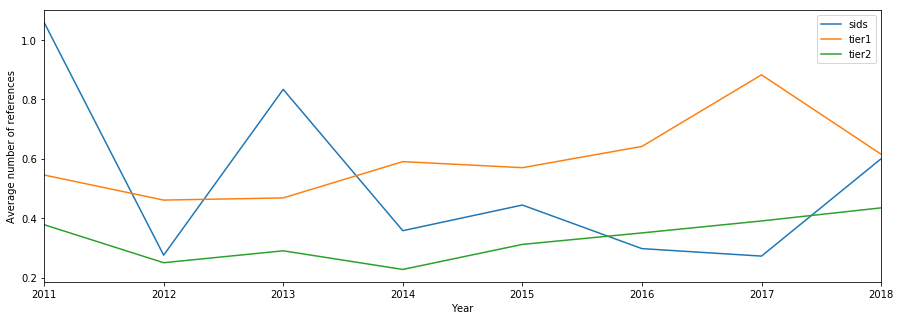

In [75]:
df_average_per_region_year_intersection = pd.DataFrame(data=average_per_region_year_intersection)
ax = df_average_per_region_year_intersection[['sids','tier1','tier2']].filter(items=['2011','2012','2013','2014','2015','2016','2017','2018'],axis=0).plot.line(figsize=(15,5))
ax.set_xticklabels(['2011','2012','2013','2014','2015','2016','2017','2018'])
ax.set_xlabel("Year")
ax.set_ylabel("Average number of references")
ax

### References per sector: total, average, proportion

For one specific sector “Health Care Equipment and Services” produce graphs of trend lines for health, climate change, and intersection over the complete time period:

- 2.1 Total count of mentions
- 2.2 Proportion of all reports for this sector that mention at least once
- 2.3 Proportion per country group (sids,  tier1,  tier 2)
- 2.4 Proportion per WHO region

In [62]:
df_per_year = pd.DataFrame(data=per_year)
df_per_year

,health,climate,intersection
2004,54,39,1
2005,69,41,2
2006,95,43,6
2007,64,60,1
2008,94,114,0
2009,8,14,0
2010,0,0,0
2011,15362,9338,473
2012,20097,11171,475
2013,25542,12041,643


In [61]:
df_per_sector = pd.DataFrame(data=per_sector)
df_per_sector_hces = df_per_sector.loc[df_per_sector.index=='Health Care Equipment & Ser...',:]
df_per_sector_hces

,health,climate,intersection
Health Care Equipment & Ser...,6843,677,108


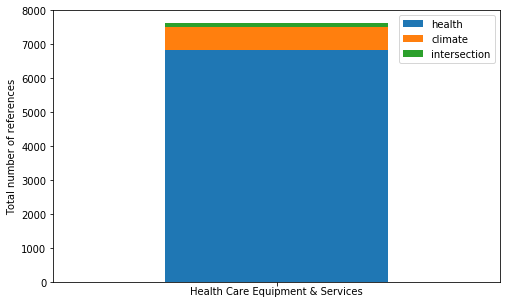

In [57]:
ax = df_per_sector_hces.plot.bar(stacked=True,figsize=(8,5))
ax.set_xlabel("Health Care Equipment & Services")
ax.set_ylabel("Total number of references")
ax.tick_params(labelbottom=False)
ax

In [59]:
df_average_per_sector = pd.DataFrame(data=average_per_sector)
df_average_per_sector_hces = df_average_per_sector.loc[df_average_per_sector.index=='Health Care Equipment & Ser...',:]

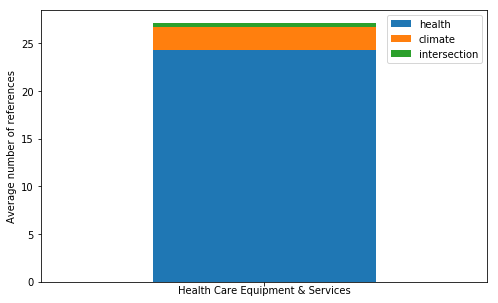

In [60]:
ax = df_average_per_sector_hces.plot.bar(stacked=True,figsize=(8,5))
ax.set_xlabel("Health Care Equipment & Services")
ax.set_ylabel("Average number of references")
ax.tick_params(labelbottom=False)
ax

For one specific sector “Health Care Equipment and Services” produce a **trend line of proportion of reports per country** that mention at least once climate change, health, and intersection references over the whole time period. For the following countries (English speaking):
- 3.1 USA
- 3.2 UK
- 3.3 Australia
- 3.4 Canada
- 3.5 New Zealand
- 3.6 South Africa

### Keywords

Produce the tables of frequency of keywords (health and climate) for the “Health Care Equipment and Services” sector.

### Network graphs

Network graph of co-occurrence for the Health sector.